### Imports

In [485]:
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import numpy as np
import pandas as pd
from datetime import datetime

import backtrader as bt
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

In [486]:
(1194.5-1187.75)/1194.5

0.005650899958141482

In [487]:
import sys

sys.path.append('./Strategies')
sys.path.append('./DataFeeds')

from glove import *
#from buy_and_hold_strats import *
from random_strats import *
from mean_ou_strats import *
from high_mid_low_strats import *

### Strategy Testing

In [488]:
#Bracket Orders BUY + Cloase each day
class HighMidLow(bt.Strategy):
    
    params = dict(
        stop_loss = 0.92,  # price is 2% less than the entry point
        take_profit = 10.04,
        orders = dict(),
        msg='',
        data = pd.DataFrame(columns = ['entry_time', 'position', 'weight', 'entry_price', 'sentiment', 'exit_time', 'exit_price'])
    )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(sep=' ', timespec='auto'), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.sentiment = self.datas[0].sentiment_mean
        self.size = self.data.buflen()
        self.order = None
        self.stop_order = None
        self.tp_order = None
        self.total_position = 0
    
    def update_dataset(self, order, close = False):
        if not close:
            pos = 1 if order.isbuy() else -1
            data_new_line = pd.DataFrame(
                [[
                    self.datas[0].datetime.datetime(0), 
                    pos, 
                    order.size*order.executed.price,
                    order.executed.price,
                    self.data.sentiment_mean[-1],
                    None,
                    None
                ]], 
                columns = ['entry_time', 'position', 'weight', 'entry_price', 'sentiment', 'exit_time', 'exit_price'])
            self.p.data = pd.concat([self.p.data,data_new_line], axis = 0, ignore_index=False)
        else:
            self.p.data.loc[self.p.data['exit_time'].isna() ,'exit_time'] = self.datas[0].datetime.datetime(-1)
            self.p.data.loc[self.p.data['exit_price'].isna() ,'exit_price'] = order.executed.price
    def notify_order(self, order):
        
        # Save submitted order
        if order.status in [order.Submitted, order.Accepted]:
            self.p.orders[order.ref] = order
            return
        
        # Check if an order has been completed
        if order.status in [order.Completed]:
            

            if not self.position:
                print('(CLOSE)', end='')
            else:
                self.log(self.p.msg)
            #print(self.p.data)
            if order.isbuy():
                self.update_dataset(order)
                self.log('BUY EXECUTED, ' + str(order.size) + 'BTC AT ' +str(order.executed.price))
            elif order.issell():
                self.update_dataset(order, close = True)
                self.log('SELL EXECUTED, ' + str(order.size) + 'BTC AT ' + str(order.executed.price))
                
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            if order.status == order.Canceled:
                self.log('Order Canceled')
            elif order.status == order.Margin:
                self.log('Not Enough Margin')
            elif order.status == order.Rejected:
                self.log('Order Rejected')

        self.order = None

    def broker_val_diff(self):
        prev_sentiment = 0
        if len(self) > 0:
            prev_sentiment = self.datas[0].sentiment_mean[-1] - self.datas[0].rolling_mean[-1]
        this_sentiment = self.datas[0].sentiment_mean - self.datas[0].rolling_mean
        sentiment = this_sentiment - prev_sentiment
        pos_size = self.broker.getvalue()*(sentiment)/self.datas[0].open[0]
        return pos_size
    
    #high sqn big diff
    def broker_val(self):
        prev_sentiment = 0
        if len(self) > 0:
            prev_sentiment = self.datas[0].sentiment_mean[-1]
        this_sentiment = self.datas[0].sentiment_mean
        sentiment = this_sentiment - prev_sentiment
        pos_size = self.broker.getvalue()*(sentiment)/self.datas[0].open[0]
        return pos_size
    
    def pure(self):
        prev_sentiment = 0
        if len(self) > 0:
            prev_sentiment = self.datas[0].sentiment_mean[-1]
        this_sentiment = self.datas[0].sentiment_mean
        sentiment = this_sentiment - prev_sentiment
        return sentiment
    
    def single(self):
         return self.broker.getvalue()*(self.datas[0].sentiment_mean)/self.datas[0].open
            
    #no difference
    def standar(self):
        return self.broker.getvalue()*0.05/self.datas[0].open
    
    def next(self):
        #print(self.data.sentiment_mean[0], self.data.open[0],self.data.close[0], self.data.volume[0])

        if self.order:
            return
        #if not self.position.size:
        # this is to play only on periods with sentiment data
        if self.datas[0].sentiment_mean > -2.0:
            # High
#             if self.datas[0].sentiment_mean >= self.datas[0].rolling_mean:
            if self.datas[0].sentiment_weighted_mean >= 0.00:
            # Mid
#             if self.datas[0].sentiment_mean < 0.7 and self.datas[0].sentiment_mean > 0.633:
            # Low
#             if self.datas[0].sentiment_mean <= 0.633:
                #print(self.broker.getvalue(), self.broker.getcash())
                
        
                #position sizing
                #pos_size = self.broker_val_diff()
#                 pos_size = self.single()
                     
#              
                if self.position.size:
                    self.close(exectype=bt.Order.Market, coc = True)
#                 pos_size = abs(self.datas[0].sentiment_weighted_mean)/self.datas[0].open[0]
                #stop loss price
                sl_price = self.datas[0].open[0]*(1-self.p.stop_loss)
                #take profit price
                tp_price = self.datas[0].open[0]*(1+self.p.take_profit)
#             if pos_size>0:
#                     #Debug message
#                     self.p.msg = 'BUY CREATED AT ' + str(self.datas[0].open[0]) +' STOPLOSS SET AT ' + str(sl_price)+ '$ TAKE PROFIT AT '+ str(tp_price)+'$'
#                     #self.buy(exectype=bt.Order.Market, size = pos_size)

                #Bracket order buy
                self.order = self.buy_bracket(exectype=bt.Order.Market, 
                                     stopprice = sl_price,
                                     limitprice = tp_price,
                                     coc=False)

#                 new_pos = pos_size - self.position.size
#                 if new_pos > 0:
#                     self.order = self.buy(exectype=bt.Order.Market, size = abs(new_pos))
#                 elif new_pos < 0:
#                     self.order = self.sell(exectype=bt.Order.Market, size = abs(new_pos))
        #Close all positions at the Close of the day
        if self.position.size:
            #self.log(str(len(self))+' '+str(self.size))
            if len(self) == self.size or self.datas[0].datetime.datetime(0).strftime('%Y-%m-%d')!=self.datas[0].datetime.datetime(1).strftime('%Y-%m-%d'):
            #if len(self) == self.size or self.datas[0].datetime.datetime(0).strftime('%Y-%m-%d %H')!=self.datas[0].datetime.datetime(1).strftime('%Y-%m-%d %H'):
                self.order = self.close(exectype=bt.Order.Market, coc = True)
                # and Cancel all pending orders
                for o in self.p.orders:
                    order = self.p.orders[o]
                    if order.alive :
                        self.cancel(order)
                self.p.orders = dict()
                
                if len(self) == self.size:
                     self.p.data.loc[self.p.data['exit_time'].isna() ,'exit_time'] = self.datas[0].datetime.datetime(0)
                     self.p.data.loc[self.p.data['exit_price'].isna() ,'exit_price'] = self.datas[0].close[0]
                

### Running Backtest

In [473]:
x = pd.read_csv('../Data Preprocessed/glove_1M_full_dates_hour.csv')
x.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12959 entries, 0 to 12958
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   hour               12959 non-null  object 
 1   Open               12959 non-null  float64
 2   Close              12959 non-null  float64
 3   High               12959 non-null  float64
 4   Low                12959 non-null  float64
 5   Volume_(Currency)  12959 non-null  float64
 6   Bitcoin            11989 non-null  float64
 7   Bitcoin_weighted   11989 non-null  float64
dtypes: float64(7), object(1)
memory usage: 810.1+ KB


In [474]:
# x.loc[x['Bitcoin'].isna(),'Bitcoin'] = 7
x

,hour,Open,Close,High,Low,Volume_(Currency),Bitcoin,Bitcoin_weighted
0,2017-08-01 00:00:00,2855.81,2825.92,2863.06,2823.00,5.761686e+05,0.551378,0.006434
1,2017-08-01 01:00:00,2823.01,2853.38,2860.02,2821.01,2.305357e+05,0.542253,0.003526
2,2017-08-01 02:00:00,2846.27,2841.60,2858.04,2837.31,4.106376e+05,0.558104,0.036610
3,2017-08-01 03:00:00,2841.84,2862.93,2863.88,2837.73,7.004128e+05,0.543261,0.019883
4,2017-08-01 04:00:00,2862.92,2872.03,2876.00,2848.11,7.303088e+05,0.548800,0.017027
...,...,...,...,...,...,...,...,...
12954,2019-01-22 18:00:00,3591.48,3590.67,3592.24,3575.93,8.446970e+05,0.536790,0.007699
12955,2019-01-22 19:00:00,3589.30,3579.28,3615.80,3573.00,2.241047e+06,0.526050,0.001949
12956,2019-01-22 20:00:00,3579.28,3585.51,3592.28,3579.28,5.052538e+05,0.539084,0.016331
12957,2019-01-22 21:00:00,3586.72,3574.26,3592.28,3573.99,4.213898e+05,0.510615,-0.016327


In [475]:
class glove_1M_full_dates_hour_rolling_mean_feed(btfeeds.GenericCSVData):
    lines = ( 'sentiment_mean','sentiment_weighted_mean', 'rolling_mean', 'rolling_mean_weighted',)
    params = (
        ('nullvalue', -2),
        ('dtformat', '%Y-%m-%d %H:%M:%S'),
        ('datetime', 0),
        ('open', 1),
        ('close', 2),
        ('low', 4),
        ('high', 3),
        ('volume', 5),
        ('sentiment_mean', 6),
        ('sentiment_weighted_mean', 7),
        ('rolling_mean', 10),
        ('rolling_mean_weighted', 11),
        ('time', -1),
        ('openinterest', -1),
    )

In [476]:
import pathlib
import backtrader.analyzers as btanalyzers
# Create a cerebro entity
cerebro = bt.Cerebro(cheat_on_open=True)

# Add a strategy
#strat = Random
# strat = TestStrategy
# strat = BuyAndHold
strat = HighMidLow
# strat = OverUnderMean
cerebro.addstrategy(strat)
# strat = BuyAndHold
# cerebro.addstrategy(strat)

#data = glove_100k_91_min_feed(dataname = '../Data Preprocessed/glove_100k_91_min.csv', timeframe = bt.TimeFrame.Minutes, compression = 1)
# data = glove_1M_full_dates_min_feed(dataname = '../Data Preprocessed/glove_1M_full_dates_min.csv', timeframe = bt.TimeFrame.Minutes, compression = 1)
#data = glove_1M_full_dates_hour_feed(dataname = '../Data Preprocessed/glove_1M_full_dates_hour.csv', timeframe = bt.TimeFrame.Minutes, compression = 60)
#data = final_dataset_feed(dataname = '../final_dataset3.csv', timeframe = bt.TimeFrame.Minutes, compression = 60)
data = glove_1M_full_dates_hour_rolling_mean_feed(dataname = './glove_1M_full_dates_hour_rolling_mean.csv', timeframe = bt.TimeFrame.Minutes, compression = 60)
cerebro.broker.setcommission(commission=0.0, margin=0.0)
cerebro.broker.set_coc(True)
# Add the Data Feed to Cerebro
cerebro.adddata(data)

#sizers
# cerebro.addsizer(bt.sizers.AllInSizer)
# cerebro.addsizer(bt.sizers.PercentSizer, percents=10)
cerebro.addsizer(bt.sizers.PercentSizer, percents = 95)
# cerebro.addsizer(bt.sizers.PercentSizer, percents = 0.01)
# cerebro.addsizer(bt.sizers.SizerFix, stake=0.1)

#observers
cerebro.addobserver(bt.observers.BuySell)

#analyzers
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
cerebro.addanalyzer(btanalyzers.SQN, _name='sqn')

#cerebro.add_order_history(orders, notify=True)

# Set our desired cash start
cerebro.broker.setcash(1)


# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

results = cerebro.run()

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')

returns_high, positions_high, transactions_high, gross_lev_high = pyfoliozer.get_pf_items()

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1.00
2017-08-01 01:00:00, 
2017-08-01 01:00:00, BUY EXECUTED, 0.00033617370626203144BTC AT 2823.01
2017-08-01 02:00:00, 
2017-08-01 02:00:00, SELL EXECUTED, -0.00033617370626203144BTC AT 2853.38
2017-08-01 02:00:00, 
2017-08-01 02:00:00, BUY EXECUTED, 0.00033617370626203144BTC AT 2846.27
2017-08-01 03:00:00, 
2017-08-01 03:00:00, SELL EXECUTED, -0.00033617370626203144BTC AT 2841.6
2017-08-01 03:00:00, 
2017-08-01 03:00:00, BUY EXECUTED, 0.00033617370626203144BTC AT 2841.84
2017-08-01 04:00:00, 
2017-08-01 04:00:00, SELL EXECUTED, -0.00033617370626203144BTC AT 2862.93
2017-08-01 04:00:00, 
2017-08-01 04:00:00, BUY EXECUTED, 0.00033617370626203144BTC AT 2862.92
2017-08-01 05:00:00, 
2017-08-01 05:00:00, SELL EXECUTED, -0.00033617370626203144BTC AT 2872.03
2017-08-01 05:00:00, 
2017-08-01 05:00:00, BUY EXECUTED, 0.00033617370626203144BTC AT 2872.03
2017-08-01 07:00:00, 
2017-08-01 07:00:00, SELL EXECUTED, -0.00033617370626203144BTC AT 2878.99
2017-08-01 07:00:00,

2017-08-05 08:00:00, 
2017-08-05 08:00:00, SELL EXECUTED, -0.00034021503806122084BTC AT 3120.1200000000003
2017-08-05 08:00:00, 
2017-08-05 08:00:00, BUY EXECUTED, 0.00034021503806122084BTC AT 3120.1200000000003
2017-08-05 09:00:00, 
2017-08-05 09:00:00, SELL EXECUTED, -0.00034021503806122084BTC AT 3171.8
2017-08-05 09:00:00, 
2017-08-05 09:00:00, BUY EXECUTED, 0.00034021503806122084BTC AT 3165.9200000000005
2017-08-05 11:00:00, 
2017-08-05 11:00:00, SELL EXECUTED, -0.00034021503806122084BTC AT 3193.0
2017-08-05 11:00:00, 
2017-08-05 11:00:00, BUY EXECUTED, 0.00034021503806122084BTC AT 3192.0000000000005
2017-08-05 12:00:00, 
2017-08-05 12:00:00, SELL EXECUTED, -0.00034021503806122084BTC AT 3145.9299999999994
2017-08-05 12:00:00, 
2017-08-05 12:00:00, BUY EXECUTED, 0.00034021503806122084BTC AT 3143.7
2017-08-05 13:00:00, 
2017-08-05 13:00:00, SELL EXECUTED, -0.00034021503806122084BTC AT 3150.0
2017-08-05 13:00:00, 
2017-08-05 13:00:00, BUY EXECUTED, 0.00034021503806122084BTC AT 3147.0


2017-08-08 11:00:00, SELL EXECUTED, -0.00034913571002469825BTC AT 3414.3800000000006
2017-08-08 11:00:00, 
2017-08-08 11:00:00, BUY EXECUTED, 0.00034913571002469825BTC AT 3412.68
2017-08-08 12:00:00, 
2017-08-08 12:00:00, SELL EXECUTED, -0.00034913571002469825BTC AT 3440.2
2017-08-08 12:00:00, 
2017-08-08 12:00:00, BUY EXECUTED, 0.00034913571002469825BTC AT 3441.68
2017-08-08 13:00:00, 
2017-08-08 13:00:00, SELL EXECUTED, -0.00034913571002469825BTC AT 3440.0
2017-08-08 13:00:00, 
2017-08-08 13:00:00, BUY EXECUTED, 0.00034913571002469825BTC AT 3440.0
2017-08-08 14:00:00, 
2017-08-08 14:00:00, SELL EXECUTED, -0.00034913571002469825BTC AT 3372.54
2017-08-08 14:00:00, 
2017-08-08 14:00:00, BUY EXECUTED, 0.00034913571002469825BTC AT 3381.98
2017-08-08 15:00:00, 
2017-08-08 15:00:00, SELL EXECUTED, -0.00034913571002469825BTC AT 3380.64
2017-08-08 15:00:00, 
2017-08-08 15:00:00, BUY EXECUTED, 0.00034913571002469825BTC AT 3377.43
2017-08-08 17:00:00, 
2017-08-08 17:00:00, SELL EXECUTED, -0.000

2017-08-10 18:00:00, BUY EXECUTED, 0.0003590499211563064BTC AT 3415.1699999999996
2017-08-10 19:00:00, 
2017-08-10 19:00:00, SELL EXECUTED, -0.0003590499211563064BTC AT 3410.79
2017-08-10 19:00:00, 
2017-08-10 19:00:00, BUY EXECUTED, 0.0003590499211563064BTC AT 3409.36
2017-08-10 20:00:00, 
2017-08-10 20:00:00, SELL EXECUTED, -0.0003590499211563064BTC AT 3410.0
2017-08-10 20:00:00, 
2017-08-10 20:00:00, BUY EXECUTED, 0.0003590499211563064BTC AT 3410.0
2017-08-10 21:00:00, 
2017-08-10 21:00:00, SELL EXECUTED, -0.0003590499211563064BTC AT 3419.9999999999995
2017-08-10 21:00:00, 
2017-08-10 21:00:00, BUY EXECUTED, 0.0003590499211563064BTC AT 3419.99
2017-08-10 22:00:00, 
2017-08-10 22:00:00, SELL EXECUTED, -0.0003590499211563064BTC AT 3430.84
2017-08-10 22:00:00, 
2017-08-10 22:00:00, BUY EXECUTED, 0.0003590499211563064BTC AT 3426.0
2017-08-10 23:00:00, 
2017-08-10 23:00:00, SELL EXECUTED, -0.0003590499211563064BTC AT 3426.0
2017-08-10 23:00:00, 
2017-08-10 23:00:00, BUY EXECUTED, 0.00035

2017-08-12 21:00:00, 
2017-08-12 21:00:00, SELL EXECUTED, -0.00036407740644834945BTC AT 3778.3799999999997
2017-08-12 21:00:00, 
2017-08-12 21:00:00, BUY EXECUTED, 0.00036407740644834945BTC AT 3779.02
2017-08-12 22:00:00, 
2017-08-12 22:00:00, SELL EXECUTED, -0.00036407740644834945BTC AT 3799.9699999999993
2017-08-12 22:00:00, 
2017-08-12 22:00:00, BUY EXECUTED, 0.00036407740644834945BTC AT 3805.58
2017-08-12 23:00:00, 
2017-08-12 23:00:00, SELL EXECUTED, -0.00036407740644834945BTC AT 3838.63
2017-08-12 23:00:00, 
2017-08-12 23:00:00, BUY EXECUTED, 0.00036407740644834945BTC AT 3830.01
2017-08-13 00:00:00, Order Canceled
2017-08-13 00:00:00, Order Canceled
2017-08-13 00:00:00, Order Canceled
2017-08-13 00:00:00, Order Canceled
2017-08-13 00:00:00, Order Canceled
2017-08-13 00:00:00, Order Canceled
2017-08-13 00:00:00, Order Canceled
2017-08-13 00:00:00, Order Canceled
2017-08-13 00:00:00, Order Canceled
2017-08-13 00:00:00, Order Canceled
2017-08-13 00:00:00, Order Canceled
2017-08-13 0

2017-08-16 06:00:00, BUY EXECUTED, 0.00035578042748771497BTC AT 3970.0699999999997
2017-08-16 08:00:00, 
2017-08-16 08:00:00, SELL EXECUTED, -0.00035578042748771497BTC AT 4056.99
2017-08-16 08:00:00, 
2017-08-16 08:00:00, BUY EXECUTED, 0.00035578042748771497BTC AT 4061.28
2017-08-16 09:00:00, 
2017-08-16 09:00:00, SELL EXECUTED, -0.00035578042748771497BTC AT 4164.15
2017-08-16 09:00:00, 
2017-08-16 09:00:00, BUY EXECUTED, 0.00035578042748771497BTC AT 4161.04
2017-08-16 10:00:00, 
2017-08-16 10:00:00, SELL EXECUTED, -0.00035578042748771497BTC AT 4144.84
2017-08-16 10:00:00, 
2017-08-16 10:00:00, BUY EXECUTED, 0.00035578042748771497BTC AT 4134.07
2017-08-16 11:00:00, 
2017-08-16 11:00:00, SELL EXECUTED, -0.00035578042748771497BTC AT 4090.1200000000003
2017-08-16 11:00:00, 
2017-08-16 11:00:00, BUY EXECUTED, 0.00035578042748771497BTC AT 4090.1200000000003
2017-08-16 13:00:00, 
2017-08-16 13:00:00, SELL EXECUTED, -0.00035578042748771497BTC AT 4105.97
2017-08-16 13:00:00, 
2017-08-16 13:00:

2017-08-18 08:00:00, 
2017-08-18 08:00:00, SELL EXECUTED, -0.0003712038474725168BTC AT 4296.72
2017-08-18 08:00:00, 
2017-08-18 08:00:00, BUY EXECUTED, 0.0003712038474725168BTC AT 4296.72
2017-08-18 09:00:00, 
2017-08-18 09:00:00, SELL EXECUTED, -0.0003712038474725168BTC AT 4283.11
2017-08-18 09:00:00, 
2017-08-18 09:00:00, BUY EXECUTED, 0.0003712038474725168BTC AT 4284.0
2017-08-18 10:00:00, 
2017-08-18 10:00:00, SELL EXECUTED, -0.0003712038474725168BTC AT 4303.97
2017-08-18 10:00:00, 
2017-08-18 10:00:00, BUY EXECUTED, 0.0003712038474725168BTC AT 4295.16
2017-08-18 11:00:00, 
2017-08-18 11:00:00, SELL EXECUTED, -0.0003712038474725168BTC AT 4346.98
2017-08-18 11:00:00, 
2017-08-18 11:00:00, BUY EXECUTED, 0.0003712038474725168BTC AT 4346.96
2017-08-18 12:00:00, 
2017-08-18 12:00:00, SELL EXECUTED, -0.0003712038474725168BTC AT 4308.99
2017-08-18 12:00:00, 
2017-08-18 12:00:00, BUY EXECUTED, 0.0003712038474725168BTC AT 4308.99
2017-08-18 13:00:00, 
2017-08-18 13:00:00, SELL EXECUTED, -0.

2017-08-20 12:00:00, BUY EXECUTED, 0.00037184633666466344BTC AT 4044.6
2017-08-20 14:00:00, 
2017-08-20 14:00:00, SELL EXECUTED, -0.00037184633666466344BTC AT 4005.43
2017-08-20 14:00:00, 
2017-08-20 14:00:00, BUY EXECUTED, 0.00037184633666466344BTC AT 4018.3
2017-08-20 15:00:00, 
2017-08-20 15:00:00, SELL EXECUTED, -0.00037184633666466344BTC AT 4025.6199999999994
2017-08-20 15:00:00, 
2017-08-20 15:00:00, BUY EXECUTED, 0.00037184633666466344BTC AT 4025.65
2017-08-20 18:00:00, 
2017-08-20 18:00:00, SELL EXECUTED, -0.00037184633666466344BTC AT 4062.99
2017-08-20 18:00:00, 
2017-08-20 18:00:00, BUY EXECUTED, 0.00037184633666466344BTC AT 4062.99
2017-08-20 19:00:00, 
2017-08-20 19:00:00, SELL EXECUTED, -0.00037184633666466344BTC AT 4075.81
2017-08-20 19:00:00, 
2017-08-20 19:00:00, BUY EXECUTED, 0.00037184633666466344BTC AT 4084.97
2017-08-20 20:00:00, 
2017-08-20 20:00:00, SELL EXECUTED, -0.00037184633666466344BTC AT 4088.3999999999996
2017-08-20 20:00:00, 
2017-08-20 20:00:00, BUY EXECU

2017-08-23 02:00:00, BUY EXECUTED, 0.00038744847809460805BTC AT 4133.54
2017-08-23 03:00:00, 
2017-08-23 03:00:00, SELL EXECUTED, -0.00038744847809460805BTC AT 4097.07
2017-08-23 03:00:00, 
2017-08-23 03:00:00, BUY EXECUTED, 0.00038744847809460805BTC AT 4097.07
2017-08-23 04:00:00, 
2017-08-23 04:00:00, SELL EXECUTED, -0.00038744847809460805BTC AT 4095.61
2017-08-23 04:00:00, 
2017-08-23 04:00:00, BUY EXECUTED, 0.00038744847809460805BTC AT 4078.9899999999993
2017-08-23 05:00:00, 
2017-08-23 05:00:00, SELL EXECUTED, -0.00038744847809460805BTC AT 4103.54
2017-08-23 05:00:00, 
2017-08-23 05:00:00, BUY EXECUTED, 0.00038744847809460805BTC AT 4103.9
2017-08-23 06:00:00, 
2017-08-23 06:00:00, SELL EXECUTED, -0.00038744847809460805BTC AT 4066.99
2017-08-23 06:00:00, 
2017-08-23 06:00:00, BUY EXECUTED, 0.00038744847809460805BTC AT 4066.99
2017-08-23 08:00:00, 
2017-08-23 08:00:00, SELL EXECUTED, -0.00038744847809460805BTC AT 4097.0
2017-08-23 08:00:00, 
2017-08-23 08:00:00, BUY EXECUTED, 0.0003

2017-08-25 17:00:00, BUY EXECUTED, 0.0003800694542699078BTC AT 4447.99
2017-08-25 18:00:00, 
2017-08-25 18:00:00, SELL EXECUTED, -0.0003800694542699078BTC AT 4419.99
2017-08-25 18:00:00, 
2017-08-25 18:00:00, BUY EXECUTED, 0.0003800694542699078BTC AT 4419.99
2017-08-25 19:00:00, 
2017-08-25 19:00:00, SELL EXECUTED, -0.0003800694542699078BTC AT 4433.88
2017-08-25 19:00:00, 
2017-08-25 19:00:00, BUY EXECUTED, 0.0003800694542699078BTC AT 4432.19
2017-08-25 20:00:00, 
2017-08-25 20:00:00, SELL EXECUTED, -0.0003800694542699078BTC AT 4324.84
2017-08-25 20:00:00, 
2017-08-25 20:00:00, BUY EXECUTED, 0.0003800694542699078BTC AT 4320.03
2017-08-25 21:00:00, 
2017-08-25 21:00:00, SELL EXECUTED, -0.0003800694542699078BTC AT 4327.57
2017-08-25 21:00:00, 
2017-08-25 21:00:00, BUY EXECUTED, 0.0003800694542699078BTC AT 4327.86
2017-08-25 22:00:00, 
2017-08-25 22:00:00, SELL EXECUTED, -0.0003800694542699078BTC AT 4328.37
2017-08-25 22:00:00, 
2017-08-25 22:00:00, BUY EXECUTED, 0.0003800694542699078BTC 

2017-08-28 02:00:00, BUY EXECUTED, 0.0003904835825634274BTC AT 4308.28
2017-08-28 03:00:00, 
2017-08-28 03:00:00, SELL EXECUTED, -0.0003904835825634274BTC AT 4301.62
2017-08-28 03:00:00, 
2017-08-28 03:00:00, BUY EXECUTED, 0.0003904835825634274BTC AT 4309.29
2017-08-28 05:00:00, 
2017-08-28 05:00:00, SELL EXECUTED, -0.0003904835825634274BTC AT 4240.0
2017-08-28 05:00:00, 
2017-08-28 05:00:00, BUY EXECUTED, 0.0003904835825634274BTC AT 4240.0
2017-08-28 06:00:00, 
2017-08-28 06:00:00, SELL EXECUTED, -0.0003904835825634274BTC AT 4227.6
2017-08-28 06:00:00, 
2017-08-28 06:00:00, BUY EXECUTED, 0.0003904835825634274BTC AT 4222.5
2017-08-28 07:00:00, 
2017-08-28 07:00:00, SELL EXECUTED, -0.0003904835825634274BTC AT 4236.63
2017-08-28 07:00:00, 
2017-08-28 07:00:00, BUY EXECUTED, 0.0003904835825634274BTC AT 4238.96
2017-08-28 08:00:00, 
2017-08-28 08:00:00, SELL EXECUTED, -0.0003904835825634274BTC AT 4279.99
2017-08-28 08:00:00, 
2017-08-28 08:00:00, BUY EXECUTED, 0.0003904835825634274BTC AT 4

2017-08-31 05:00:00, 
2017-08-31 05:00:00, SELL EXECUTED, -0.0003827621300830687BTC AT 4611.06
2017-08-31 05:00:00, 
2017-08-31 05:00:00, BUY EXECUTED, 0.0003827621300830687BTC AT 4611.06
2017-08-31 06:00:00, 
2017-08-31 06:00:00, SELL EXECUTED, -0.0003827621300830687BTC AT 4624.04
2017-08-31 06:00:00, 
2017-08-31 06:00:00, BUY EXECUTED, 0.0003827621300830687BTC AT 4624.02
2017-08-31 07:00:00, 
2017-08-31 07:00:00, SELL EXECUTED, -0.0003827621300830687BTC AT 4599.49
2017-08-31 07:00:00, 
2017-08-31 07:00:00, BUY EXECUTED, 0.0003827621300830687BTC AT 4599.49
2017-08-31 08:00:00, 
2017-08-31 08:00:00, SELL EXECUTED, -0.0003827621300830687BTC AT 4619.16
2017-08-31 08:00:00, 
2017-08-31 08:00:00, BUY EXECUTED, 0.0003827621300830687BTC AT 4612.73
2017-08-31 10:00:00, 
2017-08-31 10:00:00, SELL EXECUTED, -0.0003827621300830687BTC AT 4609.99
2017-08-31 10:00:00, 
2017-08-31 10:00:00, BUY EXECUTED, 0.0003827621300830687BTC AT 4609.99
2017-08-31 11:00:00, 
2017-08-31 11:00:00, SELL EXECUTED, -0

2017-09-02 14:00:00, SELL EXECUTED, -0.0003817293888564887BTC AT 4631.02
2017-09-02 14:00:00, 
2017-09-02 14:00:00, BUY EXECUTED, 0.0003817293888564887BTC AT 4633.5
2017-09-02 19:00:00, 
2017-09-02 19:00:00, SELL EXECUTED, -0.0003817293888564887BTC AT 4591.23
2017-09-02 19:00:00, 
2017-09-02 19:00:00, BUY EXECUTED, 0.0003817293888564887BTC AT 4587.71
2017-09-02 20:00:00, 
2017-09-02 20:00:00, SELL EXECUTED, -0.0003817293888564887BTC AT 4605.89
2017-09-02 20:00:00, 
2017-09-02 20:00:00, BUY EXECUTED, 0.0003817293888564887BTC AT 4606.0
2017-09-03 00:00:00, Order Canceled
2017-09-03 00:00:00, Order Canceled
2017-09-03 00:00:00, Order Canceled
2017-09-03 00:00:00, Order Canceled
2017-09-03 00:00:00, Order Canceled
2017-09-03 00:00:00, Order Canceled
2017-09-03 00:00:00, Order Canceled
2017-09-03 00:00:00, Order Canceled
2017-09-03 00:00:00, Order Canceled
2017-09-03 00:00:00, Order Canceled
2017-09-03 00:00:00, Order Canceled
2017-09-03 00:00:00, Order Canceled
2017-09-03 00:00:00, Order C

2017-09-06 10:00:00, 
2017-09-06 10:00:00, SELL EXECUTED, -0.00038890882630828307BTC AT 4524.69
2017-09-06 10:00:00, 
2017-09-06 10:00:00, BUY EXECUTED, 0.00038890882630828307BTC AT 4528.4
2017-09-06 11:00:00, 
2017-09-06 11:00:00, SELL EXECUTED, -0.00038890882630828307BTC AT 4551.0
2017-09-06 11:00:00, 
2017-09-06 11:00:00, BUY EXECUTED, 0.00038890882630828307BTC AT 4551.0
2017-09-06 12:00:00, 
2017-09-06 12:00:00, SELL EXECUTED, -0.00038890882630828307BTC AT 4579.94
2017-09-06 12:00:00, 
2017-09-06 12:00:00, BUY EXECUTED, 0.00038890882630828307BTC AT 4579.94
2017-09-06 14:00:00, 
2017-09-06 14:00:00, SELL EXECUTED, -0.00038890882630828307BTC AT 4553.26
2017-09-06 14:00:00, 
2017-09-06 14:00:00, BUY EXECUTED, 0.00038890882630828307BTC AT 4553.0
2017-09-06 15:00:00, 
2017-09-06 15:00:00, SELL EXECUTED, -0.00038890882630828307BTC AT 4574.8
2017-09-06 15:00:00, 
2017-09-06 15:00:00, BUY EXECUTED, 0.00038890882630828307BTC AT 4575.0
2017-09-06 16:00:00, 
2017-09-06 16:00:00, SELL EXECUTED

2017-09-08 12:00:00, SELL EXECUTED, -0.00039320590232344967BTC AT 4627.84
2017-09-08 12:00:00, 
2017-09-08 12:00:00, BUY EXECUTED, 0.00039320590232344967BTC AT 4627.8
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
2017-09-09 00:00:00, Order Canceled
(CLOSE)2017-09-09 00:00:00, SELL EXECUTED, -0.00039320590232344967BTC AT 4312.0
2017-09-09 04:00:00, 
2017-09-09 04:00:00, BUY EXECUTED, 0.0004004301446859932BTC AT 4267.0
2017-09-10 00

2017-09-17 00:00:00, Order Canceled
2017-09-17 00:00:00, Order Canceled
2017-09-17 00:00:00, Order Canceled
2017-09-17 00:00:00, Order Canceled
2017-09-17 00:00:00, Order Canceled
2017-09-17 00:00:00, Order Canceled
2017-09-17 00:00:00, Order Canceled
2017-09-17 00:00:00, Order Canceled
2017-09-17 00:00:00, Order Canceled
2017-09-17 00:00:00, Order Canceled
(CLOSE)2017-09-17 00:00:00, SELL EXECUTED, -0.00039495332937103806BTC AT 3678.93
2017-09-17 01:00:00, 
2017-09-17 01:00:00, BUY EXECUTED, 0.0003980583244122321BTC AT 3639.9999999999995
2017-09-17 02:00:00, 
2017-09-17 02:00:00, SELL EXECUTED, -0.0003980583244122321BTC AT 3620.72
2017-09-17 02:00:00, 
2017-09-17 02:00:00, BUY EXECUTED, 0.0003980583244122321BTC AT 3623.45
2017-09-17 03:00:00, 
2017-09-17 03:00:00, SELL EXECUTED, -0.0003980583244122321BTC AT 3648.62
2017-09-17 03:00:00, 
2017-09-17 03:00:00, BUY EXECUTED, 0.0003980583244122321BTC AT 3648.64
2017-09-17 04:00:00, 
2017-09-17 04:00:00, SELL EXECUTED, -0.000398058324412232

2017-09-21 07:00:00, BUY EXECUTED, 0.00040019475662500086BTC AT 3868.99
2017-09-21 08:00:00, 
2017-09-21 08:00:00, SELL EXECUTED, -0.00040019475662500086BTC AT 3897.6
2017-09-21 08:00:00, 
2017-09-21 08:00:00, BUY EXECUTED, 0.00040019475662500086BTC AT 3894.06
2017-09-21 11:00:00, 
2017-09-21 11:00:00, SELL EXECUTED, -0.00040019475662500086BTC AT 3896.0099999999998
2017-09-21 11:00:00, 
2017-09-21 11:00:00, BUY EXECUTED, 0.00040019475662500086BTC AT 3892.5
2017-09-21 13:00:00, 
2017-09-21 13:00:00, SELL EXECUTED, -0.00040019475662500086BTC AT 3853.19
2017-09-21 13:00:00, 
2017-09-21 13:00:00, BUY EXECUTED, 0.00040019475662500086BTC AT 3853.19
2017-09-21 20:00:00, 
2017-09-21 20:00:00, SELL EXECUTED, -0.00040019475662500086BTC AT 3631.81
2017-09-21 20:00:00, 
2017-09-21 20:00:00, BUY EXECUTED, 0.00040019475662500086BTC AT 3639.55
2017-09-22 00:00:00, Order Canceled
2017-09-22 00:00:00, Order Canceled
2017-09-22 00:00:00, Order Canceled
2017-09-22 00:00:00, Order Canceled
2017-09-22 00:0

2017-09-25 03:00:00, 
2017-09-25 03:00:00, SELL EXECUTED, -0.00039538752177620983BTC AT 3753.68
2017-09-25 03:00:00, 
2017-09-25 03:00:00, BUY EXECUTED, 0.00039538752177620983BTC AT 3754.19
2017-09-25 06:00:00, 
2017-09-25 06:00:00, SELL EXECUTED, -0.00039538752177620983BTC AT 3767.65
2017-09-25 06:00:00, 
2017-09-25 06:00:00, BUY EXECUTED, 0.00039538752177620983BTC AT 3767.95
2017-09-25 07:00:00, 
2017-09-25 07:00:00, SELL EXECUTED, -0.00039538752177620983BTC AT 3765.0000000000005
2017-09-25 07:00:00, 
2017-09-25 07:00:00, BUY EXECUTED, 0.00039538752177620983BTC AT 3764.97
2017-09-25 08:00:00, 
2017-09-25 08:00:00, SELL EXECUTED, -0.00039538752177620983BTC AT 3771.62
2017-09-25 08:00:00, 
2017-09-25 08:00:00, BUY EXECUTED, 0.00039538752177620983BTC AT 3771.51
2017-09-25 12:00:00, 
2017-09-25 12:00:00, SELL EXECUTED, -0.00039538752177620983BTC AT 3769.1
2017-09-25 12:00:00, 
2017-09-25 12:00:00, BUY EXECUTED, 0.00039538752177620983BTC AT 3768.92
2017-09-25 13:00:00, 
2017-09-25 13:00:0

2017-09-27 13:00:00, SELL EXECUTED, -0.0003952586672390522BTC AT 4065.6600000000003
2017-09-27 13:00:00, 
2017-09-27 13:00:00, BUY EXECUTED, 0.0003952586672390522BTC AT 4074.86
2017-09-27 16:00:00, 
2017-09-27 16:00:00, SELL EXECUTED, -0.0003952586672390522BTC AT 4070.68
2017-09-27 16:00:00, 
2017-09-27 16:00:00, BUY EXECUTED, 0.0003952586672390522BTC AT 4070.6899999999996
2017-09-27 17:00:00, 
2017-09-27 17:00:00, SELL EXECUTED, -0.0003952586672390522BTC AT 4084.4
2017-09-27 17:00:00, 
2017-09-27 17:00:00, BUY EXECUTED, 0.0003952586672390522BTC AT 4078.47
2017-09-27 18:00:00, 
2017-09-27 18:00:00, SELL EXECUTED, -0.0003952586672390522BTC AT 4089.9999999999995
2017-09-27 18:00:00, 
2017-09-27 18:00:00, BUY EXECUTED, 0.0003952586672390522BTC AT 4080.73
2017-09-27 19:00:00, 
2017-09-27 19:00:00, SELL EXECUTED, -0.0003952586672390522BTC AT 4173.78
2017-09-27 19:00:00, 
2017-09-27 19:00:00, BUY EXECUTED, 0.0003952586672390522BTC AT 4173.77
2017-09-27 21:00:00, 
2017-09-27 21:00:00, SELL EX

2017-09-30 07:00:00, BUY EXECUTED, 0.0003941935964528606BTC AT 4270.0
2017-09-30 08:00:00, 
2017-09-30 08:00:00, SELL EXECUTED, -0.0003941935964528606BTC AT 4291.5
2017-09-30 08:00:00, 
2017-09-30 08:00:00, BUY EXECUTED, 0.0003941935964528606BTC AT 4291.5
2017-09-30 09:00:00, 
2017-09-30 09:00:00, SELL EXECUTED, -0.0003941935964528606BTC AT 4266.59
2017-09-30 09:00:00, 
2017-09-30 09:00:00, BUY EXECUTED, 0.0003941935964528606BTC AT 4266.61
2017-09-30 10:00:00, 
2017-09-30 10:00:00, SELL EXECUTED, -0.0003941935964528606BTC AT 4261.89
2017-09-30 10:00:00, 
2017-09-30 10:00:00, BUY EXECUTED, 0.0003941935964528606BTC AT 4261.85
2017-09-30 11:00:00, 
2017-09-30 11:00:00, SELL EXECUTED, -0.0003941935964528606BTC AT 4283.3
2017-09-30 11:00:00, 
2017-09-30 11:00:00, BUY EXECUTED, 0.0003941935964528606BTC AT 4285.76
2017-09-30 12:00:00, 
2017-09-30 12:00:00, SELL EXECUTED, -0.0003941935964528606BTC AT 4259.24
2017-09-30 12:00:00, 
2017-09-30 12:00:00, BUY EXECUTED, 0.0003941935964528606BTC AT 4

2017-10-02 23:00:00, SELL EXECUTED, -0.00039276458389631653BTC AT 4367.0
2017-10-02 23:00:00, 
2017-10-02 23:00:00, BUY EXECUTED, 0.00039276458389631653BTC AT 4367.0
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-10-03 00:00:00, Order Canceled
2017-1

2017-10-05 08:00:00, BUY EXECUTED, 0.00039920976841581446BTC AT 4158.03
2017-10-05 09:00:00, 
2017-10-05 09:00:00, SELL EXECUTED, -0.00039920976841581446BTC AT 4145.13
2017-10-05 09:00:00, 
2017-10-05 09:00:00, BUY EXECUTED, 0.00039920976841581446BTC AT 4149.01
2017-10-05 10:00:00, 
2017-10-05 10:00:00, SELL EXECUTED, -0.00039920976841581446BTC AT 4202.0
2017-10-05 10:00:00, 
2017-10-05 10:00:00, BUY EXECUTED, 0.00039920976841581446BTC AT 4201.77
2017-10-05 14:00:00, 
2017-10-05 14:00:00, SELL EXECUTED, -0.00039920976841581446BTC AT 4311.55
2017-10-05 14:00:00, 
2017-10-05 14:00:00, BUY EXECUTED, 0.00039920976841581446BTC AT 4313.69
2017-10-05 15:00:00, 
2017-10-05 15:00:00, SELL EXECUTED, -0.00039920976841581446BTC AT 4302.98
2017-10-05 15:00:00, 
2017-10-05 15:00:00, BUY EXECUTED, 0.00039920976841581446BTC AT 4302.99
2017-10-05 16:00:00, 
2017-10-05 16:00:00, SELL EXECUTED, -0.00039920976841581446BTC AT 4314.24
2017-10-05 16:00:00, 
2017-10-05 16:00:00, BUY EXECUTED, 0.00039920976841

2017-10-10 10:00:00, 
2017-10-10 10:00:00, SELL EXECUTED, -0.00039185026942533877BTC AT 4767.61
2017-10-10 10:00:00, 
2017-10-10 10:00:00, BUY EXECUTED, 0.00039185026942533877BTC AT 4767.61
2017-10-10 11:00:00, 
2017-10-10 11:00:00, SELL EXECUTED, -0.00039185026942533877BTC AT 4784.18
2017-10-10 11:00:00, 
2017-10-10 11:00:00, BUY EXECUTED, 0.00039185026942533877BTC AT 4796.63
2017-10-10 20:00:00, 
2017-10-10 20:00:00, SELL EXECUTED, -0.00039185026942533877BTC AT 4861.47
2017-10-10 20:00:00, 
2017-10-10 20:00:00, BUY EXECUTED, 0.00039185026942533877BTC AT 4869.09
2017-10-11 00:00:00, Order Canceled
2017-10-11 00:00:00, Order Canceled
2017-10-11 00:00:00, Order Canceled
2017-10-11 00:00:00, Order Canceled
2017-10-11 00:00:00, Order Canceled
2017-10-11 00:00:00, Order Canceled
2017-10-11 00:00:00, Order Canceled
2017-10-11 00:00:00, Order Canceled
(CLOSE)2017-10-11 00:00:00, SELL EXECUTED, -0.00039185026942533877BTC AT 4749.29
2017-10-11 02:00:00, 
2017-10-11 02:00:00, BUY EXECUTED, 0.00

(CLOSE)2017-10-13 00:00:00, SELL EXECUTED, -0.0003900842938506235BTC AT 5445.000000000001
2017-10-13 01:00:00, 
2017-10-13 01:00:00, BUY EXECUTED, 0.00039334151574702794BTC AT 5405.0
2017-10-13 02:00:00, 
2017-10-13 02:00:00, SELL EXECUTED, -0.00039334151574702794BTC AT 5509.999999999999
2017-10-13 02:00:00, 
2017-10-13 02:00:00, BUY EXECUTED, 0.00039334151574702794BTC AT 5510.1
2017-10-13 03:00:00, 
2017-10-13 03:00:00, SELL EXECUTED, -0.00039334151574702794BTC AT 5670.0
2017-10-13 03:00:00, 
2017-10-13 03:00:00, BUY EXECUTED, 0.00039334151574702794BTC AT 5670.0
2017-10-13 04:00:00, 
2017-10-13 04:00:00, SELL EXECUTED, -0.00039334151574702794BTC AT 5719.0
2017-10-13 04:00:00, 
2017-10-13 04:00:00, BUY EXECUTED, 0.00039334151574702794BTC AT 5719.0
2017-10-13 05:00:00, 
2017-10-13 05:00:00, SELL EXECUTED, -0.00039334151574702794BTC AT 5730.93
2017-10-13 05:00:00, 
2017-10-13 05:00:00, BUY EXECUTED, 0.00039334151574702794BTC AT 5730.92
2017-10-13 07:00:00, 
2017-10-13 07:00:00, SELL EXEC

2017-10-15 03:00:00, BUY EXECUTED, 0.00039839442070980927BTC AT 5829.93
2017-10-15 04:00:00, 
2017-10-15 04:00:00, SELL EXECUTED, -0.00039839442070980927BTC AT 5763.999999999999
2017-10-15 04:00:00, 
2017-10-15 04:00:00, BUY EXECUTED, 0.00039839442070980927BTC AT 5763.999999999999
2017-10-15 05:00:00, 
2017-10-15 05:00:00, SELL EXECUTED, -0.00039839442070980927BTC AT 5737.000000000001
2017-10-15 05:00:00, 
2017-10-15 05:00:00, BUY EXECUTED, 0.00039839442070980927BTC AT 5750.92
2017-10-15 06:00:00, 
2017-10-15 06:00:00, SELL EXECUTED, -0.00039839442070980927BTC AT 5752.69
2017-10-15 06:00:00, 
2017-10-15 06:00:00, BUY EXECUTED, 0.00039839442070980927BTC AT 5752.69
2017-10-15 07:00:00, 
2017-10-15 07:00:00, SELL EXECUTED, -0.00039839442070980927BTC AT 5748.99
2017-10-15 07:00:00, 
2017-10-15 07:00:00, BUY EXECUTED, 0.00039839442070980927BTC AT 5748.99
2017-10-15 08:00:00, 
2017-10-15 08:00:00, SELL EXECUTED, -0.00039839442070980927BTC AT 5730.21
2017-10-15 08:00:00, 
2017-10-15 08:00:00,

2017-10-17 16:00:00, 
2017-10-17 16:00:00, SELL EXECUTED, -0.0004020688370988047BTC AT 5584.96
2017-10-17 16:00:00, 
2017-10-17 16:00:00, BUY EXECUTED, 0.0004020688370988047BTC AT 5584.0
2017-10-17 18:00:00, 
2017-10-17 18:00:00, SELL EXECUTED, -0.0004020688370988047BTC AT 5615.0
2017-10-17 18:00:00, 
2017-10-17 18:00:00, BUY EXECUTED, 0.0004020688370988047BTC AT 5615.0
2017-10-17 19:00:00, 
2017-10-17 19:00:00, SELL EXECUTED, -0.0004020688370988047BTC AT 5599.99
2017-10-17 19:00:00, 
2017-10-17 19:00:00, BUY EXECUTED, 0.0004020688370988047BTC AT 5599.99
2017-10-17 20:00:00, 
2017-10-17 20:00:00, SELL EXECUTED, -0.0004020688370988047BTC AT 5628.320000000001
2017-10-17 20:00:00, 
2017-10-17 20:00:00, BUY EXECUTED, 0.0004020688370988047BTC AT 5625.63
2017-10-17 21:00:00, 
2017-10-17 21:00:00, SELL EXECUTED, -0.0004020688370988047BTC AT 5575.0
2017-10-17 21:00:00, 
2017-10-17 21:00:00, BUY EXECUTED, 0.0004020688370988047BTC AT 5574.989999999999
2017-10-17 22:00:00, 
2017-10-17 22:00:00, S

2017-10-19 15:00:00, BUY EXECUTED, 0.00041099153421611474BTC AT 5700.56
2017-10-19 16:00:00, 
2017-10-19 16:00:00, SELL EXECUTED, -0.00041099153421611474BTC AT 5640.04
2017-10-19 16:00:00, 
2017-10-19 16:00:00, BUY EXECUTED, 0.00041099153421611474BTC AT 5645.79
2017-10-19 17:00:00, 
2017-10-19 17:00:00, SELL EXECUTED, -0.00041099153421611474BTC AT 5656.14
2017-10-19 17:00:00, 
2017-10-19 17:00:00, BUY EXECUTED, 0.00041099153421611474BTC AT 5657.05
2017-10-19 18:00:00, 
2017-10-19 18:00:00, SELL EXECUTED, -0.00041099153421611474BTC AT 5671.0
2017-10-19 18:00:00, 
2017-10-19 18:00:00, BUY EXECUTED, 0.00041099153421611474BTC AT 5671.0
2017-10-19 19:00:00, 
2017-10-19 19:00:00, SELL EXECUTED, -0.00041099153421611474BTC AT 5658.9
2017-10-19 19:00:00, 
2017-10-19 19:00:00, BUY EXECUTED, 0.00041099153421611474BTC AT 5658.9
2017-10-19 20:00:00, 
2017-10-19 20:00:00, SELL EXECUTED, -0.00041099153421611474BTC AT 5627.36
2017-10-19 20:00:00, 
2017-10-19 20:00:00, BUY EXECUTED, 0.00041099153421611

2017-10-21 21:00:00, SELL EXECUTED, -0.00040512158338733815BTC AT 6100.39
2017-10-21 21:00:00, 
2017-10-21 21:00:00, BUY EXECUTED, 0.00040512158338733815BTC AT 6085.2
2017-10-21 22:00:00, 
2017-10-21 22:00:00, SELL EXECUTED, -0.00040512158338733815BTC AT 6050.0
2017-10-21 22:00:00, 
2017-10-21 22:00:00, BUY EXECUTED, 0.00040512158338733815BTC AT 6050.0
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Canceled
2017-10-22 00:00:00, Order Cancel

2017-10-24 12:00:00, BUY EXECUTED, 0.00042924814284327813BTC AT 5719.4
2017-10-24 13:00:00, 
2017-10-24 13:00:00, SELL EXECUTED, -0.00042924814284327813BTC AT 5642.97
2017-10-24 13:00:00, 
2017-10-24 13:00:00, BUY EXECUTED, 0.00042924814284327813BTC AT 5642.97
2017-10-24 16:00:00, 
2017-10-24 16:00:00, SELL EXECUTED, -0.00042924814284327813BTC AT 5654.99
2017-10-24 16:00:00, 
2017-10-24 16:00:00, BUY EXECUTED, 0.00042924814284327813BTC AT 5649.99
2017-10-24 18:00:00, 
2017-10-24 18:00:00, SELL EXECUTED, -0.00042924814284327813BTC AT 5716.929999999999
2017-10-24 18:00:00, 
2017-10-24 18:00:00, BUY EXECUTED, 0.00042924814284327813BTC AT 5716.909999999999
2017-10-24 19:00:00, 
2017-10-24 19:00:00, SELL EXECUTED, -0.00042924814284327813BTC AT 5684.97
2017-10-24 19:00:00, 
2017-10-24 19:00:00, BUY EXECUTED, 0.00042924814284327813BTC AT 5684.97
2017-10-24 20:00:00, 
2017-10-24 20:00:00, SELL EXECUTED, -0.00042924814284327813BTC AT 5685.0
2017-10-24 20:00:00, 
2017-10-24 20:00:00, BUY EXECUTE

2017-10-27 09:00:00, SELL EXECUTED, -0.00043537610910695016BTC AT 5885.1
2017-10-27 09:00:00, 
2017-10-27 09:00:00, BUY EXECUTED, 0.00043537610910695016BTC AT 5885.1
2017-10-27 11:00:00, 
2017-10-27 11:00:00, SELL EXECUTED, -0.00043537610910695016BTC AT 5818.79
2017-10-27 11:00:00, 
2017-10-27 11:00:00, BUY EXECUTED, 0.00043537610910695016BTC AT 5838.44
2017-10-27 14:00:00, 
2017-10-27 14:00:00, SELL EXECUTED, -0.00043537610910695016BTC AT 5740.01
2017-10-27 14:00:00, 
2017-10-27 14:00:00, BUY EXECUTED, 0.00043537610910695016BTC AT 5740.2
2017-10-27 17:00:00, 
2017-10-27 17:00:00, SELL EXECUTED, -0.00043537610910695016BTC AT 5764.6
2017-10-27 17:00:00, 
2017-10-27 17:00:00, BUY EXECUTED, 0.00043537610910695016BTC AT 5764.130000000001
2017-10-27 19:00:00, 
2017-10-27 19:00:00, SELL EXECUTED, -0.00043537610910695016BTC AT 5720.71
2017-10-27 19:00:00, 
2017-10-27 19:00:00, BUY EXECUTED, 0.00043537610910695016BTC AT 5718.59
2017-10-27 20:00:00, 
2017-10-27 20:00:00, SELL EXECUTED, -0.00043

2017-11-01 01:00:00, BUY EXECUTED, 0.0004359619217797248BTC AT 6365.52
2017-11-01 02:00:00, 
2017-11-01 02:00:00, SELL EXECUTED, -0.0004359619217797248BTC AT 6384.99
2017-11-01 02:00:00, 
2017-11-01 02:00:00, BUY EXECUTED, 0.0004359619217797248BTC AT 6386.81
2017-11-01 03:00:00, 
2017-11-01 03:00:00, SELL EXECUTED, -0.0004359619217797248BTC AT 6400.0
2017-11-01 03:00:00, 
2017-11-01 03:00:00, BUY EXECUTED, 0.0004359619217797248BTC AT 6400.0
2017-11-01 04:00:00, 
2017-11-01 04:00:00, SELL EXECUTED, -0.0004359619217797248BTC AT 6404.33
2017-11-01 04:00:00, 
2017-11-01 04:00:00, BUY EXECUTED, 0.0004359619217797248BTC AT 6408.37
2017-11-01 05:00:00, 
2017-11-01 05:00:00, SELL EXECUTED, -0.0004359619217797248BTC AT 6357.99
2017-11-01 05:00:00, 
2017-11-01 05:00:00, BUY EXECUTED, 0.0004359619217797248BTC AT 6358.0
2017-11-01 06:00:00, 
2017-11-01 06:00:00, SELL EXECUTED, -0.0004359619217797248BTC AT 6382.86
2017-11-01 06:00:00, 
2017-11-01 06:00:00, BUY EXECUTED, 0.0004359619217797248BTC AT 

2017-11-03 03:00:00, BUY EXECUTED, 0.0004262529391378553BTC AT 7040.77
2017-11-03 07:00:00, 
2017-11-03 07:00:00, SELL EXECUTED, -0.0004262529391378553BTC AT 7203.0
2017-11-03 07:00:00, 
2017-11-03 07:00:00, BUY EXECUTED, 0.0004262529391378553BTC AT 7205.69
2017-11-03 10:00:00, 
2017-11-03 10:00:00, SELL EXECUTED, -0.0004262529391378553BTC AT 7411.51
2017-11-03 10:00:00, 
2017-11-03 10:00:00, BUY EXECUTED, 0.0004262529391378553BTC AT 7387.03
2017-11-03 12:00:00, 
2017-11-03 12:00:00, SELL EXECUTED, -0.0004262529391378553BTC AT 7317.5
2017-11-03 12:00:00, 
2017-11-03 12:00:00, BUY EXECUTED, 0.0004262529391378553BTC AT 7317.5
2017-11-03 13:00:00, 
2017-11-03 13:00:00, SELL EXECUTED, -0.0004262529391378553BTC AT 7317.98
2017-11-03 13:00:00, 
2017-11-03 13:00:00, BUY EXECUTED, 0.0004262529391378553BTC AT 7309.57
2017-11-03 14:00:00, 
2017-11-03 14:00:00, SELL EXECUTED, -0.0004262529391378553BTC AT 7220.0
2017-11-03 14:00:00, 
2017-11-03 14:00:00, BUY EXECUTED, 0.0004262529391378553BTC AT 7

2017-11-05 13:00:00, SELL EXECUTED, -0.00043640211230456817BTC AT 7543.54
2017-11-05 13:00:00, 
2017-11-05 13:00:00, BUY EXECUTED, 0.00043640211230456817BTC AT 7533.99
2017-11-05 14:00:00, 
2017-11-05 14:00:00, SELL EXECUTED, -0.00043640211230456817BTC AT 7571.0
2017-11-05 14:00:00, 
2017-11-05 14:00:00, BUY EXECUTED, 0.00043640211230456817BTC AT 7576.609999999999
2017-11-05 15:00:00, 
2017-11-05 15:00:00, SELL EXECUTED, -0.00043640211230456817BTC AT 7539.48
2017-11-05 15:00:00, 
2017-11-05 15:00:00, BUY EXECUTED, 0.00043640211230456817BTC AT 7551.06
2017-11-05 16:00:00, 
2017-11-05 16:00:00, SELL EXECUTED, -0.00043640211230456817BTC AT 7512.0
2017-11-05 16:00:00, 
2017-11-05 16:00:00, BUY EXECUTED, 0.00043640211230456817BTC AT 7512.1
2017-11-05 18:00:00, 
2017-11-05 18:00:00, SELL EXECUTED, -0.00043640211230456817BTC AT 7500.11
2017-11-05 18:00:00, 
2017-11-05 18:00:00, BUY EXECUTED, 0.00043640211230456817BTC AT 7513.0
2017-11-05 19:00:00, 
2017-11-05 19:00:00, SELL EXECUTED, -0.00043

2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
2017-11-08 00:00:00, Order Canceled
(CLOSE)2017-11-08 00:00:00, SELL EXECUTED, -0.000435106048019739

2017-11-15 09:00:00, BUY EXECUTED, 0.0004375962271236731BTC AT 6948.4
2017-11-15 10:00:00, 
2017-11-15 10:00:00, SELL EXECUTED, -0.0004375962271236731BTC AT 6900.09
2017-11-15 10:00:00, 
2017-11-15 10:00:00, BUY EXECUTED, 0.0004375962271236731BTC AT 6900.09
2017-11-15 11:00:00, 
2017-11-15 11:00:00, SELL EXECUTED, -0.0004375962271236731BTC AT 6971.42
2017-11-15 11:00:00, 
2017-11-15 11:00:00, BUY EXECUTED, 0.0004375962271236731BTC AT 6971.42
2017-11-15 16:00:00, 
2017-11-15 16:00:00, SELL EXECUTED, -0.0004375962271236731BTC AT 7260.11
2017-11-15 16:00:00, 
2017-11-15 16:00:00, BUY EXECUTED, 0.0004375962271236731BTC AT 7261.73
2017-11-15 22:00:00, 
2017-11-15 22:00:00, SELL EXECUTED, -0.0004375962271236731BTC AT 7300.02
2017-11-15 22:00:00, 
2017-11-15 22:00:00, BUY EXECUTED, 0.0004375962271236731BTC AT 7300.02
2017-11-16 00:00:00, Order Canceled
2017-11-16 00:00:00, Order Canceled
2017-11-16 00:00:00, Order Canceled
2017-11-16 00:00:00, Order Canceled
2017-11-16 00:00:00, Order Cancele

2017-11-19 01:00:00, BUY EXECUTED, 0.000450552508626454BTC AT 7749.97
2017-11-19 03:00:00, 
2017-11-19 03:00:00, SELL EXECUTED, -0.000450552508626454BTC AT 7787.660000000001
2017-11-19 03:00:00, 
2017-11-19 03:00:00, BUY EXECUTED, 0.000450552508626454BTC AT 7787.660000000001
2017-11-19 09:00:00, 
2017-11-19 09:00:00, SELL EXECUTED, -0.000450552508626454BTC AT 7732.13
2017-11-19 09:00:00, 
2017-11-19 09:00:00, BUY EXECUTED, 0.000450552508626454BTC AT 7732.13
2017-11-19 10:00:00, 
2017-11-19 10:00:00, SELL EXECUTED, -0.000450552508626454BTC AT 7770.29
2017-11-19 10:00:00, 
2017-11-19 10:00:00, BUY EXECUTED, 0.000450552508626454BTC AT 7770.0
2017-11-19 15:00:00, 
2017-11-19 15:00:00, SELL EXECUTED, -0.000450552508626454BTC AT 7780.01
2017-11-19 15:00:00, 
2017-11-19 15:00:00, BUY EXECUTED, 0.000450552508626454BTC AT 7780.79
2017-11-19 17:00:00, 
2017-11-19 17:00:00, SELL EXECUTED, -0.000450552508626454BTC AT 7788.0
2017-11-19 17:00:00, 
2017-11-19 17:00:00, BUY EXECUTED, 0.000450552508626

2017-11-23 04:00:00, SELL EXECUTED, -0.0004537058554934933BTC AT 8209.96
2017-11-23 04:00:00, 
2017-11-23 04:00:00, BUY EXECUTED, 0.0004537058554934933BTC AT 8209.97
2017-11-23 05:00:00, 
2017-11-23 05:00:00, SELL EXECUTED, -0.0004537058554934933BTC AT 8210.59
2017-11-23 05:00:00, 
2017-11-23 05:00:00, BUY EXECUTED, 0.0004537058554934933BTC AT 8214.91
2017-11-23 06:00:00, 
2017-11-23 06:00:00, SELL EXECUTED, -0.0004537058554934933BTC AT 8249.13
2017-11-23 06:00:00, 
2017-11-23 06:00:00, BUY EXECUTED, 0.0004537058554934933BTC AT 8249.0
2017-11-23 07:00:00, 
2017-11-23 07:00:00, SELL EXECUTED, -0.0004537058554934933BTC AT 8247.89
2017-11-23 07:00:00, 
2017-11-23 07:00:00, BUY EXECUTED, 0.0004537058554934933BTC AT 8247.9
2017-11-23 08:00:00, 
2017-11-23 08:00:00, SELL EXECUTED, -0.0004537058554934933BTC AT 8140.05
2017-11-23 08:00:00, 
2017-11-23 08:00:00, BUY EXECUTED, 0.0004537058554934933BTC AT 8140.05
2017-11-23 09:00:00, 
2017-11-23 09:00:00, SELL EXECUTED, -0.0004537058554934933BTC 

2017-11-25 06:00:00, SELL EXECUTED, -0.00045191370640085493BTC AT 8185.12
2017-11-25 06:00:00, 
2017-11-25 06:00:00, BUY EXECUTED, 0.00045191370640085493BTC AT 8185.12
2017-11-25 07:00:00, 
2017-11-25 07:00:00, SELL EXECUTED, -0.00045191370640085493BTC AT 8179.33
2017-11-25 07:00:00, 
2017-11-25 07:00:00, BUY EXECUTED, 0.00045191370640085493BTC AT 8179.33
2017-11-25 08:00:00, 
2017-11-25 08:00:00, SELL EXECUTED, -0.00045191370640085493BTC AT 8264.99
2017-11-25 08:00:00, 
2017-11-25 08:00:00, BUY EXECUTED, 0.00045191370640085493BTC AT 8264.99
2017-11-25 09:00:00, 
2017-11-25 09:00:00, SELL EXECUTED, -0.00045191370640085493BTC AT 8299.99
2017-11-25 09:00:00, 
2017-11-25 09:00:00, BUY EXECUTED, 0.00045191370640085493BTC AT 8296.0
2017-11-25 10:00:00, 
2017-11-25 10:00:00, SELL EXECUTED, -0.00045191370640085493BTC AT 8353.43
2017-11-25 10:00:00, 
2017-11-25 10:00:00, BUY EXECUTED, 0.00045191370640085493BTC AT 8366.02
2017-11-25 11:00:00, 
2017-11-25 11:00:00, SELL EXECUTED, -0.000451913706

2017-11-27 15:00:00, SELL EXECUTED, -0.00043604175328495BTC AT 9610.01
2017-11-27 15:00:00, 
2017-11-27 15:00:00, BUY EXECUTED, 0.00043604175328495BTC AT 9610.01
2017-11-27 16:00:00, 
2017-11-27 16:00:00, SELL EXECUTED, -0.00043604175328495BTC AT 9649.990000000002
2017-11-27 16:00:00, 
2017-11-27 16:00:00, BUY EXECUTED, 0.00043604175328495BTC AT 9649.990000000002
2017-11-27 17:00:00, 
2017-11-27 17:00:00, SELL EXECUTED, -0.00043604175328495BTC AT 9560.0
2017-11-27 17:00:00, 
2017-11-27 17:00:00, BUY EXECUTED, 0.00043604175328495BTC AT 9540.03
2017-11-27 19:00:00, 
2017-11-27 19:00:00, SELL EXECUTED, -0.00043604175328495BTC AT 9499.96
2017-11-27 19:00:00, 
2017-11-27 19:00:00, BUY EXECUTED, 0.00043604175328495BTC AT 9499.95
2017-11-27 20:00:00, 
2017-11-27 20:00:00, SELL EXECUTED, -0.00043604175328495BTC AT 9514.0
2017-11-27 20:00:00, 
2017-11-27 20:00:00, BUY EXECUTED, 0.00043604175328495BTC AT 9514.73
2017-11-27 21:00:00, 
2017-11-27 21:00:00, SELL EXECUTED, -0.00043604175328495BTC AT

2017-12-01 06:00:00, BUY EXECUTED, 0.0004503081657899975BTC AT 9589.0
2017-12-01 10:00:00, 
2017-12-01 10:00:00, SELL EXECUTED, -0.0004503081657899975BTC AT 10064.66
2017-12-01 10:00:00, 
2017-12-01 10:00:00, BUY EXECUTED, 0.0004503081657899975BTC AT 10064.670000000002
2017-12-01 11:00:00, 
2017-12-01 11:00:00, SELL EXECUTED, -0.0004503081657899975BTC AT 9809.0
2017-12-01 11:00:00, 
2017-12-01 11:00:00, BUY EXECUTED, 0.0004503081657899975BTC AT 9809.0
2017-12-01 12:00:00, 
2017-12-01 12:00:00, SELL EXECUTED, -0.0004503081657899975BTC AT 9999.9
2017-12-01 12:00:00, 
2017-12-01 12:00:00, BUY EXECUTED, 0.0004503081657899975BTC AT 9999.9
2017-12-01 15:00:00, 
2017-12-01 15:00:00, SELL EXECUTED, -0.0004503081657899975BTC AT 10618.29
2017-12-01 15:00:00, 
2017-12-01 15:00:00, BUY EXECUTED, 0.0004503081657899975BTC AT 10618.29
2017-12-01 18:00:00, 
2017-12-01 18:00:00, SELL EXECUTED, -0.0004503081657899975BTC AT 10450.0
2017-12-01 18:00:00, 
2017-12-01 18:00:00, BUY EXECUTED, 0.00045030816578

2017-12-05 08:00:00, SELL EXECUTED, -0.00044590539780652673BTC AT 11728.14
2017-12-05 08:00:00, 
2017-12-05 08:00:00, BUY EXECUTED, 0.00044590539780652673BTC AT 11729.199999999999
2017-12-05 10:00:00, 
2017-12-05 10:00:00, SELL EXECUTED, -0.00044590539780652673BTC AT 11649.2
2017-12-05 10:00:00, 
2017-12-05 10:00:00, BUY EXECUTED, 0.00044590539780652673BTC AT 11648.17
2017-12-05 11:00:00, 
2017-12-05 11:00:00, SELL EXECUTED, -0.00044590539780652673BTC AT 11604.0
2017-12-05 11:00:00, 
2017-12-05 11:00:00, BUY EXECUTED, 0.00044590539780652673BTC AT 11603.99
2017-12-05 12:00:00, 
2017-12-05 12:00:00, SELL EXECUTED, -0.00044590539780652673BTC AT 11652.650000000001
2017-12-05 12:00:00, 
2017-12-05 12:00:00, BUY EXECUTED, 0.00044590539780652673BTC AT 11638.03
2017-12-05 13:00:00, 
2017-12-05 13:00:00, SELL EXECUTED, -0.00044590539780652673BTC AT 11704.990000000002
2017-12-05 13:00:00, 
2017-12-05 13:00:00, BUY EXECUTED, 0.00044590539780652673BTC AT 11704.95
2017-12-05 14:00:00, 
2017-12-05 1

2017-12-09 22:00:00, BUY EXECUTED, 0.00048012325372111015BTC AT 14299.9
2017-12-09 23:00:00, 
2017-12-09 23:00:00, SELL EXECUTED, -0.00048012325372111015BTC AT 14498.0
2017-12-09 23:00:00, 
2017-12-09 23:00:00, BUY EXECUTED, 0.00048012325372111015BTC AT 14497.97
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
2017-12-10 00:00:00, Order Canceled
(CLOSE)2017-12-10 00:00:00, SELL EXECUTED, -0.00048012325372111015BTC AT 14607.49
(CLOSE)2017-12-10 00:00:00, BUY EXECUTED, 0.00048012325372111015BTC AT 14601.01

2017-12-16 00:00:00, 
2017-12-16 00:00:00, BUY EXECUTED, 0.00041793516865986437BTC AT 17477.98
2017-12-16 03:00:00, 
2017-12-16 03:00:00, SELL EXECUTED, -0.00041793516865986437BTC AT 17413.31
2017-12-16 03:00:00, 
2017-12-16 03:00:00, BUY EXECUTED, 0.00041793516865986437BTC AT 17413.26
2017-12-16 09:00:00, 
2017-12-16 09:00:00, SELL EXECUTED, -0.00041793516865986437BTC AT 17839.99
2017-12-16 09:00:00, 
2017-12-16 09:00:00, BUY EXECUTED, 0.00041793516865986437BTC AT 17830.01
2017-12-16 14:00:00, 
2017-12-16 14:00:00, SELL EXECUTED, -0.00041793516865986437BTC AT 18362.0
2017-12-16 14:00:00, 
2017-12-16 14:00:00, BUY EXECUTED, 0.00041793516865986437BTC AT 18365.99
2017-12-16 15:00:00, 
2017-12-16 15:00:00, SELL EXECUTED, -0.00041793516865986437BTC AT 18498.9
2017-12-16 15:00:00, 
2017-12-16 15:00:00, BUY EXECUTED, 0.00041793516865986437BTC AT 18498.9
2017-12-16 16:00:00, 
2017-12-16 16:00:00, SELL EXECUTED, -0.00041793516865986437BTC AT 18799.99
2017-12-16 16:00:00, 
2017-12-16 16:00:00, 

2017-12-21 23:00:00, BUY EXECUTED, 0.0004689895937763197BTC AT 15620.0
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
2017-12-22 00:00:00, Order Canceled
(CLOSE)2017-12-22 00:00:00, SELL EXECUTED, -0.0004689895937763197BTC AT 15600.01
(CLOSE)2017-12-22 00:00:00, BUY EXECUTED, 0.0004689895937763197BTC AT 15600.0
(CLOSE)2017-12-22 00:00:00, SELL EXECUTED, -0.0004689895937763197BTC AT 15600.01
2017-12-22 06:00:00, 
2017-12-22 06:00:00

2017-12-27 00:00:00, Order Canceled
2017-12-27 00:00:00, Order Canceled
2017-12-27 00:00:00, Order Canceled
2017-12-27 00:00:00, Order Canceled
2017-12-27 00:00:00, Order Canceled
2017-12-27 00:00:00, Order Canceled
2017-12-27 00:00:00, Order Canceled
2017-12-27 00:00:00, Order Canceled
(CLOSE)2017-12-27 00:00:00, SELL EXECUTED, -0.0005338388478604631BTC AT 15764.44
2017-12-27 02:00:00, 
2017-12-27 02:00:00, BUY EXECUTED, 0.0005241426196049908BTC AT 15899.090000000002
2017-12-27 06:00:00, 
2017-12-27 06:00:00, SELL EXECUTED, -0.0005241426196049908BTC AT 16320.0
2017-12-27 06:00:00, 
2017-12-27 06:00:00, BUY EXECUTED, 0.0005241426196049908BTC AT 16320.0
2017-12-27 07:00:00, 
2017-12-27 07:00:00, SELL EXECUTED, -0.0005241426196049908BTC AT 16300.000000000002
2017-12-27 07:00:00, 
2017-12-27 07:00:00, BUY EXECUTED, 0.0005241426196049908BTC AT 16300.000000000002
2017-12-27 12:00:00, 
2017-12-27 12:00:00, SELL EXECUTED, -0.0005241426196049908BTC AT 15655.55
2017-12-27 12:00:00, 
2017-12-27 

2017-12-30 05:00:00, BUY EXECUTED, 0.0005438840207139123BTC AT 13042.02
2017-12-30 08:00:00, 
2017-12-30 08:00:00, SELL EXECUTED, -0.0005438840207139123BTC AT 13754.84
2017-12-30 08:00:00, 
2017-12-30 08:00:00, BUY EXECUTED, 0.0005438840207139123BTC AT 13754.83
2017-12-30 10:00:00, 
2017-12-30 10:00:00, SELL EXECUTED, -0.0005438840207139123BTC AT 13467.28
2017-12-30 10:00:00, 
2017-12-30 10:00:00, BUY EXECUTED, 0.0005438840207139123BTC AT 13469.96
2017-12-30 11:00:00, 
2017-12-30 11:00:00, SELL EXECUTED, -0.0005438840207139123BTC AT 13362.51
2017-12-30 11:00:00, 
2017-12-30 11:00:00, BUY EXECUTED, 0.0005438840207139123BTC AT 13362.42
2017-12-31 00:00:00, Order Canceled
2017-12-31 00:00:00, Order Canceled
2017-12-31 00:00:00, Order Canceled
2017-12-31 00:00:00, Order Canceled
2017-12-31 00:00:00, Order Canceled
2017-12-31 00:00:00, Order Canceled
2017-12-31 00:00:00, Order Canceled
2017-12-31 00:00:00, Order Canceled
2017-12-31 00:00:00, Order Canceled
2017-12-31 00:00:00, Order Cancele

2018-01-04 12:00:00, BUY EXECUTED, 0.0004945058507485123BTC AT 14566.56
2018-01-04 16:00:00, 
2018-01-04 16:00:00, SELL EXECUTED, -0.0004945058507485123BTC AT 14551.29
2018-01-04 16:00:00, 
2018-01-04 16:00:00, BUY EXECUTED, 0.0004945058507485123BTC AT 14551.36
2018-01-04 17:00:00, 
2018-01-04 17:00:00, SELL EXECUTED, -0.0004945058507485123BTC AT 14522.0
2018-01-04 17:00:00, 
2018-01-04 17:00:00, BUY EXECUTED, 0.0004945058507485123BTC AT 14522.26
2018-01-04 23:00:00, 
2018-01-04 23:00:00, SELL EXECUTED, -0.0004945058507485123BTC AT 15029.0
2018-01-04 23:00:00, 
2018-01-04 23:00:00, BUY EXECUTED, 0.0004945058507485123BTC AT 15029.0
2018-01-05 00:00:00, Order Canceled
2018-01-05 00:00:00, Order Canceled
2018-01-05 00:00:00, Order Canceled
2018-01-05 00:00:00, Order Canceled
2018-01-05 00:00:00, Order Canceled
2018-01-05 00:00:00, Order Canceled
2018-01-05 00:00:00, Order Canceled
2018-01-05 00:00:00, Order Canceled
2018-01-05 00:00:00, Order Canceled
2018-01-05 00:00:00, Order Canceled
2

2018-01-18 20:00:00, BUY EXECUTED, 0.0006697701892906666BTC AT 11825.0
2018-01-18 23:00:00, 
2018-01-18 23:00:00, SELL EXECUTED, -0.0006697701892906666BTC AT 11326.52
2018-01-18 23:00:00, 
2018-01-18 23:00:00, BUY EXECUTED, 0.0006697701892906666BTC AT 11286.81
2018-01-19 00:00:00, Order Canceled
2018-01-19 00:00:00, Order Canceled
2018-01-19 00:00:00, Order Canceled
2018-01-19 00:00:00, Order Canceled
2018-01-19 00:00:00, Order Canceled
2018-01-19 00:00:00, Order Canceled
2018-01-19 00:00:00, Order Canceled
2018-01-19 00:00:00, Order Canceled
(CLOSE)2018-01-19 00:00:00, SELL EXECUTED, -0.0006697701892906666BTC AT 11247.57
(CLOSE)2018-01-19 00:00:00, BUY EXECUTED, 0.0006697701892906666BTC AT 11290.9
(CLOSE)2018-01-19 00:00:00, SELL EXECUTED, -0.0006697701892906666BTC AT 11247.57
2018-01-19 09:00:00, 
2018-01-19 09:00:00, BUY EXECUTED, 0.0006422317485617995BTC AT 11761.91
2018-01-19 10:00:00, 
2018-01-19 10:00:00, SELL EXECUTED, -0.0006422317485617995BTC AT 11712.93
2018-01-19 10:00:00, 

2018-01-27 23:00:00, SELL EXECUTED, -0.000710735973300848BTC AT 11476.989999999998
2018-01-27 23:00:00, 
2018-01-27 23:00:00, BUY EXECUTED, 0.000710735973300848BTC AT 11476.989999999998
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
2018-01-28 00:00:00, Order Canceled
(CLOSE)2018-01-28 00:00:00, SELL EXECUTED, -0.000710735973300848BTC AT 11446.54
(CLOSE)2018-01

2018-02-13 01:00:00, BUY EXECUTED, 0.0008387308296724664BTC AT 8936.15
2018-02-13 02:00:00, 
2018-02-13 02:00:00, SELL EXECUTED, -0.0008387308296724664BTC AT 8760.0
2018-02-13 02:00:00, 
2018-02-13 02:00:00, BUY EXECUTED, 0.0008387308296724664BTC AT 8759.9
2018-02-13 03:00:00, 
2018-02-13 03:00:00, SELL EXECUTED, -0.0008387308296724664BTC AT 8725.49
2018-02-13 03:00:00, 
2018-02-13 03:00:00, BUY EXECUTED, 0.0008387308296724664BTC AT 8725.22
2018-02-13 04:00:00, 
2018-02-13 04:00:00, SELL EXECUTED, -0.0008387308296724664BTC AT 8754.0
2018-02-13 04:00:00, 
2018-02-13 04:00:00, BUY EXECUTED, 0.0008387308296724664BTC AT 8771.1
2018-02-13 09:00:00, 
2018-02-13 09:00:00, SELL EXECUTED, -0.0008387308296724664BTC AT 8531.99
2018-02-13 09:00:00, 
2018-02-13 09:00:00, BUY EXECUTED, 0.0008387308296724664BTC AT 8533.99
2018-02-13 11:00:00, 
2018-02-13 11:00:00, SELL EXECUTED, -0.0008387308296724664BTC AT 8517.61
2018-02-13 11:00:00, 
2018-02-13 11:00:00, BUY EXECUTED, 0.0008387308296724664BTC AT 8

2018-02-24 12:00:00, SELL EXECUTED, -0.0006157439753124361BTC AT 9769.87
2018-02-24 12:00:00, 
2018-02-24 12:00:00, BUY EXECUTED, 0.0006157439753124361BTC AT 9769.87
2018-02-24 17:00:00, 
2018-02-24 17:00:00, SELL EXECUTED, -0.0006157439753124361BTC AT 9792.65
2018-02-24 17:00:00, 
2018-02-24 17:00:00, BUY EXECUTED, 0.0006157439753124361BTC AT 9791.9
2018-02-24 18:00:00, 
2018-02-24 18:00:00, SELL EXECUTED, -0.0006157439753124361BTC AT 9637.66
2018-02-24 18:00:00, 
2018-02-24 18:00:00, BUY EXECUTED, 0.0006157439753124361BTC AT 9637.66
2018-02-24 19:00:00, 
2018-02-24 19:00:00, SELL EXECUTED, -0.0006157439753124361BTC AT 9570.0
2018-02-24 19:00:00, 
2018-02-24 19:00:00, BUY EXECUTED, 0.0006157439753124361BTC AT 9570.01
2018-02-24 20:00:00, 
2018-02-24 20:00:00, SELL EXECUTED, -0.0006157439753124361BTC AT 9598.19
2018-02-24 20:00:00, 
2018-02-24 20:00:00, BUY EXECUTED, 0.0006157439753124361BTC AT 9598.0
2018-02-24 23:00:00, 
2018-02-24 23:00:00, SELL EXECUTED, -0.0006157439753124361BTC A

2018-03-09 01:00:00, BUY EXECUTED, 0.0006657343844208833BTC AT 9368.63
2018-03-09 20:00:00, 
2018-03-09 20:00:00, SELL EXECUTED, -0.0006657343844208833BTC AT 8795.22
2018-03-09 20:00:00, 
2018-03-09 20:00:00, BUY EXECUTED, 0.0006657343844208833BTC AT 8786.1
2018-03-09 21:00:00, 
2018-03-09 21:00:00, SELL EXECUTED, -0.0006657343844208833BTC AT 8990.01
2018-03-09 21:00:00, 
2018-03-09 21:00:00, BUY EXECUTED, 0.0006657343844208833BTC AT 8990.01
2018-03-10 00:00:00, Order Canceled
2018-03-10 00:00:00, Order Canceled
2018-03-10 00:00:00, Order Canceled
2018-03-10 00:00:00, Order Canceled
2018-03-10 00:00:00, Order Canceled
2018-03-10 00:00:00, Order Canceled
2018-03-10 00:00:00, Order Canceled
2018-03-10 00:00:00, Order Canceled
(CLOSE)2018-03-10 00:00:00, SELL EXECUTED, -0.0006657343844208833BTC AT 9230.0
2018-03-10 02:00:00, 
2018-03-10 02:00:00, BUY EXECUTED, 0.0006624148112436345BTC AT 9292.3
2018-03-10 12:00:00, 
2018-03-10 12:00:00, SELL EXECUTED, -0.0006624148112436345BTC AT 9361.8
2

2018-03-15 23:00:00, 
2018-03-15 23:00:00, SELL EXECUTED, -0.0006598733508086005BTC AT 8334.53
2018-03-15 23:00:00, 
2018-03-15 23:00:00, BUY EXECUTED, 0.0006598733508086005BTC AT 8332.01
2018-03-16 00:00:00, Order Canceled
2018-03-16 00:00:00, Order Canceled
2018-03-16 00:00:00, Order Canceled
2018-03-16 00:00:00, Order Canceled
2018-03-16 00:00:00, Order Canceled
2018-03-16 00:00:00, Order Canceled
(CLOSE)2018-03-16 00:00:00, SELL EXECUTED, -0.0006598733508086005BTC AT 8265.05
(CLOSE)2018-03-16 00:00:00, BUY EXECUTED, 0.0006598733508086005BTC AT 8265.05
(CLOSE)2018-03-16 00:00:00, SELL EXECUTED, -0.0006598733508086005BTC AT 8265.05
2018-03-16 01:00:00, 
2018-03-16 01:00:00, BUY EXECUTED, 0.0006749059987828261BTC AT 8063.73
2018-03-16 08:00:00, 
2018-03-16 08:00:00, SELL EXECUTED, -0.0006749059987828261BTC AT 8247.45
2018-03-16 08:00:00, 
2018-03-16 08:00:00, BUY EXECUTED, 0.0006749059987828261BTC AT 8259.02
2018-03-16 10:00:00, 
2018-03-16 10:00:00, SELL EXECUTED, -0.0006749059987828

2018-03-21 19:00:00, BUY EXECUTED, 0.0006743156812641398BTC AT 8896.85
2018-03-21 20:00:00, 
2018-03-21 20:00:00, SELL EXECUTED, -0.0006743156812641398BTC AT 8889.1
2018-03-21 20:00:00, 
2018-03-21 20:00:00, BUY EXECUTED, 0.0006743156812641398BTC AT 8892.02
2018-03-21 23:00:00, 
2018-03-21 23:00:00, SELL EXECUTED, -0.0006743156812641398BTC AT 8831.63
2018-03-21 23:00:00, 
2018-03-21 23:00:00, BUY EXECUTED, 0.0006743156812641398BTC AT 8842.16
2018-03-22 00:00:00, Order Canceled
2018-03-22 00:00:00, Order Canceled
2018-03-22 00:00:00, Order Canceled
2018-03-22 00:00:00, Order Canceled
2018-03-22 00:00:00, Order Canceled
2018-03-22 00:00:00, Order Canceled
2018-03-22 00:00:00, Order Canceled
2018-03-22 00:00:00, Order Canceled
2018-03-22 00:00:00, Order Canceled
2018-03-22 00:00:00, Order Canceled
2018-03-22 00:00:00, Order Canceled
2018-03-22 00:00:00, Order Canceled
(CLOSE)2018-03-22 00:00:00, SELL EXECUTED, -0.0006743156812641398BTC AT 8893.79
(CLOSE)2018-03-22 00:00:00, BUY EXECUTED, 

2018-03-26 19:00:00, 
2018-03-26 19:00:00, SELL EXECUTED, -0.0006950646922895952BTC AT 7904.98
2018-03-26 19:00:00, 
2018-03-26 19:00:00, BUY EXECUTED, 0.0006950646922895952BTC AT 7904.98
2018-03-26 20:00:00, 
2018-03-26 20:00:00, SELL EXECUTED, -0.0006950646922895952BTC AT 7919.99
2018-03-26 20:00:00, 
2018-03-26 20:00:00, BUY EXECUTED, 0.0006950646922895952BTC AT 7919.99
2018-03-26 21:00:00, 
2018-03-26 21:00:00, SELL EXECUTED, -0.0006950646922895952BTC AT 7893.789999999999
2018-03-26 21:00:00, 
2018-03-26 21:00:00, BUY EXECUTED, 0.0006950646922895952BTC AT 7893.789999999999
2018-03-27 00:00:00, Order Canceled
2018-03-27 00:00:00, Order Canceled
2018-03-27 00:00:00, Order Canceled
2018-03-27 00:00:00, Order Canceled
2018-03-27 00:00:00, Order Canceled
2018-03-27 00:00:00, Order Canceled
2018-03-27 00:00:00, Order Canceled
2018-03-27 00:00:00, Order Canceled
2018-03-27 00:00:00, Order Canceled
2018-03-27 00:00:00, Order Canceled
2018-03-27 00:00:00, Order Canceled
2018-03-27 00:00:00,

2018-04-04 02:00:00, 
2018-04-04 02:00:00, BUY EXECUTED, 0.0006837081570442422BTC AT 7333.04
2018-04-04 04:00:00, 
2018-04-04 04:00:00, SELL EXECUTED, -0.0006837081570442422BTC AT 7297.66
2018-04-04 04:00:00, 
2018-04-04 04:00:00, BUY EXECUTED, 0.0006837081570442422BTC AT 7297.66
2018-04-04 05:00:00, 
2018-04-04 05:00:00, SELL EXECUTED, -0.0006837081570442422BTC AT 7313.32
2018-04-04 05:00:00, 
2018-04-04 05:00:00, BUY EXECUTED, 0.0006837081570442422BTC AT 7312.59
2018-04-04 06:00:00, 
2018-04-04 06:00:00, SELL EXECUTED, -0.0006837081570442422BTC AT 7361.08
2018-04-04 06:00:00, 
2018-04-04 06:00:00, BUY EXECUTED, 0.0006837081570442422BTC AT 7361.070000000001
2018-04-04 07:00:00, 
2018-04-04 07:00:00, SELL EXECUTED, -0.0006837081570442422BTC AT 7348.81
2018-04-04 07:00:00, 
2018-04-04 07:00:00, BUY EXECUTED, 0.0006837081570442422BTC AT 7351.01
2018-04-04 08:00:00, 
2018-04-04 08:00:00, SELL EXECUTED, -0.0006837081570442422BTC AT 7313.61
2018-04-04 08:00:00, 
2018-04-04 08:00:00, BUY EXE

2018-04-09 17:00:00, BUY EXECUTED, 0.0006705828394045398BTC AT 6742.67
2018-04-09 18:00:00, 
2018-04-09 18:00:00, SELL EXECUTED, -0.0006705828394045398BTC AT 6728.24
2018-04-09 18:00:00, 
2018-04-09 18:00:00, BUY EXECUTED, 0.0006705828394045398BTC AT 6728.33
2018-04-09 19:00:00, 
2018-04-09 19:00:00, SELL EXECUTED, -0.0006705828394045398BTC AT 6742.1
2018-04-09 19:00:00, 
2018-04-09 19:00:00, BUY EXECUTED, 0.0006705828394045398BTC AT 6741.04
2018-04-09 20:00:00, 
2018-04-09 20:00:00, SELL EXECUTED, -0.0006705828394045398BTC AT 6674.46
2018-04-09 20:00:00, 
2018-04-09 20:00:00, BUY EXECUTED, 0.0006705828394045398BTC AT 6667.09
2018-04-09 21:00:00, 
2018-04-09 21:00:00, SELL EXECUTED, -0.0006705828394045398BTC AT 6653.909999999999
2018-04-09 21:00:00, 
2018-04-09 21:00:00, BUY EXECUTED, 0.0006705828394045398BTC AT 6661.99
2018-04-09 22:00:00, 
2018-04-09 22:00:00, SELL EXECUTED, -0.0006705828394045398BTC AT 6710.099999999999
2018-04-09 22:00:00, 
2018-04-09 22:00:00, BUY EXECUTED, 0.0006

2018-04-14 20:00:00, 
2018-04-14 20:00:00, SELL EXECUTED, -0.0006770347405801893BTC AT 8021.600000000001
2018-04-14 20:00:00, 
2018-04-14 20:00:00, BUY EXECUTED, 0.0006770347405801893BTC AT 8023.87
2018-04-14 21:00:00, 
2018-04-14 21:00:00, SELL EXECUTED, -0.0006770347405801893BTC AT 8072.55
2018-04-14 21:00:00, 
2018-04-14 21:00:00, BUY EXECUTED, 0.0006770347405801893BTC AT 8076.99
2018-04-14 22:00:00, 
2018-04-14 22:00:00, SELL EXECUTED, -0.0006770347405801893BTC AT 8045.33
2018-04-14 22:00:00, 
2018-04-14 22:00:00, BUY EXECUTED, 0.0006770347405801893BTC AT 8046.179999999999
2018-04-14 23:00:00, 
2018-04-14 23:00:00, SELL EXECUTED, -0.0006770347405801893BTC AT 8044.4
2018-04-14 23:00:00, 
2018-04-14 23:00:00, BUY EXECUTED, 0.0006770347405801893BTC AT 8053.4800000000005
2018-04-15 00:00:00, Order Canceled
2018-04-15 00:00:00, Order Canceled
2018-04-15 00:00:00, Order Canceled
2018-04-15 00:00:00, Order Canceled
2018-04-15 00:00:00, Order Canceled
2018-04-15 00:00:00, Order Canceled
20

2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order C

2018-04-24 05:00:00, SELL EXECUTED, -0.0006193980710895096BTC AT 9248.2
2018-04-24 05:00:00, 
2018-04-24 05:00:00, BUY EXECUTED, 0.0006193980710895096BTC AT 9257.87
2018-04-24 09:00:00, 
2018-04-24 09:00:00, SELL EXECUTED, -0.0006193980710895096BTC AT 9255.0
2018-04-24 09:00:00, 
2018-04-24 09:00:00, BUY EXECUTED, 0.0006193980710895096BTC AT 9254.99
2018-04-24 11:00:00, 
2018-04-24 11:00:00, SELL EXECUTED, -0.0006193980710895096BTC AT 9302.0
2018-04-24 11:00:00, 
2018-04-24 11:00:00, BUY EXECUTED, 0.0006193980710895096BTC AT 9302.0
2018-04-24 18:00:00, 
2018-04-24 18:00:00, SELL EXECUTED, -0.0006193980710895096BTC AT 9410.0
2018-04-24 18:00:00, 
2018-04-24 18:00:00, BUY EXECUTED, 0.0006193980710895096BTC AT 9407.63
2018-04-24 21:00:00, 
2018-04-24 21:00:00, SELL EXECUTED, -0.0006193980710895096BTC AT 9452.39
2018-04-24 21:00:00, 
2018-04-24 21:00:00, BUY EXECUTED, 0.0006193980710895096BTC AT 9452.39
2018-04-25 00:00:00, Order Canceled
2018-04-25 00:00:00, Order Canceled
2018-04-25 00:0

2018-04-27 06:00:00, BUY EXECUTED, 0.0006321928640763638BTC AT 9191.98
2018-04-27 07:00:00, 
2018-04-27 07:00:00, SELL EXECUTED, -0.0006321928640763638BTC AT 9234.93
2018-04-27 07:00:00, 
2018-04-27 07:00:00, BUY EXECUTED, 0.0006321928640763638BTC AT 9244.1
2018-04-27 08:00:00, 
2018-04-27 08:00:00, SELL EXECUTED, -0.0006321928640763638BTC AT 9228.74
2018-04-27 08:00:00, 
2018-04-27 08:00:00, BUY EXECUTED, 0.0006321928640763638BTC AT 9237.95
2018-04-27 09:00:00, 
2018-04-27 09:00:00, SELL EXECUTED, -0.0006321928640763638BTC AT 9250.61
2018-04-27 09:00:00, 
2018-04-27 09:00:00, BUY EXECUTED, 0.0006321928640763638BTC AT 9250.62
2018-04-27 10:00:00, 
2018-04-27 10:00:00, SELL EXECUTED, -0.0006321928640763638BTC AT 9350.0
2018-04-27 10:00:00, 
2018-04-27 10:00:00, BUY EXECUTED, 0.0006321928640763638BTC AT 9359.81
2018-04-27 12:00:00, 
2018-04-27 12:00:00, SELL EXECUTED, -0.0006321928640763638BTC AT 9311.48
2018-04-27 12:00:00, 
2018-04-27 12:00:00, BUY EXECUTED, 0.0006321928640763638BTC AT

2018-04-29 11:00:00, SELL EXECUTED, -0.0006204715134999243BTC AT 9224.04
2018-04-29 11:00:00, 
2018-04-29 11:00:00, BUY EXECUTED, 0.0006204715134999243BTC AT 9224.77
2018-04-29 12:00:00, 
2018-04-29 12:00:00, SELL EXECUTED, -0.0006204715134999243BTC AT 9256.06
2018-04-29 12:00:00, 
2018-04-29 12:00:00, BUY EXECUTED, 0.0006204715134999243BTC AT 9264.99
2018-04-29 13:00:00, 
2018-04-29 13:00:00, SELL EXECUTED, -0.0006204715134999243BTC AT 9242.84
2018-04-29 13:00:00, 
2018-04-29 13:00:00, BUY EXECUTED, 0.0006204715134999243BTC AT 9241.76
2018-04-29 14:00:00, 
2018-04-29 14:00:00, SELL EXECUTED, -0.0006204715134999243BTC AT 9307.0
2018-04-29 14:00:00, 
2018-04-29 14:00:00, BUY EXECUTED, 0.0006204715134999243BTC AT 9304.62
2018-04-29 17:00:00, 
2018-04-29 17:00:00, SELL EXECUTED, -0.0006204715134999243BTC AT 9307.98
2018-04-29 17:00:00, 
2018-04-29 17:00:00, BUY EXECUTED, 0.0006204715134999243BTC AT 9307.87
2018-04-29 18:00:00, 
2018-04-29 18:00:00, SELL EXECUTED, -0.0006204715134999243BTC

2018-05-01 05:00:00, BUY EXECUTED, 0.0006378034919225684BTC AT 8977.98
2018-05-01 06:00:00, 
2018-05-01 06:00:00, SELL EXECUTED, -0.0006378034919225684BTC AT 8939.25
2018-05-01 06:00:00, 
2018-05-01 06:00:00, BUY EXECUTED, 0.0006378034919225684BTC AT 8934.26
2018-05-01 08:00:00, 
2018-05-01 08:00:00, SELL EXECUTED, -0.0006378034919225684BTC AT 8977.2
2018-05-01 08:00:00, 
2018-05-01 08:00:00, BUY EXECUTED, 0.0006378034919225684BTC AT 8977.16
2018-05-01 11:00:00, 
2018-05-01 11:00:00, SELL EXECUTED, -0.0006378034919225684BTC AT 9021.13
2018-05-01 11:00:00, 
2018-05-01 11:00:00, BUY EXECUTED, 0.0006378034919225684BTC AT 9026.8
2018-05-01 12:00:00, 
2018-05-01 12:00:00, SELL EXECUTED, -0.0006378034919225684BTC AT 8973.81
2018-05-01 12:00:00, 
2018-05-01 12:00:00, BUY EXECUTED, 0.0006378034919225684BTC AT 8982.95
2018-05-01 13:00:00, 
2018-05-01 13:00:00, SELL EXECUTED, -0.0006378034919225684BTC AT 8899.37
2018-05-01 13:00:00, 
2018-05-01 13:00:00, BUY EXECUTED, 0.0006378034919225684BTC AT

2018-05-04 09:00:00, SELL EXECUTED, -0.0006492571553830748BTC AT 9758.8
2018-05-04 09:00:00, 
2018-05-04 09:00:00, BUY EXECUTED, 0.0006492571553830748BTC AT 9755.0
2018-05-04 10:00:00, 
2018-05-04 10:00:00, SELL EXECUTED, -0.0006492571553830748BTC AT 9713.52
2018-05-04 10:00:00, 
2018-05-04 10:00:00, BUY EXECUTED, 0.0006492571553830748BTC AT 9703.5
2018-05-04 11:00:00, 
2018-05-04 11:00:00, SELL EXECUTED, -0.0006492571553830748BTC AT 9685.83
2018-05-04 11:00:00, 
2018-05-04 11:00:00, BUY EXECUTED, 0.0006492571553830748BTC AT 9674.05
2018-05-04 12:00:00, 
2018-05-04 12:00:00, SELL EXECUTED, -0.0006492571553830748BTC AT 9721.72
2018-05-04 12:00:00, 
2018-05-04 12:00:00, BUY EXECUTED, 0.0006492571553830748BTC AT 9732.07
2018-05-04 13:00:00, 
2018-05-04 13:00:00, SELL EXECUTED, -0.0006492571553830748BTC AT 9670.0
2018-05-04 13:00:00, 
2018-05-04 13:00:00, BUY EXECUTED, 0.0006492571553830748BTC AT 9678.7
2018-05-04 14:00:00, 
2018-05-04 14:00:00, SELL EXECUTED, -0.0006492571553830748BTC AT 

2018-05-06 03:00:00, SELL EXECUTED, -0.0006386735686751898BTC AT 9830.99
2018-05-06 03:00:00, 
2018-05-06 03:00:00, BUY EXECUTED, 0.0006386735686751898BTC AT 9830.99
2018-05-06 04:00:00, 
2018-05-06 04:00:00, SELL EXECUTED, -0.0006386735686751898BTC AT 9834.11
2018-05-06 04:00:00, 
2018-05-06 04:00:00, BUY EXECUTED, 0.0006386735686751898BTC AT 9841.99
2018-05-06 05:00:00, 
2018-05-06 05:00:00, SELL EXECUTED, -0.0006386735686751898BTC AT 9813.0
2018-05-06 05:00:00, 
2018-05-06 05:00:00, BUY EXECUTED, 0.0006386735686751898BTC AT 9813.01
2018-05-06 06:00:00, 
2018-05-06 06:00:00, SELL EXECUTED, -0.0006386735686751898BTC AT 9709.66
2018-05-06 06:00:00, 
2018-05-06 06:00:00, BUY EXECUTED, 0.0006386735686751898BTC AT 9706.16
2018-05-06 07:00:00, 
2018-05-06 07:00:00, SELL EXECUTED, -0.0006386735686751898BTC AT 9646.79
2018-05-06 07:00:00, 
2018-05-06 07:00:00, BUY EXECUTED, 0.0006386735686751898BTC AT 9646.79
2018-05-06 09:00:00, 
2018-05-06 09:00:00, SELL EXECUTED, -0.0006386735686751898BTC

2018-05-08 10:00:00, SELL EXECUTED, -0.0006586658211858907BTC AT 9294.87
2018-05-08 10:00:00, 
2018-05-08 10:00:00, BUY EXECUTED, 0.0006586658211858907BTC AT 9299.97
2018-05-08 11:00:00, 
2018-05-08 11:00:00, SELL EXECUTED, -0.0006586658211858907BTC AT 9289.96
2018-05-08 11:00:00, 
2018-05-08 11:00:00, BUY EXECUTED, 0.0006586658211858907BTC AT 9288.29
2018-05-08 13:00:00, 
2018-05-08 13:00:00, SELL EXECUTED, -0.0006586658211858907BTC AT 9126.21
2018-05-08 13:00:00, 
2018-05-08 13:00:00, BUY EXECUTED, 0.0006586658211858907BTC AT 9125.95
2018-05-08 14:00:00, 
2018-05-08 14:00:00, SELL EXECUTED, -0.0006586658211858907BTC AT 9113.06
2018-05-08 14:00:00, 
2018-05-08 14:00:00, BUY EXECUTED, 0.0006586658211858907BTC AT 9125.19
2018-05-08 15:00:00, 
2018-05-08 15:00:00, SELL EXECUTED, -0.0006586658211858907BTC AT 9130.0
2018-05-08 15:00:00, 
2018-05-08 15:00:00, BUY EXECUTED, 0.0006586658211858907BTC AT 9130.0
2018-05-08 16:00:00, 
2018-05-08 16:00:00, SELL EXECUTED, -0.0006586658211858907BTC 

2018-05-10 06:00:00, SELL EXECUTED, -0.0006585628224421377BTC AT 9276.42
2018-05-10 06:00:00, 
2018-05-10 06:00:00, BUY EXECUTED, 0.0006585628224421377BTC AT 9286.5
2018-05-10 08:00:00, 
2018-05-10 08:00:00, SELL EXECUTED, -0.0006585628224421377BTC AT 9370.0
2018-05-10 08:00:00, 
2018-05-10 08:00:00, BUY EXECUTED, 0.0006585628224421377BTC AT 9368.5
2018-05-10 09:00:00, 
2018-05-10 09:00:00, SELL EXECUTED, -0.0006585628224421377BTC AT 9350.5
2018-05-10 09:00:00, 
2018-05-10 09:00:00, BUY EXECUTED, 0.0006585628224421377BTC AT 9350.5
2018-05-10 10:00:00, 
2018-05-10 10:00:00, SELL EXECUTED, -0.0006585628224421377BTC AT 9335.67
2018-05-10 10:00:00, 
2018-05-10 10:00:00, BUY EXECUTED, 0.0006585628224421377BTC AT 9335.67
2018-05-10 11:00:00, 
2018-05-10 11:00:00, SELL EXECUTED, -0.0006585628224421377BTC AT 9372.86
2018-05-10 11:00:00, 
2018-05-10 11:00:00, BUY EXECUTED, 0.0006585628224421377BTC AT 9360.43
2018-05-10 12:00:00, 
2018-05-10 12:00:00, SELL EXECUTED, -0.0006585628224421377BTC AT 

2018-05-12 16:00:00, BUY EXECUTED, 0.0006688399572328248BTC AT 8361.97
2018-05-12 17:00:00, 
2018-05-12 17:00:00, SELL EXECUTED, -0.0006688399572328248BTC AT 8336.97
2018-05-12 17:00:00, 
2018-05-12 17:00:00, BUY EXECUTED, 0.0006688399572328248BTC AT 8331.99
2018-05-12 18:00:00, 
2018-05-12 18:00:00, SELL EXECUTED, -0.0006688399572328248BTC AT 8386.02
2018-05-12 18:00:00, 
2018-05-12 18:00:00, BUY EXECUTED, 0.0006688399572328248BTC AT 8388.33
2018-05-12 19:00:00, 
2018-05-12 19:00:00, SELL EXECUTED, -0.0006688399572328248BTC AT 8370.99
2018-05-12 19:00:00, 
2018-05-12 19:00:00, BUY EXECUTED, 0.0006688399572328248BTC AT 8370.99
2018-05-12 20:00:00, 
2018-05-12 20:00:00, SELL EXECUTED, -0.0006688399572328248BTC AT 8492.13
2018-05-12 20:00:00, 
2018-05-12 20:00:00, BUY EXECUTED, 0.0006688399572328248BTC AT 8487.97
2018-05-12 22:00:00, 
2018-05-12 22:00:00, SELL EXECUTED, -0.0006688399572328248BTC AT 8423.12
2018-05-12 22:00:00, 
2018-05-12 22:00:00, BUY EXECUTED, 0.0006688399572328248BTC 

2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order Canceled
2018-05-15 00:00:00, Order C

2018-05-17 12:00:00, SELL EXECUTED, -0.0006967034082238649BTC AT 8298.9
2018-05-17 12:00:00, 
2018-05-17 12:00:00, BUY EXECUTED, 0.0006967034082238649BTC AT 8306.54
2018-05-17 13:00:00, 
2018-05-17 13:00:00, SELL EXECUTED, -0.0006967034082238649BTC AT 8269.47
2018-05-17 13:00:00, 
2018-05-17 13:00:00, BUY EXECUTED, 0.0006967034082238649BTC AT 8285.99
2018-05-17 14:00:00, 
2018-05-17 14:00:00, SELL EXECUTED, -0.0006967034082238649BTC AT 8300.98
2018-05-17 14:00:00, 
2018-05-17 14:00:00, BUY EXECUTED, 0.0006967034082238649BTC AT 8302.39
2018-05-17 15:00:00, 
2018-05-17 15:00:00, SELL EXECUTED, -0.0006967034082238649BTC AT 8318.49
2018-05-17 15:00:00, 
2018-05-17 15:00:00, BUY EXECUTED, 0.0006967034082238649BTC AT 8318.99
2018-05-17 16:00:00, 
2018-05-17 16:00:00, SELL EXECUTED, -0.0006967034082238649BTC AT 8306.39
2018-05-17 16:00:00, 
2018-05-17 16:00:00, BUY EXECUTED, 0.0006967034082238649BTC AT 8298.0
2018-05-17 17:00:00, 
2018-05-17 17:00:00, SELL EXECUTED, -0.0006967034082238649BTC 

2018-05-19 09:00:00, SELL EXECUTED, -0.000708141625144221BTC AT 8229.87
2018-05-19 09:00:00, 
2018-05-19 09:00:00, BUY EXECUTED, 0.000708141625144221BTC AT 8229.83
2018-05-19 10:00:00, 
2018-05-19 10:00:00, SELL EXECUTED, -0.000708141625144221BTC AT 8205.87
2018-05-19 10:00:00, 
2018-05-19 10:00:00, BUY EXECUTED, 0.000708141625144221BTC AT 8204.99
2018-05-19 11:00:00, 
2018-05-19 11:00:00, SELL EXECUTED, -0.000708141625144221BTC AT 8252.56
2018-05-19 11:00:00, 
2018-05-19 11:00:00, BUY EXECUTED, 0.000708141625144221BTC AT 8252.3
2018-05-19 12:00:00, 
2018-05-19 12:00:00, SELL EXECUTED, -0.000708141625144221BTC AT 8365.0
2018-05-19 12:00:00, 
2018-05-19 12:00:00, BUY EXECUTED, 0.000708141625144221BTC AT 8365.06
2018-05-19 13:00:00, 
2018-05-19 13:00:00, SELL EXECUTED, -0.000708141625144221BTC AT 8348.65
2018-05-19 13:00:00, 
2018-05-19 13:00:00, BUY EXECUTED, 0.000708141625144221BTC AT 8348.92
2018-05-19 14:00:00, 
2018-05-19 14:00:00, SELL EXECUTED, -0.000708141625144221BTC AT 8303.99


2018-05-21 20:00:00, SELL EXECUTED, -0.0007109939173523581BTC AT 8373.01
2018-05-21 20:00:00, 
2018-05-21 20:00:00, BUY EXECUTED, 0.0007109939173523581BTC AT 8378.99
2018-05-21 21:00:00, 
2018-05-21 21:00:00, SELL EXECUTED, -0.0007109939173523581BTC AT 8412.8
2018-05-21 21:00:00, 
2018-05-21 21:00:00, BUY EXECUTED, 0.0007109939173523581BTC AT 8404.2
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled
2018-05-22 00:00:00, Order Canceled


2018-05-25 09:00:00, BUY EXECUTED, 0.0007007317737506614BTC AT 7466.000000000001
2018-05-25 10:00:00, 
2018-05-25 10:00:00, SELL EXECUTED, -0.0007007317737506614BTC AT 7419.99
2018-05-25 10:00:00, 
2018-05-25 10:00:00, BUY EXECUTED, 0.0007007317737506614BTC AT 7419.99
2018-05-25 11:00:00, 
2018-05-25 11:00:00, SELL EXECUTED, -0.0007007317737506614BTC AT 7362.71
2018-05-25 11:00:00, 
2018-05-25 11:00:00, BUY EXECUTED, 0.0007007317737506614BTC AT 7374.73
2018-05-25 12:00:00, 
2018-05-25 12:00:00, SELL EXECUTED, -0.0007007317737506614BTC AT 7456.83
2018-05-25 12:00:00, 
2018-05-25 12:00:00, BUY EXECUTED, 0.0007007317737506614BTC AT 7456.9
2018-05-25 13:00:00, 
2018-05-25 13:00:00, SELL EXECUTED, -0.0007007317737506614BTC AT 7509.0
2018-05-25 13:00:00, 
2018-05-25 13:00:00, BUY EXECUTED, 0.0007007317737506614BTC AT 7505.37
2018-05-25 14:00:00, 
2018-05-25 14:00:00, SELL EXECUTED, -0.0007007317737506614BTC AT 7482.99
2018-05-25 14:00:00, 
2018-05-25 14:00:00, BUY EXECUTED, 0.000700731773750

2018-05-27 19:00:00, SELL EXECUTED, -0.0007136466257754942BTC AT 7292.329999999999
2018-05-27 19:00:00, 
2018-05-27 19:00:00, BUY EXECUTED, 0.0007136466257754942BTC AT 7294.539999999999
2018-05-27 20:00:00, 
2018-05-27 20:00:00, SELL EXECUTED, -0.0007136466257754942BTC AT 7302.99
2018-05-27 20:00:00, 
2018-05-27 20:00:00, BUY EXECUTED, 0.0007136466257754942BTC AT 7301.98
2018-05-27 21:00:00, 
2018-05-27 21:00:00, SELL EXECUTED, -0.0007136466257754942BTC AT 7328.7
2018-05-27 21:00:00, 
2018-05-27 21:00:00, BUY EXECUTED, 0.0007136466257754942BTC AT 7330.420000000001
2018-05-27 22:00:00, 
2018-05-27 22:00:00, SELL EXECUTED, -0.0007136466257754942BTC AT 7340.63
2018-05-27 22:00:00, 
2018-05-27 22:00:00, BUY EXECUTED, 0.0007136466257754942BTC AT 7333.240000000001
2018-05-27 23:00:00, 
2018-05-27 23:00:00, SELL EXECUTED, -0.0007136466257754942BTC AT 7357.0
2018-05-27 23:00:00, 
2018-05-27 23:00:00, BUY EXECUTED, 0.0007136466257754942BTC AT 7357.0
2018-05-28 00:00:00, Order Canceled
2018-05-2

2018-05-30 09:00:00, BUY EXECUTED, 0.0007115708450956455BTC AT 7473.399999999999
2018-05-30 10:00:00, 
2018-05-30 10:00:00, SELL EXECUTED, -0.0007115708450956455BTC AT 7486.96
2018-05-30 10:00:00, 
2018-05-30 10:00:00, BUY EXECUTED, 0.0007115708450956455BTC AT 7489.579999999999
2018-05-30 17:00:00, 
2018-05-30 17:00:00, SELL EXECUTED, -0.0007115708450956455BTC AT 7302.62
2018-05-30 17:00:00, 
2018-05-30 17:00:00, BUY EXECUTED, 0.0007115708450956455BTC AT 7302.61
2018-05-30 18:00:00, 
2018-05-30 18:00:00, SELL EXECUTED, -0.0007115708450956455BTC AT 7318.97
2018-05-30 18:00:00, 
2018-05-30 18:00:00, BUY EXECUTED, 0.0007115708450956455BTC AT 7319.66
2018-05-30 19:00:00, 
2018-05-30 19:00:00, SELL EXECUTED, -0.0007115708450956455BTC AT 7299.0
2018-05-30 19:00:00, 
2018-05-30 19:00:00, BUY EXECUTED, 0.0007115708450956455BTC AT 7295.96
2018-05-30 20:00:00, 
2018-05-30 20:00:00, SELL EXECUTED, -0.0007115708450956455BTC AT 7314.06
2018-05-30 20:00:00, 
2018-05-30 20:00:00, BUY EXECUTED, 0.0007

2018-06-01 19:00:00, 
2018-06-01 19:00:00, SELL EXECUTED, -0.00069694360998133BTC AT 7398.99
2018-06-01 19:00:00, 
2018-06-01 19:00:00, BUY EXECUTED, 0.00069694360998133BTC AT 7399.98
2018-06-01 20:00:00, 
2018-06-01 20:00:00, SELL EXECUTED, -0.00069694360998133BTC AT 7436.58
2018-06-01 20:00:00, 
2018-06-01 20:00:00, BUY EXECUTED, 0.00069694360998133BTC AT 7436.6900000000005
2018-06-01 21:00:00, 
2018-06-01 21:00:00, SELL EXECUTED, -0.00069694360998133BTC AT 7434.11
2018-06-01 21:00:00, 
2018-06-01 21:00:00, BUY EXECUTED, 0.00069694360998133BTC AT 7438.98
2018-06-01 22:00:00, 
2018-06-01 22:00:00, SELL EXECUTED, -0.00069694360998133BTC AT 7435.08
2018-06-01 22:00:00, 
2018-06-01 22:00:00, BUY EXECUTED, 0.00069694360998133BTC AT 7435.08
2018-06-01 23:00:00, 
2018-06-01 23:00:00, SELL EXECUTED, -0.00069694360998133BTC AT 7517.29
2018-06-01 23:00:00, 
2018-06-01 23:00:00, BUY EXECUTED, 0.00069694360998133BTC AT 7518.99
2018-06-02 00:00:00, Order Canceled
2018-06-02 00:00:00, Order Cancel

2018-06-03 13:00:00, BUY EXECUTED, 0.0007028763190939047BTC AT 7717.38
2018-06-03 14:00:00, 
2018-06-03 14:00:00, SELL EXECUTED, -0.0007028763190939047BTC AT 7724.06
2018-06-03 14:00:00, 
2018-06-03 14:00:00, BUY EXECUTED, 0.0007028763190939047BTC AT 7724.990000000001
2018-06-03 15:00:00, 
2018-06-03 15:00:00, SELL EXECUTED, -0.0007028763190939047BTC AT 7716.530000000001
2018-06-03 15:00:00, 
2018-06-03 15:00:00, BUY EXECUTED, 0.0007028763190939047BTC AT 7716.530000000001
2018-06-03 16:00:00, 
2018-06-03 16:00:00, SELL EXECUTED, -0.0007028763190939047BTC AT 7716.820000000001
2018-06-03 16:00:00, 
2018-06-03 16:00:00, BUY EXECUTED, 0.0007028763190939047BTC AT 7716.36
2018-06-03 17:00:00, 
2018-06-03 17:00:00, SELL EXECUTED, -0.0007028763190939047BTC AT 7708.580000000001
2018-06-03 17:00:00, 
2018-06-03 17:00:00, BUY EXECUTED, 0.0007028763190939047BTC AT 7705.24
2018-06-03 18:00:00, 
2018-06-03 18:00:00, SELL EXECUTED, -0.0007028763190939047BTC AT 7694.11
2018-06-03 18:00:00, 
2018-06-03

2018-06-05 03:00:00, BUY EXECUTED, 0.0007028375765615517BTC AT 7405.389999999999
2018-06-05 06:00:00, 
2018-06-05 06:00:00, SELL EXECUTED, -0.0007028375765615517BTC AT 7426.83
2018-06-05 06:00:00, 
2018-06-05 06:00:00, BUY EXECUTED, 0.0007028375765615517BTC AT 7426.84
2018-06-05 08:00:00, 
2018-06-05 08:00:00, SELL EXECUTED, -0.0007028375765615517BTC AT 7407.69
2018-06-05 08:00:00, 
2018-06-05 08:00:00, BUY EXECUTED, 0.0007028375765615517BTC AT 7408.29
2018-06-05 10:00:00, 
2018-06-05 10:00:00, SELL EXECUTED, -0.0007028375765615517BTC AT 7424.38
2018-06-05 10:00:00, 
2018-06-05 10:00:00, BUY EXECUTED, 0.0007028375765615517BTC AT 7420.84
2018-06-05 14:00:00, 
2018-06-05 14:00:00, SELL EXECUTED, -0.0007028375765615517BTC AT 7392.390000000001
2018-06-05 14:00:00, 
2018-06-05 14:00:00, BUY EXECUTED, 0.0007028375765615517BTC AT 7382.19
2018-06-05 15:00:00, 
2018-06-05 15:00:00, SELL EXECUTED, -0.0007028375765615517BTC AT 7411.98
2018-06-05 15:00:00, 
2018-06-05 15:00:00, BUY EXECUTED, 0.000

2018-06-07 06:00:00, SELL EXECUTED, -0.0007026268253542524BTC AT 7708.85
2018-06-07 06:00:00, 
2018-06-07 06:00:00, BUY EXECUTED, 0.0007026268253542524BTC AT 7711.169999999999
2018-06-07 07:00:00, 
2018-06-07 07:00:00, SELL EXECUTED, -0.0007026268253542524BTC AT 7702.87
2018-06-07 07:00:00, 
2018-06-07 07:00:00, BUY EXECUTED, 0.0007026268253542524BTC AT 7702.86
2018-06-07 08:00:00, 
2018-06-07 08:00:00, SELL EXECUTED, -0.0007026268253542524BTC AT 7697.24
2018-06-07 08:00:00, 
2018-06-07 08:00:00, BUY EXECUTED, 0.0007026268253542524BTC AT 7701.000000000001
2018-06-07 09:00:00, 
2018-06-07 09:00:00, SELL EXECUTED, -0.0007026268253542524BTC AT 7687.85
2018-06-07 09:00:00, 
2018-06-07 09:00:00, BUY EXECUTED, 0.0007026268253542524BTC AT 7687.840000000001
2018-06-07 10:00:00, 
2018-06-07 10:00:00, SELL EXECUTED, -0.0007026268253542524BTC AT 7695.86
2018-06-07 10:00:00, 
2018-06-07 10:00:00, BUY EXECUTED, 0.0007026268253542524BTC AT 7697.58
2018-06-07 11:00:00, 
2018-06-07 11:00:00, SELL EXEC

2018-06-09 10:00:00, SELL EXECUTED, -0.0007029667473114105BTC AT 7648.000000000001
2018-06-09 10:00:00, 
2018-06-09 10:00:00, BUY EXECUTED, 0.0007029667473114105BTC AT 7636.939999999999
2018-06-09 11:00:00, 
2018-06-09 11:00:00, SELL EXECUTED, -0.0007029667473114105BTC AT 7650.010000000001
2018-06-09 11:00:00, 
2018-06-09 11:00:00, BUY EXECUTED, 0.0007029667473114105BTC AT 7650.010000000001
2018-06-09 12:00:00, 
2018-06-09 12:00:00, SELL EXECUTED, -0.0007029667473114105BTC AT 7643.95
2018-06-09 12:00:00, 
2018-06-09 12:00:00, BUY EXECUTED, 0.0007029667473114105BTC AT 7642.89
2018-06-09 18:00:00, 
2018-06-09 18:00:00, SELL EXECUTED, -0.0007029667473114105BTC AT 7599.610000000001
2018-06-09 18:00:00, 
2018-06-09 18:00:00, BUY EXECUTED, 0.0007029667473114105BTC AT 7599.610000000001
2018-06-09 19:00:00, 
2018-06-09 19:00:00, SELL EXECUTED, -0.0007029667473114105BTC AT 7618.210000000001
2018-06-09 19:00:00, 
2018-06-09 19:00:00, BUY EXECUTED, 0.0007029667473114105BTC AT 7619.990000000001
20

2018-06-14 13:00:00, BUY EXECUTED, 0.0007202179113748115BTC AT 6494.99
2018-06-14 15:00:00, 
2018-06-14 15:00:00, SELL EXECUTED, -0.0007202179113748115BTC AT 6418.320000000001
2018-06-14 15:00:00, 
2018-06-14 15:00:00, BUY EXECUTED, 0.0007202179113748115BTC AT 6426.58
2018-06-14 16:00:00, 
2018-06-14 16:00:00, SELL EXECUTED, -0.0007202179113748115BTC AT 6356.530000000001
2018-06-14 16:00:00, 
2018-06-14 16:00:00, BUY EXECUTED, 0.0007202179113748115BTC AT 6356.300000000001
2018-06-14 17:00:00, 
2018-06-14 17:00:00, SELL EXECUTED, -0.0007202179113748115BTC AT 6520.0
2018-06-14 17:00:00, 
2018-06-14 17:00:00, BUY EXECUTED, 0.0007202179113748115BTC AT 6520.0
2018-06-14 18:00:00, 
2018-06-14 18:00:00, SELL EXECUTED, -0.0007202179113748115BTC AT 6611.93
2018-06-14 18:00:00, 
2018-06-14 18:00:00, BUY EXECUTED, 0.0007202179113748115BTC AT 6611.92
2018-06-14 20:00:00, 
2018-06-14 20:00:00, SELL EXECUTED, -0.0007202179113748115BTC AT 6644.89
2018-06-14 20:00:00, 
2018-06-14 20:00:00, BUY EXECUTE

2018-06-17 06:00:00, 
2018-06-17 06:00:00, SELL EXECUTED, -0.000712909964973721BTC AT 6513.36
2018-06-17 06:00:00, 
2018-06-17 06:00:00, BUY EXECUTED, 0.000712909964973721BTC AT 6513.36
2018-06-17 07:00:00, 
2018-06-17 07:00:00, SELL EXECUTED, -0.000712909964973721BTC AT 6505.3
2018-06-17 07:00:00, 
2018-06-17 07:00:00, BUY EXECUTED, 0.000712909964973721BTC AT 6515.12
2018-06-17 08:00:00, 
2018-06-17 08:00:00, SELL EXECUTED, -0.000712909964973721BTC AT 6532.81
2018-06-17 08:00:00, 
2018-06-17 08:00:00, BUY EXECUTED, 0.000712909964973721BTC AT 6532.99
2018-06-17 09:00:00, 
2018-06-17 09:00:00, SELL EXECUTED, -0.000712909964973721BTC AT 6513.4
2018-06-17 09:00:00, 
2018-06-17 09:00:00, BUY EXECUTED, 0.000712909964973721BTC AT 6510.0
2018-06-17 10:00:00, 
2018-06-17 10:00:00, SELL EXECUTED, -0.000712909964973721BTC AT 6526.67
2018-06-17 10:00:00, 
2018-06-17 10:00:00, BUY EXECUTED, 0.000712909964973721BTC AT 6528.27
2018-06-17 11:00:00, 
2018-06-17 11:00:00, SELL EXECUTED, -0.000712909964

2018-06-22 01:00:00, BUY EXECUTED, 0.0007175130903448886BTC AT 6724.99
2018-06-22 02:00:00, 
2018-06-22 02:00:00, SELL EXECUTED, -0.0007175130903448886BTC AT 6648.82
2018-06-22 02:00:00, 
2018-06-22 02:00:00, BUY EXECUTED, 0.0007175130903448886BTC AT 6648.87
2018-06-22 09:00:00, 
2018-06-22 09:00:00, SELL EXECUTED, -0.0007175130903448886BTC AT 6406.670000000001
2018-06-22 09:00:00, 
2018-06-22 09:00:00, BUY EXECUTED, 0.0007175130903448886BTC AT 6406.670000000001
2018-06-23 00:00:00, Order Canceled
2018-06-23 00:00:00, Order Canceled
2018-06-23 00:00:00, Order Canceled
2018-06-23 00:00:00, Order Canceled
2018-06-23 00:00:00, Order Canceled
2018-06-23 00:00:00, Order Canceled
2018-06-23 00:00:00, Order Canceled
2018-06-23 00:00:00, Order Canceled
(CLOSE)2018-06-23 00:00:00, SELL EXECUTED, -0.0007175130903448886BTC AT 6050.450000000001
2018-06-23 02:00:00, 
2018-06-23 02:00:00, BUY EXECUTED, 0.0007097390980602759BTC AT 6140.0
2018-06-23 14:00:00, 
2018-06-23 14:00:00, SELL EXECUTED, -0.00

2018-06-28 01:00:00, BUY EXECUTED, 0.0007261968390243752BTC AT 6142.99
2018-06-28 03:00:00, 
2018-06-28 03:00:00, SELL EXECUTED, -0.0007261968390243752BTC AT 6111.95
2018-06-28 03:00:00, 
2018-06-28 03:00:00, BUY EXECUTED, 0.0007261968390243752BTC AT 6111.95
2018-06-28 06:00:00, 
2018-06-28 06:00:00, SELL EXECUTED, -0.0007261968390243752BTC AT 6114.249999999999
2018-06-28 06:00:00, 
2018-06-28 06:00:00, BUY EXECUTED, 0.0007261968390243752BTC AT 6114.989999999999
2018-06-28 07:00:00, 
2018-06-28 07:00:00, SELL EXECUTED, -0.0007261968390243752BTC AT 6101.89
2018-06-28 07:00:00, 
2018-06-28 07:00:00, BUY EXECUTED, 0.0007261968390243752BTC AT 6101.89
2018-06-28 09:00:00, 
2018-06-28 09:00:00, SELL EXECUTED, -0.0007261968390243752BTC AT 6111.56
2018-06-28 09:00:00, 
2018-06-28 09:00:00, BUY EXECUTED, 0.0007261968390243752BTC AT 6111.56
2018-06-28 10:00:00, 
2018-06-28 10:00:00, SELL EXECUTED, -0.0007261968390243752BTC AT 6102.83
2018-06-28 10:00:00, 
2018-06-28 10:00:00, BUY EXECUTED, 0.000

2018-07-01 13:00:00, SELL EXECUTED, -0.0007020161356681775BTC AT 6346.98
2018-07-01 13:00:00, 
2018-07-01 13:00:00, BUY EXECUTED, 0.0007020161356681775BTC AT 6346.990000000001
2018-07-01 15:00:00, 
2018-07-01 15:00:00, SELL EXECUTED, -0.0007020161356681775BTC AT 6293.899999999999
2018-07-01 15:00:00, 
2018-07-01 15:00:00, BUY EXECUTED, 0.0007020161356681775BTC AT 6293.939999999999
2018-07-01 19:00:00, 
2018-07-01 19:00:00, SELL EXECUTED, -0.0007020161356681775BTC AT 6311.599999999999
2018-07-01 19:00:00, 
2018-07-01 19:00:00, BUY EXECUTED, 0.0007020161356681775BTC AT 6311.51
2018-07-01 21:00:00, 
2018-07-01 21:00:00, SELL EXECUTED, -0.0007020161356681775BTC AT 6342.43
2018-07-01 21:00:00, 
2018-07-01 21:00:00, BUY EXECUTED, 0.0007020161356681775BTC AT 6342.53
2018-07-01 22:00:00, 
2018-07-01 22:00:00, SELL EXECUTED, -0.0007020161356681775BTC AT 6360.79
2018-07-01 22:00:00, 
2018-07-01 22:00:00, BUY EXECUTED, 0.0007020161356681775BTC AT 6367.31
2018-07-01 23:00:00, 
2018-07-01 23:00:00,

2018-07-04 11:00:00, SELL EXECUTED, -0.000713133658325935BTC AT 6501.01
2018-07-04 11:00:00, 
2018-07-04 11:00:00, BUY EXECUTED, 0.000713133658325935BTC AT 6501.01
2018-07-04 13:00:00, 
2018-07-04 13:00:00, SELL EXECUTED, -0.000713133658325935BTC AT 6548.789999999999
2018-07-04 13:00:00, 
2018-07-04 13:00:00, BUY EXECUTED, 0.000713133658325935BTC AT 6548.789999999999
2018-07-04 17:00:00, 
2018-07-04 17:00:00, SELL EXECUTED, -0.000713133658325935BTC AT 6664.0
2018-07-04 17:00:00, 
2018-07-04 17:00:00, BUY EXECUTED, 0.000713133658325935BTC AT 6665.149999999999
2018-07-04 18:00:00, 
2018-07-04 18:00:00, SELL EXECUTED, -0.000713133658325935BTC AT 6676.43
2018-07-04 18:00:00, 
2018-07-04 18:00:00, BUY EXECUTED, 0.000713133658325935BTC AT 6676.44
2018-07-04 19:00:00, 
2018-07-04 19:00:00, SELL EXECUTED, -0.000713133658325935BTC AT 6668.7
2018-07-04 19:00:00, 
2018-07-04 19:00:00, BUY EXECUTED, 0.000713133658325935BTC AT 6668.33
2018-07-04 20:00:00, 
2018-07-04 20:00:00, SELL EXECUTED, -0.000

2018-07-07 03:00:00, BUY EXECUTED, 0.0007175935318737804BTC AT 6586.38
2018-07-07 04:00:00, 
2018-07-07 04:00:00, SELL EXECUTED, -0.0007175935318737804BTC AT 6595.62
2018-07-07 04:00:00, 
2018-07-07 04:00:00, BUY EXECUTED, 0.0007175935318737804BTC AT 6590.95
2018-07-07 05:00:00, 
2018-07-07 05:00:00, SELL EXECUTED, -0.0007175935318737804BTC AT 6598.78
2018-07-07 05:00:00, 
2018-07-07 05:00:00, BUY EXECUTED, 0.0007175935318737804BTC AT 6597.64
2018-07-07 06:00:00, 
2018-07-07 06:00:00, SELL EXECUTED, -0.0007175935318737804BTC AT 6593.39
2018-07-07 06:00:00, 
2018-07-07 06:00:00, BUY EXECUTED, 0.0007175935318737804BTC AT 6593.36
2018-07-07 07:00:00, 
2018-07-07 07:00:00, SELL EXECUTED, -0.0007175935318737804BTC AT 6580.48
2018-07-07 07:00:00, 
2018-07-07 07:00:00, BUY EXECUTED, 0.0007175935318737804BTC AT 6580.77
2018-07-07 09:00:00, 
2018-07-07 09:00:00, SELL EXECUTED, -0.0007175935318737804BTC AT 6574.649999999999
2018-07-07 09:00:00, 
2018-07-07 09:00:00, BUY EXECUTED, 0.0007175935318

2018-07-09 16:00:00, 
2018-07-09 16:00:00, SELL EXECUTED, -0.0007228474565660707BTC AT 6715.990000000001
2018-07-09 16:00:00, 
2018-07-09 16:00:00, BUY EXECUTED, 0.0007228474565660707BTC AT 6721.79
2018-07-09 17:00:00, 
2018-07-09 17:00:00, SELL EXECUTED, -0.0007228474565660707BTC AT 6700.09
2018-07-09 17:00:00, 
2018-07-09 17:00:00, BUY EXECUTED, 0.0007228474565660707BTC AT 6700.12
2018-07-09 18:00:00, 
2018-07-09 18:00:00, SELL EXECUTED, -0.0007228474565660707BTC AT 6689.2
2018-07-09 18:00:00, 
2018-07-09 18:00:00, BUY EXECUTED, 0.0007228474565660707BTC AT 6690.41
2018-07-09 19:00:00, 
2018-07-09 19:00:00, SELL EXECUTED, -0.0007228474565660707BTC AT 6693.84
2018-07-09 19:00:00, 
2018-07-09 19:00:00, BUY EXECUTED, 0.0007228474565660707BTC AT 6692.72
2018-07-09 20:00:00, 
2018-07-09 20:00:00, SELL EXECUTED, -0.0007228474565660707BTC AT 6706.789999999999
2018-07-09 20:00:00, 
2018-07-09 20:00:00, BUY EXECUTED, 0.0007228474565660707BTC AT 6707.04
2018-07-09 22:00:00, 
2018-07-09 22:00:00

2018-07-12 08:00:00, SELL EXECUTED, -0.0007212983176940711BTC AT 6180.500000000001
2018-07-12 08:00:00, 
2018-07-12 08:00:00, BUY EXECUTED, 0.0007212983176940711BTC AT 6180.46
2018-07-12 10:00:00, 
2018-07-12 10:00:00, SELL EXECUTED, -0.0007212983176940711BTC AT 6185.82
2018-07-12 10:00:00, 
2018-07-12 10:00:00, BUY EXECUTED, 0.0007212983176940711BTC AT 6185.4
2018-07-12 12:00:00, 
2018-07-12 12:00:00, SELL EXECUTED, -0.0007212983176940711BTC AT 6162.41
2018-07-12 12:00:00, 
2018-07-12 12:00:00, BUY EXECUTED, 0.0007212983176940711BTC AT 6167.17
2018-07-12 14:00:00, 
2018-07-12 14:00:00, SELL EXECUTED, -0.0007212983176940711BTC AT 6182.99
2018-07-12 14:00:00, 
2018-07-12 14:00:00, BUY EXECUTED, 0.0007212983176940711BTC AT 6182.98
2018-07-12 15:00:00, 
2018-07-12 15:00:00, SELL EXECUTED, -0.0007212983176940711BTC AT 6180.97
2018-07-12 15:00:00, 
2018-07-12 15:00:00, BUY EXECUTED, 0.0007212983176940711BTC AT 6178.590000000001
2018-07-12 16:00:00, 
2018-07-12 16:00:00, SELL EXECUTED, -0.00

2018-07-14 05:00:00, SELL EXECUTED, -0.0007222969842177673BTC AT 6216.99
2018-07-14 05:00:00, 
2018-07-14 05:00:00, BUY EXECUTED, 0.0007222969842177673BTC AT 6218.51
2018-07-14 06:00:00, 
2018-07-14 06:00:00, SELL EXECUTED, -0.0007222969842177673BTC AT 6220.53
2018-07-14 06:00:00, 
2018-07-14 06:00:00, BUY EXECUTED, 0.0007222969842177673BTC AT 6220.53
2018-07-14 07:00:00, 
2018-07-14 07:00:00, SELL EXECUTED, -0.0007222969842177673BTC AT 6212.810000000001
2018-07-14 07:00:00, 
2018-07-14 07:00:00, BUY EXECUTED, 0.0007222969842177673BTC AT 6212.92
2018-07-14 09:00:00, 
2018-07-14 09:00:00, SELL EXECUTED, -0.0007222969842177673BTC AT 6216.200000000001
2018-07-14 09:00:00, 
2018-07-14 09:00:00, BUY EXECUTED, 0.0007222969842177673BTC AT 6216.200000000001
2018-07-14 13:00:00, 
2018-07-14 13:00:00, SELL EXECUTED, -0.0007222969842177673BTC AT 6236.12
2018-07-14 13:00:00, 
2018-07-14 13:00:00, BUY EXECUTED, 0.0007222969842177673BTC AT 6235.760000000001
2018-07-14 17:00:00, 
2018-07-14 17:00:00,

2018-07-16 16:00:00, SELL EXECUTED, -0.0007196101743535304BTC AT 6623.4400000000005
2018-07-16 16:00:00, 
2018-07-16 16:00:00, BUY EXECUTED, 0.0007196101743535304BTC AT 6628.12
2018-07-16 17:00:00, 
2018-07-16 17:00:00, SELL EXECUTED, -0.0007196101743535304BTC AT 6617.04
2018-07-16 17:00:00, 
2018-07-16 17:00:00, BUY EXECUTED, 0.0007196101743535304BTC AT 6619.979999999999
2018-07-16 22:00:00, 
2018-07-16 22:00:00, SELL EXECUTED, -0.0007196101743535304BTC AT 6661.66
2018-07-16 22:00:00, 
2018-07-16 22:00:00, BUY EXECUTED, 0.0007196101743535304BTC AT 6659.17
2018-07-16 23:00:00, 
2018-07-16 23:00:00, SELL EXECUTED, -0.0007196101743535304BTC AT 6671.97
2018-07-16 23:00:00, 
2018-07-16 23:00:00, BUY EXECUTED, 0.0007196101743535304BTC AT 6668.87
2018-07-17 00:00:00, Order Canceled
2018-07-17 00:00:00, Order Canceled
2018-07-17 00:00:00, Order Canceled
2018-07-17 00:00:00, Order Canceled
2018-07-17 00:00:00, Order Canceled
2018-07-17 00:00:00, Order Canceled
2018-07-17 00:00:00, Order Cancel

2018-07-18 14:00:00, BUY EXECUTED, 0.0007090060795078341BTC AT 7445.35
2018-07-18 17:00:00, 
2018-07-18 17:00:00, SELL EXECUTED, -0.0007090060795078341BTC AT 7431.18
2018-07-18 17:00:00, 
2018-07-18 17:00:00, BUY EXECUTED, 0.0007090060795078341BTC AT 7433.67
2018-07-18 18:00:00, 
2018-07-18 18:00:00, SELL EXECUTED, -0.0007090060795078341BTC AT 7500.859999999999
2018-07-18 18:00:00, 
2018-07-18 18:00:00, BUY EXECUTED, 0.0007090060795078341BTC AT 7498.500000000001
2018-07-18 21:00:00, 
2018-07-18 21:00:00, SELL EXECUTED, -0.0007090060795078341BTC AT 7336.179999999999
2018-07-18 21:00:00, 
2018-07-18 21:00:00, BUY EXECUTED, 0.0007090060795078341BTC AT 7337.989999999999
2018-07-18 22:00:00, 
2018-07-18 22:00:00, SELL EXECUTED, -0.0007090060795078341BTC AT 7332.599999999999
2018-07-18 22:00:00, 
2018-07-18 22:00:00, BUY EXECUTED, 0.0007090060795078341BTC AT 7325.66
2018-07-19 00:00:00, Order Canceled
2018-07-19 00:00:00, Order Canceled
2018-07-19 00:00:00, Order Canceled
2018-07-19 00:00:00

2018-07-20 16:00:00, BUY EXECUTED, 0.0007186693073917901BTC AT 7471.46
2018-07-20 17:00:00, 
2018-07-20 17:00:00, SELL EXECUTED, -0.0007186693073917901BTC AT 7463.39
2018-07-20 17:00:00, 
2018-07-20 17:00:00, BUY EXECUTED, 0.0007186693073917901BTC AT 7461.0
2018-07-20 18:00:00, 
2018-07-20 18:00:00, SELL EXECUTED, -0.0007186693073917901BTC AT 7330.39
2018-07-20 18:00:00, 
2018-07-20 18:00:00, BUY EXECUTED, 0.0007186693073917901BTC AT 7332.449999999999
2018-07-20 19:00:00, 
2018-07-20 19:00:00, SELL EXECUTED, -0.0007186693073917901BTC AT 7357.98
2018-07-20 19:00:00, 
2018-07-20 19:00:00, BUY EXECUTED, 0.0007186693073917901BTC AT 7354.54
2018-07-20 20:00:00, 
2018-07-20 20:00:00, SELL EXECUTED, -0.0007186693073917901BTC AT 7344.97
2018-07-20 20:00:00, 
2018-07-20 20:00:00, BUY EXECUTED, 0.0007186693073917901BTC AT 7344.989999999999
2018-07-20 22:00:00, 
2018-07-20 22:00:00, SELL EXECUTED, -0.0007186693073917901BTC AT 7300.220000000001
2018-07-20 22:00:00, 
2018-07-20 22:00:00, BUY EXECUT

2018-07-22 05:00:00, BUY EXECUTED, 0.0007256930263541414BTC AT 7389.1
2018-07-22 07:00:00, 
2018-07-22 07:00:00, SELL EXECUTED, -0.0007256930263541414BTC AT 7385.51
2018-07-22 07:00:00, 
2018-07-22 07:00:00, BUY EXECUTED, 0.0007256930263541414BTC AT 7393.169999999999
2018-07-22 08:00:00, 
2018-07-22 08:00:00, SELL EXECUTED, -0.0007256930263541414BTC AT 7388.59
2018-07-22 08:00:00, 
2018-07-22 08:00:00, BUY EXECUTED, 0.0007256930263541414BTC AT 7395.6900000000005
2018-07-22 10:00:00, 
2018-07-22 10:00:00, SELL EXECUTED, -0.0007256930263541414BTC AT 7442.6
2018-07-22 10:00:00, 
2018-07-22 10:00:00, BUY EXECUTED, 0.0007256930263541414BTC AT 7434.3
2018-07-22 11:00:00, 
2018-07-22 11:00:00, SELL EXECUTED, -0.0007256930263541414BTC AT 7447.7
2018-07-22 11:00:00, 
2018-07-22 11:00:00, BUY EXECUTED, 0.0007256930263541414BTC AT 7456.45
2018-07-22 12:00:00, 
2018-07-22 12:00:00, SELL EXECUTED, -0.0007256930263541414BTC AT 7450.98
2018-07-22 12:00:00, 
2018-07-22 12:00:00, BUY EXECUTED, 0.000725

2018-07-24 12:00:00, SELL EXECUTED, -0.0007166129545482491BTC AT 8244.36
2018-07-24 12:00:00, 
2018-07-24 12:00:00, BUY EXECUTED, 0.0007166129545482491BTC AT 8245.37
2018-07-24 13:00:00, 
2018-07-24 13:00:00, SELL EXECUTED, -0.0007166129545482491BTC AT 8212.0
2018-07-24 13:00:00, 
2018-07-24 13:00:00, BUY EXECUTED, 0.0007166129545482491BTC AT 8210.79
2018-07-24 14:00:00, 
2018-07-24 14:00:00, SELL EXECUTED, -0.0007166129545482491BTC AT 8241.21
2018-07-24 14:00:00, 
2018-07-24 14:00:00, BUY EXECUTED, 0.0007166129545482491BTC AT 8240.0
2018-07-24 22:00:00, 
2018-07-24 22:00:00, SELL EXECUTED, -0.0007166129545482491BTC AT 8250.05
2018-07-24 22:00:00, 
2018-07-24 22:00:00, BUY EXECUTED, 0.0007166129545482491BTC AT 8263.19
2018-07-24 23:00:00, 
2018-07-24 23:00:00, SELL EXECUTED, -0.0007166129545482491BTC AT 8319.99
2018-07-24 23:00:00, 
2018-07-24 23:00:00, BUY EXECUTED, 0.0007166129545482491BTC AT 8311.73
2018-07-25 00:00:00, Order Canceled
2018-07-25 00:00:00, Order Canceled
2018-07-25 0

(CLOSE)2018-07-28 00:00:00, BUY EXECUTED, 0.0006868197090606825BTC AT 8177.72
(CLOSE)2018-07-28 00:00:00, SELL EXECUTED, -0.0006868197090606825BTC AT 8183.05
2018-07-28 02:00:00, 
2018-07-28 02:00:00, BUY EXECUTED, 0.0006887200863232676BTC AT 8168.459999999999
2018-07-28 03:00:00, 
2018-07-28 03:00:00, SELL EXECUTED, -0.0006887200863232676BTC AT 8159.49
2018-07-28 03:00:00, 
2018-07-28 03:00:00, BUY EXECUTED, 0.0006887200863232676BTC AT 8170.58
2018-07-28 04:00:00, 
2018-07-28 04:00:00, SELL EXECUTED, -0.0006887200863232676BTC AT 8168.45
2018-07-28 04:00:00, 
2018-07-28 04:00:00, BUY EXECUTED, 0.0006887200863232676BTC AT 8163.459999999999
2018-07-28 05:00:00, 
2018-07-28 05:00:00, SELL EXECUTED, -0.0006887200863232676BTC AT 8215.54
2018-07-28 05:00:00, 
2018-07-28 05:00:00, BUY EXECUTED, 0.0006887200863232676BTC AT 8215.12
2018-07-28 07:00:00, 
2018-07-28 07:00:00, SELL EXECUTED, -0.0006887200863232676BTC AT 8192.56
2018-07-28 07:00:00, 
2018-07-28 07:00:00, BUY EXECUTED, 0.00068872008

2018-08-01 21:00:00, SELL EXECUTED, -0.000700854219544941BTC AT 7480.62
2018-08-01 21:00:00, 
2018-08-01 21:00:00, BUY EXECUTED, 0.000700854219544941BTC AT 7480.12
2018-08-01 22:00:00, 
2018-08-01 22:00:00, SELL EXECUTED, -0.000700854219544941BTC AT 7477.67
2018-08-01 22:00:00, 
2018-08-01 22:00:00, BUY EXECUTED, 0.000700854219544941BTC AT 7480.0
2018-08-01 23:00:00, 
2018-08-01 23:00:00, SELL EXECUTED, -0.000700854219544941BTC AT 7585.859999999999
2018-08-01 23:00:00, 
2018-08-01 23:00:00, BUY EXECUTED, 0.000700854219544941BTC AT 7588.02
2018-08-02 00:00:00, Order Canceled
2018-08-02 00:00:00, Order Canceled
2018-08-02 00:00:00, Order Canceled
2018-08-02 00:00:00, Order Canceled
2018-08-02 00:00:00, Order Canceled
2018-08-02 00:00:00, Order Canceled
2018-08-02 00:00:00, Order Canceled
2018-08-02 00:00:00, Order Canceled
2018-08-02 00:00:00, Order Canceled
2018-08-02 00:00:00, Order Canceled
2018-08-02 00:00:00, Order Canceled
2018-08-02 00:00:00, Order Canceled
2018-08-02 00:00:00, Or

2018-08-04 04:00:00, BUY EXECUTED, 0.0007071800344099765BTC AT 7453.99
2018-08-04 05:00:00, 
2018-08-04 05:00:00, SELL EXECUTED, -0.0007071800344099765BTC AT 7463.01
2018-08-04 05:00:00, 
2018-08-04 05:00:00, BUY EXECUTED, 0.0007071800344099765BTC AT 7463.01
2018-08-04 06:00:00, 
2018-08-04 06:00:00, SELL EXECUTED, -0.0007071800344099765BTC AT 7433.389999999999
2018-08-04 06:00:00, 
2018-08-04 06:00:00, BUY EXECUTED, 0.0007071800344099765BTC AT 7432.87
2018-08-04 07:00:00, 
2018-08-04 07:00:00, SELL EXECUTED, -0.0007071800344099765BTC AT 7420.929999999999
2018-08-04 07:00:00, 
2018-08-04 07:00:00, BUY EXECUTED, 0.0007071800344099765BTC AT 7420.98
2018-08-04 08:00:00, 
2018-08-04 08:00:00, SELL EXECUTED, -0.0007071800344099765BTC AT 7448.14
2018-08-04 08:00:00, 
2018-08-04 08:00:00, BUY EXECUTED, 0.0007071800344099765BTC AT 7448.14
2018-08-04 09:00:00, 
2018-08-04 09:00:00, SELL EXECUTED, -0.0007071800344099765BTC AT 7462.020000000001
2018-08-04 09:00:00, 
2018-08-04 09:00:00, BUY EXECU

2018-08-09 22:00:00, BUY EXECUTED, 0.0007664793199792813BTC AT 6585.429999999999
2018-08-10 00:00:00, Order Canceled
2018-08-10 00:00:00, Order Canceled
2018-08-10 00:00:00, Order Canceled
2018-08-10 00:00:00, Order Canceled
2018-08-10 00:00:00, Order Canceled
2018-08-10 00:00:00, Order Canceled
2018-08-10 00:00:00, Order Canceled
2018-08-10 00:00:00, Order Canceled
2018-08-10 00:00:00, Order Canceled
2018-08-10 00:00:00, Order Canceled
(CLOSE)2018-08-10 00:00:00, SELL EXECUTED, -0.0007664793199792813BTC AT 6543.76
(CLOSE)2018-08-10 00:00:00, BUY EXECUTED, 0.0007664793199792813BTC AT 6544.98
(CLOSE)2018-08-10 00:00:00, SELL EXECUTED, -0.0007664793199792813BTC AT 6543.76
2018-08-10 07:00:00, 
2018-08-10 07:00:00, BUY EXECUTED, 0.0007770169048265301BTC AT 6445.3
2018-08-10 09:00:00, 
2018-08-10 09:00:00, SELL EXECUTED, -0.0007770169048265301BTC AT 6400.939999999999
2018-08-10 09:00:00, 
2018-08-10 09:00:00, BUY EXECUTED, 0.0007770169048265301BTC AT 6400.939999999999
2018-08-10 15:00:00, 

2018-08-12 09:00:00, SELL EXECUTED, -0.0007794814104130138BTC AT 6309.25
2018-08-12 09:00:00, 
2018-08-12 09:00:00, BUY EXECUTED, 0.0007794814104130138BTC AT 6303.0
2018-08-12 10:00:00, 
2018-08-12 10:00:00, SELL EXECUTED, -0.0007794814104130138BTC AT 6329.15
2018-08-12 10:00:00, 
2018-08-12 10:00:00, BUY EXECUTED, 0.0007794814104130138BTC AT 6329.14
2018-08-12 11:00:00, 
2018-08-12 11:00:00, SELL EXECUTED, -0.0007794814104130138BTC AT 6325.13
2018-08-12 11:00:00, 
2018-08-12 11:00:00, BUY EXECUTED, 0.0007794814104130138BTC AT 6327.14
2018-08-12 16:00:00, 
2018-08-12 16:00:00, SELL EXECUTED, -0.0007794814104130138BTC AT 6315.52
2018-08-12 16:00:00, 
2018-08-12 16:00:00, BUY EXECUTED, 0.0007794814104130138BTC AT 6309.87
2018-08-12 17:00:00, 
2018-08-12 17:00:00, SELL EXECUTED, -0.0007794814104130138BTC AT 6307.930000000001
2018-08-12 17:00:00, 
2018-08-12 17:00:00, BUY EXECUTED, 0.0007794814104130138BTC AT 6307.950000000001
2018-08-12 18:00:00, 
2018-08-12 18:00:00, SELL EXECUTED, -0.00

2018-08-15 23:00:00, 
2018-08-15 23:00:00, SELL EXECUTED, -0.0008019829681029559BTC AT 6340.01
2018-08-15 23:00:00, 
2018-08-15 23:00:00, BUY EXECUTED, 0.0008019829681029559BTC AT 6339.16
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
2018-08-16 00:00:00, Order Canceled
(CLOSE)2018-08-16 00:00:00, SELL EXECUTED, -0.0008019829681029559BTC AT 6272.3
(CLOSE)2018-08-16 00:00:00, BUY EXECUTED, 0.0008019829681029559BTC AT 6273.339999999999
(CLOSE)2018-08-16 00:00:00, SELL EXECUTED, -0.0008019829681029559BTC 

2018-08-21 23:00:00, SELL EXECUTED, -0.000802513833757342BTC AT 6476.0
2018-08-21 23:00:00, 
2018-08-21 23:00:00, BUY EXECUTED, 0.000802513833757342BTC AT 6476.0
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22 00:00:00, Order Canceled
2018-08-22

2018-08-27 21:00:00, 
2018-08-27 21:00:00, SELL EXECUTED, -0.0007477584205143719BTC AT 6720.1900000000005
2018-08-27 21:00:00, 
2018-08-27 21:00:00, BUY EXECUTED, 0.0007477584205143719BTC AT 6723.78
2018-08-28 00:00:00, Order Canceled
2018-08-28 00:00:00, Order Canceled
2018-08-28 00:00:00, Order Canceled
2018-08-28 00:00:00, Order Canceled
2018-08-28 00:00:00, Order Canceled
2018-08-28 00:00:00, Order Canceled
2018-08-28 00:00:00, Order Canceled
2018-08-28 00:00:00, Order Canceled
2018-08-28 00:00:00, Order Canceled
2018-08-28 00:00:00, Order Canceled
(CLOSE)2018-08-28 00:00:00, SELL EXECUTED, -0.0007477584205143719BTC AT 6904.510000000001
(CLOSE)2018-08-28 00:00:00, BUY EXECUTED, 0.0007477584205143719BTC AT 6911.7
(CLOSE)2018-08-28 00:00:00, SELL EXECUTED, -0.0007477584205143719BTC AT 6904.510000000001
2018-08-28 02:00:00, 
2018-08-28 02:00:00, BUY EXECUTED, 0.0007459181801887672BTC AT 6909.99
2018-08-28 03:00:00, 
2018-08-28 03:00:00, SELL EXECUTED, -0.0007459181801887672BTC AT 6877

2018-09-01 11:00:00, SELL EXECUTED, -0.00074497947406453BTC AT 7089.32
2018-09-01 11:00:00, 
2018-09-01 11:00:00, BUY EXECUTED, 0.00074497947406453BTC AT 7089.99
2018-09-01 12:00:00, 
2018-09-01 12:00:00, SELL EXECUTED, -0.00074497947406453BTC AT 7058.97
2018-09-01 12:00:00, 
2018-09-01 12:00:00, BUY EXECUTED, 0.00074497947406453BTC AT 7058.97
2018-09-01 13:00:00, 
2018-09-01 13:00:00, SELL EXECUTED, -0.00074497947406453BTC AT 7029.23
2018-09-01 13:00:00, 
2018-09-01 13:00:00, BUY EXECUTED, 0.00074497947406453BTC AT 7025.1
2018-09-01 14:00:00, 
2018-09-01 14:00:00, SELL EXECUTED, -0.00074497947406453BTC AT 7055.31
2018-09-01 14:00:00, 
2018-09-01 14:00:00, BUY EXECUTED, 0.00074497947406453BTC AT 7055.31
2018-09-01 15:00:00, 
2018-09-01 15:00:00, SELL EXECUTED, -0.00074497947406453BTC AT 7129.999999999999
2018-09-01 15:00:00, 
2018-09-01 15:00:00, BUY EXECUTED, 0.00074497947406453BTC AT 7129.999999999999
2018-09-01 16:00:00, 
2018-09-01 16:00:00, SELL EXECUTED, -0.00074497947406453BTC A

2018-09-03 01:00:00, BUY EXECUTED, 0.0007480316956206062BTC AT 7277.2
2018-09-03 02:00:00, 
2018-09-03 02:00:00, SELL EXECUTED, -0.0007480316956206062BTC AT 7260.95
2018-09-03 02:00:00, 
2018-09-03 02:00:00, BUY EXECUTED, 0.0007480316956206062BTC AT 7260.95
2018-09-03 03:00:00, 
2018-09-03 03:00:00, SELL EXECUTED, -0.0007480316956206062BTC AT 7277.83
2018-09-03 03:00:00, 
2018-09-03 03:00:00, BUY EXECUTED, 0.0007480316956206062BTC AT 7272.15
2018-09-03 04:00:00, 
2018-09-03 04:00:00, SELL EXECUTED, -0.0007480316956206062BTC AT 7256.45
2018-09-03 04:00:00, 
2018-09-03 04:00:00, BUY EXECUTED, 0.0007480316956206062BTC AT 7256.45
2018-09-03 06:00:00, 
2018-09-03 06:00:00, SELL EXECUTED, -0.0007480316956206062BTC AT 7226.71
2018-09-03 06:00:00, 
2018-09-03 06:00:00, BUY EXECUTED, 0.0007480316956206062BTC AT 7223.629999999999
2018-09-03 07:00:00, 
2018-09-03 07:00:00, SELL EXECUTED, -0.0007480316956206062BTC AT 7247.590000000001
2018-09-03 07:00:00, 
2018-09-03 07:00:00, BUY EXECUTED, 0.0007

(CLOSE)2018-09-07 00:00:00, SELL EXECUTED, -0.0007801079020266018BTC AT 6493.09
2018-09-07 14:00:00, 
2018-09-07 14:00:00, BUY EXECUTED, 0.0007857239484928401BTC AT 6434.449999999999
2018-09-07 16:00:00, 
2018-09-07 16:00:00, SELL EXECUTED, -0.0007857239484928401BTC AT 6374.26
2018-09-07 16:00:00, 
2018-09-07 16:00:00, BUY EXECUTED, 0.0007857239484928401BTC AT 6372.99
2018-09-07 17:00:00, 
2018-09-07 17:00:00, SELL EXECUTED, -0.0007857239484928401BTC AT 6438.000000000001
2018-09-07 17:00:00, 
2018-09-07 17:00:00, BUY EXECUTED, 0.0007857239484928401BTC AT 6437.99
2018-09-07 21:00:00, 
2018-09-07 21:00:00, SELL EXECUTED, -0.0007857239484928401BTC AT 6447.17
2018-09-07 21:00:00, 
2018-09-07 21:00:00, BUY EXECUTED, 0.0007857239484928401BTC AT 6445.029999999999
2018-09-07 23:00:00, 
2018-09-07 23:00:00, SELL EXECUTED, -0.0007857239484928401BTC AT 6399.99
2018-09-07 23:00:00, 
2018-09-07 23:00:00, BUY EXECUTED, 0.0007857239484928401BTC AT 6400.95
2018-09-08 00:00:00, Order Canceled
2018-09-0

(CLOSE)2018-09-13 00:00:00, SELL EXECUTED, -0.0007690283516936782BTC AT 6322.45
2018-09-13 01:00:00, 
2018-09-13 01:00:00, BUY EXECUTED, 0.0007593275082985395BTC AT 6407.55
2018-09-13 02:00:00, 
2018-09-13 02:00:00, SELL EXECUTED, -0.0007593275082985395BTC AT 6392.920000000001
2018-09-13 02:00:00, 
2018-09-13 02:00:00, BUY EXECUTED, 0.0007593275082985395BTC AT 6390.67
2018-09-13 04:00:00, 
2018-09-13 04:00:00, SELL EXECUTED, -0.0007593275082985395BTC AT 6382.789999999999
2018-09-13 04:00:00, 
2018-09-13 04:00:00, BUY EXECUTED, 0.0007593275082985395BTC AT 6383.67
2018-09-13 05:00:00, 
2018-09-13 05:00:00, SELL EXECUTED, -0.0007593275082985395BTC AT 6395.74
2018-09-13 05:00:00, 
2018-09-13 05:00:00, BUY EXECUTED, 0.0007593275082985395BTC AT 6395.74
2018-09-13 06:00:00, 
2018-09-13 06:00:00, SELL EXECUTED, -0.0007593275082985395BTC AT 6375.13
2018-09-13 06:00:00, 
2018-09-13 06:00:00, BUY EXECUTED, 0.0007593275082985395BTC AT 6375.13
2018-09-13 07:00:00, 
2018-09-13 07:00:00, SELL EXECUTE

2018-09-16 21:00:00, 
2018-09-16 21:00:00, SELL EXECUTED, -0.0007632501227611921BTC AT 6503.0
2018-09-16 21:00:00, 
2018-09-16 21:00:00, BUY EXECUTED, 0.0007632501227611921BTC AT 6502.89
2018-09-16 22:00:00, 
2018-09-16 22:00:00, SELL EXECUTED, -0.0007632501227611921BTC AT 6495.29
2018-09-16 22:00:00, 
2018-09-16 22:00:00, BUY EXECUTED, 0.0007632501227611921BTC AT 6495.3099999999995
2018-09-16 23:00:00, 
2018-09-16 23:00:00, SELL EXECUTED, -0.0007632501227611921BTC AT 6488.599999999999
2018-09-16 23:00:00, 
2018-09-16 23:00:00, BUY EXECUTED, 0.0007632501227611921BTC AT 6489.07
2018-09-17 00:00:00, Order Canceled
2018-09-17 00:00:00, Order Canceled
2018-09-17 00:00:00, Order Canceled
2018-09-17 00:00:00, Order Canceled
2018-09-17 00:00:00, Order Canceled
2018-09-17 00:00:00, Order Canceled
2018-09-17 00:00:00, Order Canceled
2018-09-17 00:00:00, Order Canceled
2018-09-17 00:00:00, Order Canceled
2018-09-17 00:00:00, Order Canceled
2018-09-17 00:00:00, Order Canceled
2018-09-17 00:00:00,

2018-09-19 20:00:00, 
2018-09-19 20:00:00, SELL EXECUTED, -0.0007644894750161187BTC AT 6409.999999999999
2018-09-19 20:00:00, 
2018-09-19 20:00:00, BUY EXECUTED, 0.0007644894750161187BTC AT 6410.55
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
2018-09-20 00:00:00, Order Canceled
(CLOSE)2018-09-20 00:00:00, SELL EXECUTED, -0.0007644894750161187BTC AT 6388.4
(CLOSE)2018-09-20 00:00:00, BUY EXECUTED, 0.0007644894750161187BTC AT 6388.4
(CLOSE)2018-09-20 00:00:00, SELL EXECUTED, -0.0007644894750161187BTC A

2018-09-23 04:00:00, BUY EXECUTED, 0.0007558887669632969BTC AT 6700.52
2018-09-23 05:00:00, 
2018-09-23 05:00:00, SELL EXECUTED, -0.0007558887669632969BTC AT 6719.9
2018-09-23 05:00:00, 
2018-09-23 05:00:00, BUY EXECUTED, 0.0007558887669632969BTC AT 6718.85
2018-09-23 06:00:00, 
2018-09-23 06:00:00, SELL EXECUTED, -0.0007558887669632969BTC AT 6717.37
2018-09-23 06:00:00, 
2018-09-23 06:00:00, BUY EXECUTED, 0.0007558887669632969BTC AT 6716.49
2018-09-23 08:00:00, 
2018-09-23 08:00:00, SELL EXECUTED, -0.0007558887669632969BTC AT 6711.01
2018-09-23 08:00:00, 
2018-09-23 08:00:00, BUY EXECUTED, 0.0007558887669632969BTC AT 6712.010000000001
2018-09-23 09:00:00, 
2018-09-23 09:00:00, SELL EXECUTED, -0.0007558887669632969BTC AT 6714.61
2018-09-23 09:00:00, 
2018-09-23 09:00:00, BUY EXECUTED, 0.0007558887669632969BTC AT 6716.57
2018-09-23 10:00:00, 
2018-09-23 10:00:00, SELL EXECUTED, -0.0007558887669632969BTC AT 6759.5
2018-09-23 10:00:00, 
2018-09-23 10:00:00, BUY EXECUTED, 0.000755888766963

2018-09-25 22:00:00, SELL EXECUTED, -0.0007660117376288239BTC AT 6390.68
2018-09-25 22:00:00, 
2018-09-25 22:00:00, BUY EXECUTED, 0.0007660117376288239BTC AT 6385.6
2018-09-25 23:00:00, 
2018-09-25 23:00:00, SELL EXECUTED, -0.0007660117376288239BTC AT 6389.58
2018-09-25 23:00:00, 
2018-09-25 23:00:00, BUY EXECUTED, 0.0007660117376288239BTC AT 6390.52
2018-09-26 00:00:00, Order Canceled
2018-09-26 00:00:00, Order Canceled
2018-09-26 00:00:00, Order Canceled
2018-09-26 00:00:00, Order Canceled
2018-09-26 00:00:00, Order Canceled
2018-09-26 00:00:00, Order Canceled
2018-09-26 00:00:00, Order Canceled
2018-09-26 00:00:00, Order Canceled
2018-09-26 00:00:00, Order Canceled
2018-09-26 00:00:00, Order Canceled
(CLOSE)2018-09-26 00:00:00, SELL EXECUTED, -0.0007660117376288239BTC AT 6428.990000000001
(CLOSE)2018-09-26 00:00:00, BUY EXECUTED, 0.0007660117376288239BTC AT 6428.09
(CLOSE)2018-09-26 00:00:00, SELL EXECUTED, -0.0007660117376288239BTC AT 6428.990000000001
2018-09-26 01:00:00, 
2018-09

2018-10-02 18:00:00, BUY EXECUTED, 0.0007846022234486117BTC AT 6500.14
2018-10-03 00:00:00, Order Canceled
2018-10-03 00:00:00, Order Canceled
2018-10-03 00:00:00, Order Canceled
2018-10-03 00:00:00, Order Canceled
2018-10-03 00:00:00, Order Canceled
2018-10-03 00:00:00, Order Canceled
2018-10-03 00:00:00, Order Canceled
2018-10-03 00:00:00, Order Canceled
2018-10-03 00:00:00, Order Canceled
2018-10-03 00:00:00, Order Canceled
(CLOSE)2018-10-03 00:00:00, SELL EXECUTED, -0.0007846022234486117BTC AT 6500.000000000001
2018-10-03 05:00:00, 
2018-10-03 05:00:00, BUY EXECUTED, 0.0007955658975876843BTC AT 6423.639999999999
2018-10-03 06:00:00, 
2018-10-03 06:00:00, SELL EXECUTED, -0.0007955658975876843BTC AT 6426.48
2018-10-03 06:00:00, 
2018-10-03 06:00:00, BUY EXECUTED, 0.0007955658975876843BTC AT 6429.03
2018-10-03 08:00:00, 
2018-10-03 08:00:00, SELL EXECUTED, -0.0007955658975876843BTC AT 6415.17
2018-10-03 08:00:00, 
2018-10-03 08:00:00, BUY EXECUTED, 0.0007955658975876843BTC AT 6415.17


2018-10-05 13:00:00, 
2018-10-05 13:00:00, SELL EXECUTED, -0.0007929885844240929BTC AT 6537.05
2018-10-05 13:00:00, 
2018-10-05 13:00:00, BUY EXECUTED, 0.0007929885844240929BTC AT 6537.05
2018-10-05 17:00:00, 
2018-10-05 17:00:00, SELL EXECUTED, -0.0007929885844240929BTC AT 6539.530000000001
2018-10-05 17:00:00, 
2018-10-05 17:00:00, BUY EXECUTED, 0.0007929885844240929BTC AT 6539.44
2018-10-05 19:00:00, 
2018-10-05 19:00:00, SELL EXECUTED, -0.0007929885844240929BTC AT 6535.12
2018-10-05 19:00:00, 
2018-10-05 19:00:00, BUY EXECUTED, 0.0007929885844240929BTC AT 6535.11
2018-10-05 22:00:00, 
2018-10-05 22:00:00, SELL EXECUTED, -0.0007929885844240929BTC AT 6557.96
2018-10-05 22:00:00, 
2018-10-05 22:00:00, BUY EXECUTED, 0.0007929885844240929BTC AT 6559.32
2018-10-05 23:00:00, 
2018-10-05 23:00:00, SELL EXECUTED, -0.0007929885844240929BTC AT 6576.62
2018-10-05 23:00:00, 
2018-10-05 23:00:00, BUY EXECUTED, 0.0007929885844240929BTC AT 6580.580000000001
2018-10-06 00:00:00, Order Canceled
2018

2018-10-08 02:00:00, BUY EXECUTED, 0.0007943464826801299BTC AT 6558.96
2018-10-08 03:00:00, 
2018-10-08 03:00:00, SELL EXECUTED, -0.0007943464826801299BTC AT 6558.06
2018-10-08 03:00:00, 
2018-10-08 03:00:00, BUY EXECUTED, 0.0007943464826801299BTC AT 6558.06
2018-10-08 05:00:00, 
2018-10-08 05:00:00, SELL EXECUTED, -0.0007943464826801299BTC AT 6557.98
2018-10-08 05:00:00, 
2018-10-08 05:00:00, BUY EXECUTED, 0.0007943464826801299BTC AT 6557.92
2018-10-08 06:00:00, 
2018-10-08 06:00:00, SELL EXECUTED, -0.0007943464826801299BTC AT 6544.07
2018-10-08 06:00:00, 
2018-10-08 06:00:00, BUY EXECUTED, 0.0007943464826801299BTC AT 6544.780000000001
2018-10-08 07:00:00, 
2018-10-08 07:00:00, SELL EXECUTED, -0.0007943464826801299BTC AT 6552.89
2018-10-08 07:00:00, 
2018-10-08 07:00:00, BUY EXECUTED, 0.0007943464826801299BTC AT 6547.76
2018-10-08 08:00:00, 
2018-10-08 08:00:00, SELL EXECUTED, -0.0007943464826801299BTC AT 6547.28
2018-10-08 08:00:00, 
2018-10-08 08:00:00, BUY EXECUTED, 0.0007943464826

2018-10-14 08:00:00, SELL EXECUTED, -0.0008489167462357797BTC AT 6241.0
2018-10-14 08:00:00, 
2018-10-14 08:00:00, BUY EXECUTED, 0.0008489167462357797BTC AT 6237.78
2018-10-14 09:00:00, 
2018-10-14 09:00:00, SELL EXECUTED, -0.0008489167462357797BTC AT 6239.990000000001
2018-10-14 09:00:00, 
2018-10-14 09:00:00, BUY EXECUTED, 0.0008489167462357797BTC AT 6239.990000000001
2018-10-14 10:00:00, 
2018-10-14 10:00:00, SELL EXECUTED, -0.0008489167462357797BTC AT 6227.460000000001
2018-10-14 10:00:00, 
2018-10-14 10:00:00, BUY EXECUTED, 0.0008489167462357797BTC AT 6227.460000000001
2018-10-14 13:00:00, 
2018-10-14 13:00:00, SELL EXECUTED, -0.0008489167462357797BTC AT 6235.0
2018-10-14 13:00:00, 
2018-10-14 13:00:00, BUY EXECUTED, 0.0008489167462357797BTC AT 6235.0
2018-10-14 14:00:00, 
2018-10-14 14:00:00, SELL EXECUTED, -0.0008489167462357797BTC AT 6222.45
2018-10-14 14:00:00, 
2018-10-14 14:00:00, BUY EXECUTED, 0.0008489167462357797BTC AT 6222.45
2018-10-14 16:00:00, 
2018-10-14 16:00:00, SE

2018-10-18 13:00:00, SELL EXECUTED, -0.0008258486386725671BTC AT 6434.22
2018-10-18 13:00:00, 
2018-10-18 13:00:00, BUY EXECUTED, 0.0008258486386725671BTC AT 6436.33
2018-10-18 14:00:00, 
2018-10-18 14:00:00, SELL EXECUTED, -0.0008258486386725671BTC AT 6436.71
2018-10-18 14:00:00, 
2018-10-18 14:00:00, BUY EXECUTED, 0.0008258486386725671BTC AT 6436.72
2018-10-18 19:00:00, 
2018-10-18 19:00:00, SELL EXECUTED, -0.0008258486386725671BTC AT 6386.389999999999
2018-10-18 19:00:00, 
2018-10-18 19:00:00, BUY EXECUTED, 0.0008258486386725671BTC AT 6386.389999999999
2018-10-19 00:00:00, Order Canceled
2018-10-19 00:00:00, Order Canceled
2018-10-19 00:00:00, Order Canceled
2018-10-19 00:00:00, Order Canceled
2018-10-19 00:00:00, Order Canceled
2018-10-19 00:00:00, Order Canceled
2018-10-19 00:00:00, Order Canceled
2018-10-19 00:00:00, Order Canceled
2018-10-19 00:00:00, Order Canceled
2018-10-19 00:00:00, Order Canceled
2018-10-19 00:00:00, Order Canceled
2018-10-19 00:00:00, Order Canceled
(CLOSE

2018-10-21 04:00:00, SELL EXECUTED, -0.0008261052882601755BTC AT 6435.44
2018-10-21 04:00:00, 
2018-10-21 04:00:00, BUY EXECUTED, 0.0008261052882601755BTC AT 6437.55
2018-10-21 05:00:00, 
2018-10-21 05:00:00, SELL EXECUTED, -0.0008261052882601755BTC AT 6429.4
2018-10-21 05:00:00, 
2018-10-21 05:00:00, BUY EXECUTED, 0.0008261052882601755BTC AT 6429.38
2018-10-21 08:00:00, 
2018-10-21 08:00:00, SELL EXECUTED, -0.0008261052882601755BTC AT 6427.71
2018-10-21 08:00:00, 
2018-10-21 08:00:00, BUY EXECUTED, 0.0008261052882601755BTC AT 6427.71
2018-10-21 17:00:00, 
2018-10-21 17:00:00, SELL EXECUTED, -0.0008261052882601755BTC AT 6437.429999999999
2018-10-21 17:00:00, 
2018-10-21 17:00:00, BUY EXECUTED, 0.0008261052882601755BTC AT 6437.429999999999
2018-10-21 18:00:00, 
2018-10-21 18:00:00, SELL EXECUTED, -0.0008261052882601755BTC AT 6439.36
2018-10-21 18:00:00, 
2018-10-21 18:00:00, BUY EXECUTED, 0.0008261052882601755BTC AT 6441.29
2018-10-21 22:00:00, 
2018-10-21 22:00:00, SELL EXECUTED, -0.00

2018-10-26 23:00:00, SELL EXECUTED, -0.0008292009913677792BTC AT 6403.0
2018-10-26 23:00:00, 
2018-10-26 23:00:00, BUY EXECUTED, 0.0008292009913677792BTC AT 6403.01
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
(CLOSE)2018-10-27 00:00:00, SELL EXECUTED, -0.0008292009913677792BTC AT 6406.1
(CLOSE)2018-10-27 00:00:00, BUY EXECUTED, 0.0008292009913677792BTC AT 6406.1
(CLOSE)2018-10-27 00:00:00, SEL

2018-10-30 02:00:00, 
2018-10-30 02:00:00, SELL EXECUTED, -0.0008299961156034447BTC AT 6257.4400000000005
2018-10-30 02:00:00, 
2018-10-30 02:00:00, BUY EXECUTED, 0.0008299961156034447BTC AT 6257.08
2018-10-30 03:00:00, 
2018-10-30 03:00:00, SELL EXECUTED, -0.0008299961156034447BTC AT 6260.0
2018-10-30 03:00:00, 
2018-10-30 03:00:00, BUY EXECUTED, 0.0008299961156034447BTC AT 6260.0
2018-10-30 13:00:00, 
2018-10-30 13:00:00, SELL EXECUTED, -0.0008299961156034447BTC AT 6267.99
2018-10-30 13:00:00, 
2018-10-30 13:00:00, BUY EXECUTED, 0.0008299961156034447BTC AT 6265.14
2018-10-30 16:00:00, 
2018-10-30 16:00:00, SELL EXECUTED, -0.0008299961156034447BTC AT 6266.61
2018-10-30 16:00:00, 
2018-10-30 16:00:00, BUY EXECUTED, 0.0008299961156034447BTC AT 6266.620000000001
2018-10-30 17:00:00, 
2018-10-30 17:00:00, SELL EXECUTED, -0.0008299961156034447BTC AT 6265.239999999999
2018-10-30 17:00:00, 
2018-10-30 17:00:00, BUY EXECUTED, 0.0008299961156034447BTC AT 6263.69
2018-10-31 00:00:00, Order Canc

2018-11-02 20:00:00, BUY EXECUTED, 0.00082746407330914BTC AT 6350.37
2018-11-02 21:00:00, 
2018-11-02 21:00:00, SELL EXECUTED, -0.00082746407330914BTC AT 6351.320000000001
2018-11-02 21:00:00, 
2018-11-02 21:00:00, BUY EXECUTED, 0.00082746407330914BTC AT 6351.320000000001
2018-11-02 22:00:00, 
2018-11-02 22:00:00, SELL EXECUTED, -0.00082746407330914BTC AT 6349.35
2018-11-02 22:00:00, 
2018-11-02 22:00:00, BUY EXECUTED, 0.00082746407330914BTC AT 6349.35
2018-11-02 23:00:00, 
2018-11-02 23:00:00, SELL EXECUTED, -0.00082746407330914BTC AT 6342.65
2018-11-02 23:00:00, 
2018-11-02 23:00:00, BUY EXECUTED, 0.00082746407330914BTC AT 6342.66
2018-11-03 00:00:00, Order Canceled
2018-11-03 00:00:00, Order Canceled
2018-11-03 00:00:00, Order Canceled
2018-11-03 00:00:00, Order Canceled
2018-11-03 00:00:00, Order Canceled
2018-11-03 00:00:00, Order Canceled
2018-11-03 00:00:00, Order Canceled
2018-11-03 00:00:00, Order Canceled
2018-11-03 00:00:00, Order Canceled
2018-11-03 00:00:00, Order Canceled

2018-11-04 14:00:00, BUY EXECUTED, 0.000829404393371471BTC AT 6342.52
2018-11-04 15:00:00, 
2018-11-04 15:00:00, SELL EXECUTED, -0.000829404393371471BTC AT 6346.56
2018-11-04 15:00:00, 
2018-11-04 15:00:00, BUY EXECUTED, 0.000829404393371471BTC AT 6346.0
2018-11-04 21:00:00, 
2018-11-04 21:00:00, SELL EXECUTED, -0.000829404393371471BTC AT 6412.12
2018-11-04 21:00:00, 
2018-11-04 21:00:00, BUY EXECUTED, 0.000829404393371471BTC AT 6412.12
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00, Order Canceled
2018-11-05 00:00:00

2018-11-18 14:00:00, SELL EXECUTED, -0.0008844504471735136BTC AT 5515.91
2018-11-18 14:00:00, 
2018-11-18 14:00:00, BUY EXECUTED, 0.0008844504471735136BTC AT 5515.91
2018-11-18 15:00:00, 
2018-11-18 15:00:00, SELL EXECUTED, -0.0008844504471735136BTC AT 5532.520000000001
2018-11-18 15:00:00, 
2018-11-18 15:00:00, BUY EXECUTED, 0.0008844504471735136BTC AT 5532.520000000001
2018-11-18 16:00:00, 
2018-11-18 16:00:00, SELL EXECUTED, -0.0008844504471735136BTC AT 5531.43
2018-11-18 16:00:00, 
2018-11-18 16:00:00, BUY EXECUTED, 0.0008844504471735136BTC AT 5535.7
2018-11-18 18:00:00, 
2018-11-18 18:00:00, SELL EXECUTED, -0.0008844504471735136BTC AT 5526.59
2018-11-18 18:00:00, 
2018-11-18 18:00:00, BUY EXECUTED, 0.0008844504471735136BTC AT 5526.55
2018-11-18 19:00:00, 
2018-11-18 19:00:00, SELL EXECUTED, -0.0008844504471735136BTC AT 5568.6
2018-11-18 19:00:00, 
2018-11-18 19:00:00, BUY EXECUTED, 0.0008844504471735136BTC AT 5568.6
2018-11-18 21:00:00, 
2018-11-18 21:00:00, SELL EXECUTED, -0.0008

(CLOSE)2018-12-01 00:00:00, SELL EXECUTED, -0.0008755508422615133BTC AT 3974.39
2018-12-01 04:00:00, 
2018-12-01 04:00:00, BUY EXECUTED, 0.000883064527666003BTC AT 3966.97
2018-12-01 05:00:00, 
2018-12-01 05:00:00, SELL EXECUTED, -0.000883064527666003BTC AT 3947.47
2018-12-01 05:00:00, 
2018-12-01 05:00:00, BUY EXECUTED, 0.000883064527666003BTC AT 3947.09
2018-12-01 07:00:00, 
2018-12-01 07:00:00, SELL EXECUTED, -0.000883064527666003BTC AT 3934.9999999999995
2018-12-01 07:00:00, 
2018-12-01 07:00:00, BUY EXECUTED, 0.000883064527666003BTC AT 3930.0
2018-12-01 08:00:00, 
2018-12-01 08:00:00, SELL EXECUTED, -0.000883064527666003BTC AT 3940.0
2018-12-01 08:00:00, 
2018-12-01 08:00:00, BUY EXECUTED, 0.000883064527666003BTC AT 3943.23
2018-12-01 09:00:00, 
2018-12-01 09:00:00, SELL EXECUTED, -0.000883064527666003BTC AT 3951.86
2018-12-01 09:00:00, 
2018-12-01 09:00:00, BUY EXECUTED, 0.000883064527666003BTC AT 3951.86
2018-12-01 10:00:00, 
2018-12-01 10:00:00, SELL EXECUTED, -0.00088306452766

2018-12-05 19:00:00, 
2018-12-05 19:00:00, SELL EXECUTED, -0.0008618020312217165BTC AT 3732.72
2018-12-05 19:00:00, 
2018-12-05 19:00:00, BUY EXECUTED, 0.0008618020312217165BTC AT 3729.38
2018-12-05 21:00:00, 
2018-12-05 21:00:00, SELL EXECUTED, -0.0008618020312217165BTC AT 3733.69
2018-12-05 21:00:00, 
2018-12-05 21:00:00, BUY EXECUTED, 0.0008618020312217165BTC AT 3735.68
2018-12-05 22:00:00, 
2018-12-05 22:00:00, SELL EXECUTED, -0.0008618020312217165BTC AT 3721.0
2018-12-05 22:00:00, 
2018-12-05 22:00:00, BUY EXECUTED, 0.0008618020312217165BTC AT 3721.0
2018-12-05 23:00:00, 
2018-12-05 23:00:00, SELL EXECUTED, -0.0008618020312217165BTC AT 3711.9900000000002
2018-12-05 23:00:00, 
2018-12-05 23:00:00, BUY EXECUTED, 0.0008618020312217165BTC AT 3709.39
2018-12-06 00:00:00, Order Canceled
2018-12-06 00:00:00, Order Canceled
2018-12-06 00:00:00, Order Canceled
2018-12-06 00:00:00, Order Canceled
2018-12-06 00:00:00, Order Canceled
2018-12-06 00:00:00, Order Canceled
2018-12-06 00:00:00, Or

2018-12-13 04:00:00, BUY EXECUTED, 0.0008764293240148692BTC AT 3386.16
2018-12-13 05:00:00, 
2018-12-13 05:00:00, SELL EXECUTED, -0.0008764293240148692BTC AT 3366.24
2018-12-13 05:00:00, 
2018-12-13 05:00:00, BUY EXECUTED, 0.0008764293240148692BTC AT 3365.53
2018-12-13 06:00:00, 
2018-12-13 06:00:00, SELL EXECUTED, -0.0008764293240148692BTC AT 3371.5200000000004
2018-12-13 06:00:00, 
2018-12-13 06:00:00, BUY EXECUTED, 0.0008764293240148692BTC AT 3372.23
2018-12-13 07:00:00, 
2018-12-13 07:00:00, SELL EXECUTED, -0.0008764293240148692BTC AT 3363.61
2018-12-13 07:00:00, 
2018-12-13 07:00:00, BUY EXECUTED, 0.0008764293240148692BTC AT 3363.88
2018-12-13 08:00:00, 
2018-12-13 08:00:00, SELL EXECUTED, -0.0008764293240148692BTC AT 3377.05
2018-12-13 08:00:00, 
2018-12-13 08:00:00, BUY EXECUTED, 0.0008764293240148692BTC AT 3376.88
2018-12-13 09:00:00, 
2018-12-13 09:00:00, SELL EXECUTED, -0.0008764293240148692BTC AT 3373.92
2018-12-13 09:00:00, 
2018-12-13 09:00:00, BUY EXECUTED, 0.000876429324

2018-12-18 02:00:00, BUY EXECUTED, 0.0008542184784314262BTC AT 3500.39
2018-12-18 03:00:00, 
2018-12-18 03:00:00, SELL EXECUTED, -0.0008542184784314262BTC AT 3494.98
2018-12-18 03:00:00, 
2018-12-18 03:00:00, BUY EXECUTED, 0.0008542184784314262BTC AT 3496.8
2018-12-18 04:00:00, 
2018-12-18 04:00:00, SELL EXECUTED, -0.0008542184784314262BTC AT 3532.76
2018-12-18 04:00:00, 
2018-12-18 04:00:00, BUY EXECUTED, 0.0008542184784314262BTC AT 3528.62
2018-12-18 05:00:00, 
2018-12-18 05:00:00, SELL EXECUTED, -0.0008542184784314262BTC AT 3518.43
2018-12-18 05:00:00, 
2018-12-18 05:00:00, BUY EXECUTED, 0.0008542184784314262BTC AT 3518.43
2018-12-18 06:00:00, 
2018-12-18 06:00:00, SELL EXECUTED, -0.0008542184784314262BTC AT 3483.4299999999994
2018-12-18 06:00:00, 
2018-12-18 06:00:00, BUY EXECUTED, 0.0008542184784314262BTC AT 3483.78
2018-12-18 07:00:00, 
2018-12-18 07:00:00, SELL EXECUTED, -0.0008542184784314262BTC AT 3488.56
2018-12-18 07:00:00, 
2018-12-18 07:00:00, BUY EXECUTED, 0.0008542184784

2018-12-22 10:00:00, BUY EXECUTED, 0.0008567300356043104BTC AT 3928.65
2018-12-22 11:00:00, 
2018-12-22 11:00:00, SELL EXECUTED, -0.0008567300356043104BTC AT 3899.85
2018-12-22 11:00:00, 
2018-12-22 11:00:00, BUY EXECUTED, 0.0008567300356043104BTC AT 3902.5
2018-12-22 15:00:00, 
2018-12-22 15:00:00, SELL EXECUTED, -0.0008567300356043104BTC AT 3832.25
2018-12-22 15:00:00, 
2018-12-22 15:00:00, BUY EXECUTED, 0.0008567300356043104BTC AT 3829.0
2018-12-22 16:00:00, 
2018-12-22 16:00:00, SELL EXECUTED, -0.0008567300356043104BTC AT 3834.76
2018-12-22 16:00:00, 
2018-12-22 16:00:00, BUY EXECUTED, 0.0008567300356043104BTC AT 3833.79
2018-12-22 20:00:00, 
2018-12-22 20:00:00, SELL EXECUTED, -0.0008567300356043104BTC AT 3890.0000000000005
2018-12-22 20:00:00, 
2018-12-22 20:00:00, BUY EXECUTED, 0.0008567300356043104BTC AT 3885.81
2018-12-22 23:00:00, 
2018-12-22 23:00:00, SELL EXECUTED, -0.0008567300356043104BTC AT 3864.63
2018-12-22 23:00:00, 
2018-12-22 23:00:00, BUY EXECUTED, 0.00085673003560

2018-12-26 07:00:00, BUY EXECUTED, 0.0008548395900141988BTC AT 3799.09
2018-12-26 08:00:00, 
2018-12-26 08:00:00, SELL EXECUTED, -0.0008548395900141988BTC AT 3778.1100000000006
2018-12-26 08:00:00, 
2018-12-26 08:00:00, BUY EXECUTED, 0.0008548395900141988BTC AT 3778.5899999999997
2018-12-26 09:00:00, 
2018-12-26 09:00:00, SELL EXECUTED, -0.0008548395900141988BTC AT 3758.79
2018-12-26 09:00:00, 
2018-12-26 09:00:00, BUY EXECUTED, 0.0008548395900141988BTC AT 3755.41
2018-12-26 10:00:00, 
2018-12-26 10:00:00, SELL EXECUTED, -0.0008548395900141988BTC AT 3727.02
2018-12-26 10:00:00, 
2018-12-26 10:00:00, BUY EXECUTED, 0.0008548395900141988BTC AT 3731.2
2018-12-26 11:00:00, 
2018-12-26 11:00:00, SELL EXECUTED, -0.0008548395900141988BTC AT 3751.41
2018-12-26 11:00:00, 
2018-12-26 11:00:00, BUY EXECUTED, 0.0008548395900141988BTC AT 3747.9
2018-12-26 12:00:00, 
2018-12-26 12:00:00, SELL EXECUTED, -0.0008548395900141988BTC AT 3754.55
2018-12-26 12:00:00, 
2018-12-26 12:00:00, BUY EXECUTED, 0.000

2018-12-29 03:00:00, SELL EXECUTED, -0.0008613830497912406BTC AT 3878.82
2018-12-29 03:00:00, 
2018-12-29 03:00:00, BUY EXECUTED, 0.0008613830497912406BTC AT 3877.93
2018-12-29 04:00:00, 
2018-12-29 04:00:00, SELL EXECUTED, -0.0008613830497912406BTC AT 3885.8900000000003
2018-12-29 04:00:00, 
2018-12-29 04:00:00, BUY EXECUTED, 0.0008613830497912406BTC AT 3887.44
2018-12-29 05:00:00, 
2018-12-29 05:00:00, SELL EXECUTED, -0.0008613830497912406BTC AT 3891.89
2018-12-29 05:00:00, 
2018-12-29 05:00:00, BUY EXECUTED, 0.0008613830497912406BTC AT 3890.22
2018-12-29 06:00:00, 
2018-12-29 06:00:00, SELL EXECUTED, -0.0008613830497912406BTC AT 3876.19
2018-12-29 06:00:00, 
2018-12-29 06:00:00, BUY EXECUTED, 0.0008613830497912406BTC AT 3876.19
2018-12-29 07:00:00, 
2018-12-29 07:00:00, SELL EXECUTED, -0.0008613830497912406BTC AT 3890.95
2018-12-29 07:00:00, 
2018-12-29 07:00:00, BUY EXECUTED, 0.0008613830497912406BTC AT 3890.95
2018-12-29 10:00:00, 
2018-12-29 10:00:00, SELL EXECUTED, -0.0008613830

2019-01-01 05:00:00, BUY EXECUTED, 0.000871297986313617BTC AT 3683.23
2019-01-01 06:00:00, 
2019-01-01 06:00:00, SELL EXECUTED, -0.000871297986313617BTC AT 3689.9599999999996
2019-01-01 06:00:00, 
2019-01-01 06:00:00, BUY EXECUTED, 0.000871297986313617BTC AT 3690.85
2019-01-01 07:00:00, 
2019-01-01 07:00:00, SELL EXECUTED, -0.000871297986313617BTC AT 3691.63
2019-01-01 07:00:00, 
2019-01-01 07:00:00, BUY EXECUTED, 0.000871297986313617BTC AT 3689.56
2019-01-01 08:00:00, 
2019-01-01 08:00:00, SELL EXECUTED, -0.000871297986313617BTC AT 3700.05
2019-01-01 08:00:00, 
2019-01-01 08:00:00, BUY EXECUTED, 0.000871297986313617BTC AT 3700.05
2019-01-01 09:00:00, 
2019-01-01 09:00:00, SELL EXECUTED, -0.000871297986313617BTC AT 3715.09
2019-01-01 09:00:00, 
2019-01-01 09:00:00, BUY EXECUTED, 0.000871297986313617BTC AT 3714.25
2019-01-01 10:00:00, 
2019-01-01 10:00:00, SELL EXECUTED, -0.000871297986313617BTC AT 3698.85
2019-01-01 10:00:00, 
2019-01-01 10:00:00, BUY EXECUTED, 0.000871297986313617BTC 

2019-01-03 07:00:00, BUY EXECUTED, 0.0008807121239772013BTC AT 3843.9
2019-01-03 08:00:00, 
2019-01-03 08:00:00, SELL EXECUTED, -0.0008807121239772013BTC AT 3848.77
2019-01-03 08:00:00, 
2019-01-03 08:00:00, BUY EXECUTED, 0.0008807121239772013BTC AT 3848.77
2019-01-03 09:00:00, 
2019-01-03 09:00:00, SELL EXECUTED, -0.0008807121239772013BTC AT 3830.3
2019-01-03 09:00:00, 
2019-01-03 09:00:00, BUY EXECUTED, 0.0008807121239772013BTC AT 3828.06
2019-01-03 10:00:00, 
2019-01-03 10:00:00, SELL EXECUTED, -0.0008807121239772013BTC AT 3833.99
2019-01-03 10:00:00, 
2019-01-03 10:00:00, BUY EXECUTED, 0.0008807121239772013BTC AT 3832.38
2019-01-03 11:00:00, 
2019-01-03 11:00:00, SELL EXECUTED, -0.0008807121239772013BTC AT 3841.8
2019-01-03 11:00:00, 
2019-01-03 11:00:00, BUY EXECUTED, 0.0008807121239772013BTC AT 3841.53
2019-01-03 12:00:00, 
2019-01-03 12:00:00, SELL EXECUTED, -0.0008807121239772013BTC AT 3841.16
2019-01-03 12:00:00, 
2019-01-03 12:00:00, BUY EXECUTED, 0.0008807121239772013BTC AT 

2019-01-06 05:00:00, SELL EXECUTED, -0.0008789040794269658BTC AT 3792.25
2019-01-06 05:00:00, 
2019-01-06 05:00:00, BUY EXECUTED, 0.0008789040794269658BTC AT 3795.13
2019-01-06 08:00:00, 
2019-01-06 08:00:00, SELL EXECUTED, -0.0008789040794269658BTC AT 3789.26
2019-01-06 08:00:00, 
2019-01-06 08:00:00, BUY EXECUTED, 0.0008789040794269658BTC AT 3788.84
2019-01-06 10:00:00, 
2019-01-06 10:00:00, SELL EXECUTED, -0.0008789040794269658BTC AT 3797.04
2019-01-06 10:00:00, 
2019-01-06 10:00:00, BUY EXECUTED, 0.0008789040794269658BTC AT 3797.04
2019-01-06 14:00:00, 
2019-01-06 14:00:00, SELL EXECUTED, -0.0008789040794269658BTC AT 3815.28
2019-01-06 14:00:00, 
2019-01-06 14:00:00, BUY EXECUTED, 0.0008789040794269658BTC AT 3815.28
2019-01-06 17:00:00, 
2019-01-06 17:00:00, SELL EXECUTED, -0.0008789040794269658BTC AT 3831.95
2019-01-06 17:00:00, 
2019-01-06 17:00:00, BUY EXECUTED, 0.0008789040794269658BTC AT 3830.94
2019-01-06 18:00:00, 
2019-01-06 18:00:00, SELL EXECUTED, -0.0008789040794269658BT

2019-01-12 04:00:00, SELL EXECUTED, -0.0009380514867039582BTC AT 3641.72
2019-01-12 04:00:00, 
2019-01-12 04:00:00, BUY EXECUTED, 0.0009380514867039582BTC AT 3638.49
2019-01-12 05:00:00, 
2019-01-12 05:00:00, SELL EXECUTED, -0.0009380514867039582BTC AT 3632.82
2019-01-12 05:00:00, 
2019-01-12 05:00:00, BUY EXECUTED, 0.0009380514867039582BTC AT 3632.82
2019-01-12 08:00:00, 
2019-01-12 08:00:00, SELL EXECUTED, -0.0009380514867039582BTC AT 3625.9
2019-01-12 08:00:00, 
2019-01-12 08:00:00, BUY EXECUTED, 0.0009380514867039582BTC AT 3622.78
2019-01-12 09:00:00, 
2019-01-12 09:00:00, SELL EXECUTED, -0.0009380514867039582BTC AT 3618.12
2019-01-12 09:00:00, 
2019-01-12 09:00:00, BUY EXECUTED, 0.0009380514867039582BTC AT 3619.31
2019-01-12 10:00:00, 
2019-01-12 10:00:00, SELL EXECUTED, -0.0009380514867039582BTC AT 3620.81
2019-01-12 10:00:00, 
2019-01-12 10:00:00, BUY EXECUTED, 0.0009380514867039582BTC AT 3620.81
2019-01-12 12:00:00, 
2019-01-12 12:00:00, SELL EXECUTED, -0.0009380514867039582BTC

2019-01-18 06:00:00, SELL EXECUTED, -0.0009417214353066799BTC AT 3618.35
2019-01-18 06:00:00, 
2019-01-18 06:00:00, BUY EXECUTED, 0.0009417214353066799BTC AT 3617.64
2019-01-18 08:00:00, 
2019-01-18 08:00:00, SELL EXECUTED, -0.0009417214353066799BTC AT 3625.86
2019-01-18 08:00:00, 
2019-01-18 08:00:00, BUY EXECUTED, 0.0009417214353066799BTC AT 3625.86
2019-01-18 10:00:00, 
2019-01-18 10:00:00, SELL EXECUTED, -0.0009417214353066799BTC AT 3628.6000000000004
2019-01-18 10:00:00, 
2019-01-18 10:00:00, BUY EXECUTED, 0.0009417214353066799BTC AT 3629.3999999999996
2019-01-18 11:00:00, 
2019-01-18 11:00:00, SELL EXECUTED, -0.0009417214353066799BTC AT 3609.68
2019-01-18 11:00:00, 
2019-01-18 11:00:00, BUY EXECUTED, 0.0009417214353066799BTC AT 3608.44
2019-01-18 16:00:00, 
2019-01-18 16:00:00, SELL EXECUTED, -0.0009417214353066799BTC AT 3623.6599999999994
2019-01-18 16:00:00, 
2019-01-18 16:00:00, BUY EXECUTED, 0.0009417214353066799BTC AT 3623.72
2019-01-18 19:00:00, 
2019-01-18 19:00:00, SELL E

In [477]:
print('Sharpe Ratio:', results[0].analyzers.mysharpe.get_analysis())
print('SQN:', results[0].analyzers.sqn.get_analysis())

Sharpe Ratio: OrderedDict([('sharperatio', 0.6229046364713023)])
SQN: AutoOrderedDict([('sqn', 0.5446697494997649), ('trades', 5881)])


In [478]:
df = results[0].params.data
df

,entry_time,position,weight,entry_price,sentiment,exit_time,exit_price
0,2017-08-01 01:00:00,1,0.949022,2823.01,0.551378,2017-08-01 01:00:00,2853.38
0,2017-08-01 02:00:00,1,0.956841,2846.27,0.542253,2017-08-01 02:00:00,2841.6
0,2017-08-01 03:00:00,1,0.955352,2841.84,0.558104,2017-08-01 03:00:00,2862.93
0,2017-08-01 04:00:00,1,0.962438,2862.92,0.543261,2017-08-01 04:00:00,2872.03
0,2017-08-01 05:00:00,1,0.965501,2872.03,0.548800,2017-08-01 06:00:00,2878.99
...,...,...,...,...,...,...,...
0,2019-01-22 09:00:00,1,3.330588,3533.95,0.525862,2019-01-22 17:00:00,3591.06
0,2019-01-22 18:00:00,1,3.384808,3591.48,0.541596,2019-01-22 18:00:00,3590.67
0,2019-01-22 19:00:00,1,3.382753,3589.30,0.536790,2019-01-22 19:00:00,3579.28
0,2019-01-22 20:00:00,1,3.373310,3579.28,0.526050,2019-01-22 20:00:00,3585.51


In [479]:
df = results[0].params.data
df

,entry_time,position,weight,entry_price,sentiment,exit_time,exit_price
0,2017-08-01 01:00:00,1,0.949022,2823.01,0.551378,2017-08-01 01:00:00,2853.38
0,2017-08-01 02:00:00,1,0.956841,2846.27,0.542253,2017-08-01 02:00:00,2841.6
0,2017-08-01 03:00:00,1,0.955352,2841.84,0.558104,2017-08-01 03:00:00,2862.93
0,2017-08-01 04:00:00,1,0.962438,2862.92,0.543261,2017-08-01 04:00:00,2872.03
0,2017-08-01 05:00:00,1,0.965501,2872.03,0.548800,2017-08-01 06:00:00,2878.99
...,...,...,...,...,...,...,...
0,2019-01-22 09:00:00,1,3.330588,3533.95,0.525862,2019-01-22 17:00:00,3591.06
0,2019-01-22 18:00:00,1,3.384808,3591.48,0.541596,2019-01-22 18:00:00,3590.67
0,2019-01-22 19:00:00,1,3.382753,3589.30,0.536790,2019-01-22 19:00:00,3579.28
0,2019-01-22 20:00:00,1,3.373310,3579.28,0.526050,2019-01-22 20:00:00,3585.51


In [480]:
#df['profit'] = 
df['profit'] = (df['exit_price']-df['entry_price'])/df['entry_price']*df['position']
df

,entry_time,position,weight,entry_price,sentiment,exit_time,exit_price,profit
0,2017-08-01 01:00:00,1,0.949022,2823.01,0.551378,2017-08-01 01:00:00,2853.38,0.010758
0,2017-08-01 02:00:00,1,0.956841,2846.27,0.542253,2017-08-01 02:00:00,2841.6,-0.001641
0,2017-08-01 03:00:00,1,0.955352,2841.84,0.558104,2017-08-01 03:00:00,2862.93,0.007421
0,2017-08-01 04:00:00,1,0.962438,2862.92,0.543261,2017-08-01 04:00:00,2872.03,0.003182
0,2017-08-01 05:00:00,1,0.965501,2872.03,0.548800,2017-08-01 06:00:00,2878.99,0.002423
...,...,...,...,...,...,...,...,...
0,2019-01-22 09:00:00,1,3.330588,3533.95,0.525862,2019-01-22 17:00:00,3591.06,0.01616
0,2019-01-22 18:00:00,1,3.384808,3591.48,0.541596,2019-01-22 18:00:00,3590.67,-0.000226
0,2019-01-22 19:00:00,1,3.382753,3589.30,0.536790,2019-01-22 19:00:00,3579.28,-0.002792
0,2019-01-22 20:00:00,1,3.373310,3579.28,0.526050,2019-01-22 20:00:00,3585.51,0.001741


In [481]:
df['hi'] = df['sentiment']*df['entry_price']
df

,entry_time,position,weight,entry_price,sentiment,exit_time,exit_price,profit,hi
0,2017-08-01 01:00:00,1,0.949022,2823.01,0.551378,2017-08-01 01:00:00,2853.38,0.010758,1556.545562
0,2017-08-01 02:00:00,1,0.956841,2846.27,0.542253,2017-08-01 02:00:00,2841.6,-0.001641,1543.399604
0,2017-08-01 03:00:00,1,0.955352,2841.84,0.558104,2017-08-01 03:00:00,2862.93,0.007421,1586.042796
0,2017-08-01 04:00:00,1,0.962438,2862.92,0.543261,2017-08-01 04:00:00,2872.03,0.003182,1555.313510
0,2017-08-01 05:00:00,1,0.965501,2872.03,0.548800,2017-08-01 06:00:00,2878.99,0.002423,1576.168949
...,...,...,...,...,...,...,...,...,...
0,2019-01-22 09:00:00,1,3.330588,3533.95,0.525862,2019-01-22 17:00:00,3591.06,0.01616,1858.369326
0,2019-01-22 18:00:00,1,3.384808,3591.48,0.541596,2019-01-22 18:00:00,3590.67,-0.000226,1945.130465
0,2019-01-22 19:00:00,1,3.382753,3589.30,0.536790,2019-01-22 19:00:00,3579.28,-0.002792,1926.702138
0,2019-01-22 20:00:00,1,3.373310,3579.28,0.526050,2019-01-22 20:00:00,3585.51,0.001741,1882.878800


In [482]:
df = df.reset_index(drop = True)

In [483]:
np.sum(df['profit'].fillna(0).values)

1.7419380376470874

In [85]:
df.to_csv('./Results/glove_1M_full_dates_hour_rolling_mean_low')

In [60]:
df1 = pd.read_csv('./Results/glove_1M_full_dates_hour_rolling_mean_low', index_col = 0)
df1

,entry_time,position,weight,entry_price,sentiment,exit_time,exit_price,profit
0,2017-08-01 01:00:00,1,0.009885,2823.01,0.006434,2017-08-01 23:00:00,2731.00,-0.000322
1,2017-08-01 03:00:00,1,0.009985,2841.84,0.036610,2017-08-01 23:00:00,2731.00,-0.000389
2,2017-08-01 05:00:00,1,0.010035,2872.03,0.017027,2017-08-01 23:00:00,2731.00,-0.000493
3,2017-08-01 08:00:00,1,0.009561,2753.10,0.019634,2017-08-01 23:00:00,2731.00,-0.000077
4,2017-08-01 20:00:00,1,0.010152,2775.38,0.013881,2017-08-01 23:00:00,2731.00,-0.000162
...,...,...,...,...,...,...,...,...
6038,2019-01-22 16:00:00,1,0.010875,3578.92,-0.007483,2019-01-22 22:00:00,3584.43,0.000017
6039,2019-01-22 18:00:00,1,0.010876,3591.48,0.014809,2019-01-22 22:00:00,3584.43,-0.000021
6040,2019-01-22 19:00:00,1,0.010827,3589.30,0.007699,2019-01-22 22:00:00,3584.43,-0.000015
6041,2019-01-22 20:00:00,1,0.010799,3579.28,0.001949,2019-01-22 22:00:00,3584.43,0.000016


### Backtest Results Analysis

<IPython.core.display.Javascript object>


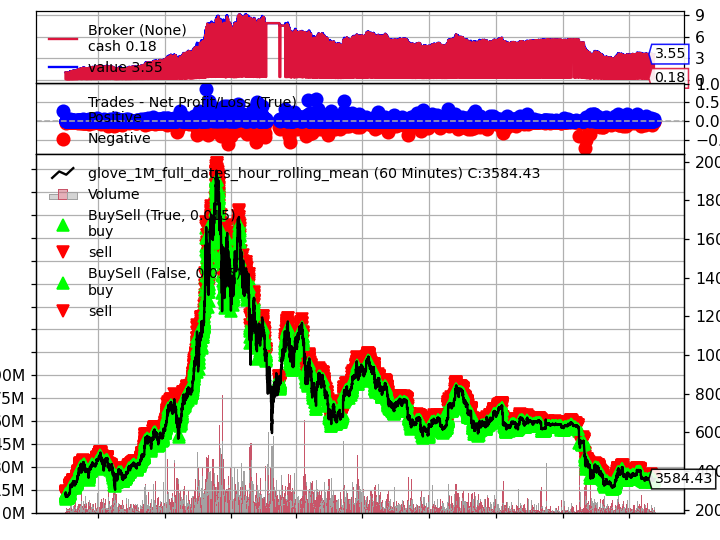

[[<Figure size 640x480 with 4 Axes>]]

In [484]:
#Trading History
cerebro.plot()

In [ ]:
ret_low = returns_fin2.values
ret_mid = returns_fin.values

In [ ]:
#Daily Returns
from matplotlib import pyplot as plt
returns2 = pd.DataFrame(returns_high.values, columns = ['returns'])
returns2.index = returns.index
returns2['datetime'] = returns.index
returns_fin22 = returns2.groupby(['datetime'])['returns'].apply(np.sum)
# plt.title("Daily Returns")
# plt.bar(returns.index, returns_fin)
# plt.hlines(0,returns_fin.index[0],returns_fin.index[-1],color = "black")
# plt.show()

In [ ]:
ret_high = returns_fin22.values

In [ ]:
np.std(ret_high)

In [ ]:
import numpy as np, statsmodels.stats.api as sms

In [ ]:
sms.CompareMeans(ret_high, ret_mid).tconfint_diff(usevar='unequal')

In [ ]:
transactions

In [ ]:
#Transaction Returns
plt.title("Transaction Returns")
plt.bar(transactions.index,transactions['value'])
plt.hlines(0,transactions.index[0],transactions.index[-1],color = "black")
plt.show()

In [ ]:
# Sharpe Ratio
print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())

#### High Mid Low Analysis

In [ ]:
# Low
cerebro.plot()

In [ ]:
# Mid
cerebro.plot()

In [ ]:
#high
cerebro.plot()